# Loan Data from Prosper 
## By Mohamed Maguid

## Preliminary Wrangling

This data set contains `113,937` loans with `81` variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. The dataset contains so-called listings which either have been transformed to a loan or not. Partially funded loans are possible as well. My main overall interest might be why and who is becoming a so-called Prosper borrower and furthermore what is mainly influencing the interest rate. Interesting would be how the average Prosper rate is compared to the normal financial market. 

In [28]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from scipy.stats import norm
from scipy.stats import normaltest
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

%matplotlib inline
warnings.filterwarnings("always")
sb.set(style="whitegrid")

# switch off warnings
import warnings
warnings.filterwarnings("ignore")

In [29]:
# function library 

########################################### metric_distri_qq(data, figsize, bin_size, tick_size)
# Plot the Distribution and the QQ Plot 
## Input variables
#### data: the series which is analyzed
#### fig_size: e.g. [12,7]
#### bin_size: eg. 0.01 --> that's how the bins will be created
#### ticksize: e.g. 0.01 --> that' how the ticks on the x-axis will be created. 


def metric_distri_qq(data, figsize, bin_size, tick_size):
    
    second_color = 'orange'
    # this is the normal blue color
    base_color =  (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
    # Preparation 
    data_min = data.min()
    data_max = data.max()
    number_of_values = len(data)
    
    # quantile split @ 0,5
    qs = ( np.arange( number_of_values ) - .5) / number_of_values

 
    # create the plot
    plt.figure(figsize=figsize)


    # left subplot: plot the data
    # create a histogram of the data
    plt.subplot(1, 2, 1)
    # create a histogram of the data
    bin_edges = np.arange(data_min - bin_size, data_max + bin_size, bin_size)
    plt.hist(data, bins = bin_edges, color = base_color);
    # optimize bins 
    plt.xticks(np.arange(0, data_max + tick_size, tick_size))
    
    # overlay a theoretical normal distribution on top
    samp_mean = data.mean()
    samp_sd = data.std()
    x = np.linspace(data_min, data_max, 1000)
    # normal distribution heights
    y = norm.pdf(x, samp_mean, samp_sd) 
    # scale the distribution height
    y *= number_of_values * bin_size
    # rotate
    plt.xticks(rotation=50)
    # plot the normal distribution
    plt.plot(x, y,  color = second_color);
    plt.xlabel(data.name)
    plt.ylabel('Count');
    plt.title('Obs. Value Distr. + Theoretical Normal Distr.')

    # right subplot: create a Q-Q plot
    plt.subplot(1, 2, 2)
    data_min_scaled = (data_min - samp_mean) / samp_sd
    data_max_scaled = (data_max - samp_mean) / samp_sd
    expected_scores = norm.ppf(qs)
    data_scores = (data.sort_values() - samp_mean) / samp_sd
    plt.scatter(expected_scores, data_scores, color = base_color)
    plt.plot([data_min_scaled-1,data_max_scaled+1],[data_min_scaled-1,data_max_scaled+1],'--', color = second_color)
    plt.axis('equal')
    plt.xlabel('Expected Standard Scores')
    plt.ylabel('Obs. Standard Scores');
    plt.title('Quantile-Quantile Plot')


########################################### metric_distri_qq2(data, figsize, bin_size, start_adj)
# Plot the Distribution (log)  and the QQ Plot 
## Input variables
#### data: the series which is analyzed already log transformed
#### fig_size: e.g. [12,7]
#### bin_size: eg. 0.01 --> that's how the bins will be created
#### start_adj: value where the tick start point  is adjusted 

def metric_distri_qq2(data, figsize, bin_size, start_adj):
    
    second_color = 'orange'
    #  normal blue color
    base_color =  (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
    # Preparation 
    data_min = data.min()
    data_max = data.max()
    number_of_values = len(data)
    
    # quantile split @ 0,5
    qs = (np.arange(number_of_values) - .5) / number_of_values

 
    # create the plot
    plt.figure(figsize=figsize)

    # create a histogram of the data
    plt.subplot(1, 2, 1)

    log_bin_edges = np.arange(data_min+start_adj, data_max + bin_size, bin_size)
    plt.hist(data, bins = log_bin_edges)
    plt.xlabel(data.name + (' log10 Scale'))
    plt.ylabel('Count');
    plt.title('Obs. Log Transf. Value Distr. + Theoretical Normal Distr.')
       
    # overlay a theoretical normal distribution on top
    samp_mean = data.mean()
    samp_sd = data.std()
    x = np.linspace(data_min+start_adj, data_max, 200)
    # normal distribution heights
    y = norm.pdf(x, samp_mean, samp_sd) 
    # scale the distribution height
    y *= number_of_values * bin_size
    # rotate
    plt.xticks(rotation=50)
    # plot the normal distribution
    plt.plot(x, y,  color = second_color);

    
    # right subplot: create a Q-Q plot
    plt.subplot(1, 2, 2)
    data_min_scaled = (data_min - samp_mean) / samp_sd
    data_max_scaled = (data_max - samp_mean) / samp_sd
    expected_scores = norm.ppf(qs)
    data_scores = (data.sort_values() - samp_mean) / samp_sd
    plt.scatter(expected_scores, data_scores, color = base_color)
    plt.plot([data_min_scaled-1,data_max_scaled+1],[data_min_scaled-1,data_max_scaled+1],'--', color = second_color)
    plt.axis('equal')
    plt.xlabel('Expected Standard Scores')
    plt.ylabel('Obs. Standard Scores');
    plt.title('Quantile-Quantile Plot')

    
########################## get_first_threshold_count(any array, threshold, returns the index of the array and the value)
def get_first_threshold_count(counts, threshold=1):
    j=0
    #print(threshold)
    for i in count:
        j += 1
        if i > threshold:
            return(j,i)
            break
        
    
########################## metric_distri_log(data, figsize, bin_size_n, tick_size_n, bin_size_l, tick_locs, initial)
# Plot the Normal Distribution together with the log scale one   
## Input variables
#### bin_size_n = 0.005 
#### tick_size_n = 0.04 
#### bin_size_l = 0.01, 
#### tick_locs e.g. [0.05, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 , 0.44, 0.48]   
#### initial:  True --> prints the bin sizes so one can make out of that the typical 1,3, 10 logsacle  passed on ticklocs


def metric_distri_log(data, figsize, bin_size_n, tick_size_n, bin_size_l, tick_locs, initial):

    # this is the normal blue color
    base_color =  (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
    
    # preparation
    data_min = data.min()
    data_max = data.max()
    
    # left histogram: data plotted in natural units
    plt.figure(figsize = figsize)
    plt.subplot(1, 2, 1)
    bin_edges = np.arange(0, data_max + bin_size_n, bin_size_n)
    plt.hist(data, bins = bin_edges, color = base_color)
    plt.xticks(np.arange(0, data_max + tick_size_n, tick_size_n))
    plt.xlabel(data.name + ' values')
    plt.xticks(rotation=50)
    plt.title('Obs. Values - Original Scale')

    # right histogram: data plotted after direct log transformation
    plt.subplot(1, 2, 2)
    log_data = np.log10(data)
    log_bin_edges = 10 ** np.arange(log_data.min(), log_data.max() + bin_size_l, bin_size_l)
    plt.hist(data, bins = log_bin_edges);
    plt.xscale('log')
    plt.xticks(rotation=50)
    plt.xlabel(data.name + ' log(values)')
    plt.title('Obs. Values - log10 Scale');
    plt.xticks(tick_locs, tick_locs);
    plt.xlim(left=tick_locs[0])
    #plt.xlim(left=0.03)
    if initial == True:
        print(bin_edges)
        
#categorial_2d(data, x, y, percent=True, zoom_x=0, zoom_y=0, fig_size=[12,5], sort=True, annotate=True )
# Plot a heatmap for 2 categorial attributes  
## importing:
#### data=df         : the data frame 
#### x='Occupation'  : the x attribute
#### y='BorrowerState': the y attribute
#### zoom_x=20        : zoom in the first x
#### zoom_y=20        : zoom in the first y 
#### fig_size=[30,15] : picture size
####  percent=True     : plot %
#### annotate=True      : write the counts or %
 
def categorial_2d(data, x, y, percent=True, zoom_x=0, zoom_y=0, fig_size=[12,5], sort=True, annotate=True):
    print(x,y)
    # get the total couts
    ct_counts = data.groupby([x, y]).size()
    # restet the index from grupby
    ct_counts = ct_counts.reset_index(name = 'count')
    
    # make the pivot and organize the state as index(key and the occupations as colums)
    ct_counts = ct_counts.pivot(index = y, columns = x, values = 'count')
    
    if sort==True:
        # get the nice sorting by state and occupation to concentrate the dense values ion the upper left corner
        ct_counts = ct_counts.reindex(index=data[y].value_counts().index, columns=data[x].value_counts().index)
    
    # replace NAs with 0
    ct_counts.fillna(0,inplace=True)
    
    if zoom_x & zoom_y != 0:
        ct_counts = ct_counts.iloc[0:zoom_y, 0:zoom_x]
        yticklabels=df[y].value_counts().index[0:zoom_y]
        xticklabels=df[x].value_counts().index[0:zoom_x]
    else:
        yticklabels=df[y].value_counts().index
        xticklabels=df[x].value_counts().index
        
    
    
    #plot
    if percent == True:
        total_number = len(df)
        print('Denominator: {}'.format(total_number))
        # transform to %
        ct_counts = ct_counts / total_number * 100 
         # create the plot
        plt.figure(figsize=fig_size)
        sb.heatmap(ct_counts, cmap='viridis_r', 
                   annot = annotate, fmt = '.1f',    
                   yticklabels=yticklabels,
                   xticklabels=xticklabels,
                   cbar_kws={'format': '%.2f%%'});
    else:
        plt.figure(figsize=fig_size)
        sb.heatmap(ct_counts, cmap='viridis_r', 
                   annot = annotate, fmt = '.0f',    
                   yticklabels=yticklabels,
                   xticklabels=xticklabels)
                   #cbar_kws={'format': '.2f%%'});


### What is the structure of the dataset?

Some Information about This Dataset can be found in my Google Drive link below.
(https://drive.google.com/file/d/1SnL9_i9fbUx2M2MYTxwZ5jyLbOeLvQAD/view?usp=sharing). <------


* **Bid Object**: A Bid is created when a Lender wishes to lend money to a Borrower in response to a Listing the Borrower created to solicit Bids. Bids are created by specifying an Amount and a Minimum Rate in which the Lender wishes to receive should the Bid win the auction and become a Loan. The Minimum Rate remains private unless the Bid is Outbid by other Bids offering a lower Minimum Rate.

* **Category Object**: A Category is collection of Groups which share a common interest or affiliation. Categories are created by the Prosper Team. Group Leaders can associate their Group with one or more categories as they relate to their group. 

* **CreditProfile Object**: A CreditProfile is a timestamped set of extended credit information for a Member. Row level display and publication of CreditProfile is explicitly forbidden.

* **Group Object**: A Group is a collection of Members who share a common interest or affiliation. Groups are managed by Group Leaders who bring borrowers to Prosper, maintain the group's presence on the site, and collect and/or share Group Rewards. Borrowers who are members of a group often get better interest rates because Lenders tend to have more confidence in Borrowers that belong to trusted Groups. 

* **Listing Object**: A Listing is created by a Borrower to solicit bids by describing themselves and the reason they are looking to borrow money. If the Listing receives enough bids by Lenders to reach the Amount Requested, then after the Listing period ends it will become a Loan. A Borrower may only have one active listing at a particular moment in time. 

* **Loan Object**: A Loan is created when a Borrower has received enough Bids to meet the full amount of money that the Borrower requested in their Listing. The Borrower must then make payments on the Loan to keep its status current. 

* **Loan Performance Object**: A LoanPerformance is an event in a Loan History that causes a change in loan value. This table can be used to calculate roll rates. Row level display and publication of LoanPerformance is explicitly forbidden.

* **Marketplace Object**: The Marketplace is a collection of metrics and statistics about the Prosper Marketplace. These metrics are calculated daily. Historical metrics are provided as well. 

* **Member Object**: A Member is a registered user of the Prosper Marketplace site. A Member may have one or multiple roles which determines which actions the Member is allowed to perform on the site. 



### What is/are the main feature(s) of interest in your dataset?

Based on my high level questions I think these are the main attributes:

* **Who is using Prosper? (basically which individuals, which professions, which part of the country, financial situation)**
    * Occupation
    * EmploymentStatus
    * IsBorrowerHomeowner
    * BorrowerState    

* **Why is Prosper used? (Is it related to rates, fees, or faster processing time)**
    * ListingCreationDate
    * LoanOriginationDate
    * ListingCategory
    * BorrowerAPR
    * BorrowerRate
    * ProsperRating 
    * Term 
    * LoanStatus

* **What is primarily influencing the interest rate? (is it related to scoring, income and history)**
    * ProsperRating (Alpha)
    * ProsperScore
    * DebtToIncomeRatio
    * IncomeRange
    * MonthlyLoanPayment
    * Term 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?


I examined the structure of the dataset utilizing the mentioned sources and categorized 3 main areas with the following attributes. The main attributes are referenced as **bold** below. I assume the other attributes are helping to explain variations and patterns observed in the data. However, they might be not taken into consideration, depending on the analysis.

* **Key and Date Attributes**
    * **ListingNumber**: The number that uniquely identifies the listing to the public as displayed on the website.
    * **ListingCreationDate**: The date the listing was created.
    * **LoanOriginationDate**: The date the loan was originated.
    * MemberKey: The unique key that is associated with the borrower. This is the same identifier that is used in the API member object. 


* **Loan Attributes**
    * **ListingCategory**: The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans
    * **BorrowerAPR**: The Borrower's Annual Percentage Rate (APR) for the loan.
    * **BorrowerRate**: The Borrower's interest rate for this loan. 
    * **ProsperRating (numeric`)**: The  Prosper Rating assigned at the time the listing was created: 0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA.  Applicable for loans originated after July 2009.
    * **ProsperRating (Alpha)**: The Prosper Rating assigned at the time the listing was created between AA - HR.  Applicable for loans originated after July 2009.


    * **ProsperScore**: A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score.  Applicable for loans originated after July 2009.
    * **Term**: The length of the loan expressed in months.
    * **LoanStatus**: The current status of the loan: Cancelled,  Chargedoff, Completed, Current, Defaulted, FinalPaymentInProgress, PastDue. The PastDue status will be accompanied by a delinquency bucket.
    * ClosedDate: Closed date is applicable for Cancelled, Completed, Chargedoff and Defaulted loan statuses. 
    * **LoanOriginalAmount**: The origination amount of the loan.
    * **MonthlyLoanPayment**: The scheduled monthly loan payment.
    * PercentFunded: Percent the listing was funded.
    * InvestmentFromFriendsCount: Number of friends that made an investment in the loan.
    * InvestmentFromFriendsAmount: Dollar amount of investments that were made by friends.
    * Investors: The number of investors that funded the loan.


* **Loan - Borrower Attributes** 
    * **DebtToIncomeRatio**: The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%).
    * **IncomeRange**: The income range of the borrower at the time the listing was created.
    * **Occupation**: The Occupation selected by the Borrower at the time they created the listing.
    * **EmploymentStatu**`: The employment status of the borrower at the time they posted the listing.
    * **EmploymentStatusDuration**: The length in months of the employment status at the time the listing was created.
    * **IsBorrowerHomeowner**: A Borrower will be classified as a homeowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.

 * **BorrowerState**: The two letters abbreviation of the state of the address of the borrower at the time the Listing was created.
    * **EstimatedLoss**: Estimated loss is the estimated principal loss on charge-offs. Applicable for loans originated after July 2009.
    * **EstimatedReturn**: The estimated return assigned to the listing at the time it was created. Estimated return is the difference between the Estimated Effective Yield and the Estimated Loss Rate. Applicable for loans originated after July 2009.
    * CreditScoreRangeLower: The lower value representing the range of the borrower's credit score as provided by a consumer credit rating agency.

   
    * CreditScoreRangeUpper: The upper value representing the range of the borrower's credit score as provided by a consumer credit rating agency. 
    * CurrentCreditLines: Number of current credit lines at the time the credit profile was pulled.
    * OpenCreditLines: Number of open credit lines at the time the credit profile was pulled.
    * TotalCreditLinespast7years: Number of credit lines in the past seven years at the time the credit profile was pulled.
    * InquiriesLast6Months: Number of inquiries in the past six months at the time the credit profile was pulled.
    * CurrentDelinquencies: Number of accounts delinquent at the time the credit profile was pulled.
    * AmountDelinquent: Dollars delinquent at the time the credit profile was pulled.
    * DelinquenciesLast7Years: Number of delinquencies in the past 7 years at the time the credit profile was pulled.

* **Loan - Borrower Attributes** continue
    * RevolvingCreditBalance: Dollars of revolving credit at the time the credit profile was pulled.
    * BankcardUtilization: percentage of available revolving credit that is utilized at the time the credit profile was pulled.
    * AvailableBankcardCredit: The total available credit via bank card at the time the credit profile was pulled.
    * IncomeVerifiable: The borrower indicated they have the required documentation to support their income.
    * StatedMonthlyIncome: The monthly income the borrower stated at the time the listing was created.
    * TotalProsperLoans: Number of Prosper loans the borrower at the time they created this listing. This value will be null if the borrower had no prior loans. 
    * TotalProsperPaymentsBilled: Number of on time payments the borrower made on Prosper loans at the time they created this listing. This value will be null if the borrower had no prior loans.
    

* OnTimeProsperPayments: Number of on time payments the borrower had made on Prosper loans at the time they created this listing. This value will be null if the borrower has no prior loans.
    * ProsperPaymentsLessThanOneMonthLate: Number of payments the borrower made on Prosper loans that were less than one month late at the time they created this listing. This value will be null if the borrower had no prior loans. 
    * ProsperPaymentsOneMonthPlusLate: Number of payments the borrower made on Prosper loans that were greater than one month late at the time they created this listing. This value will be null if the borrower had no prior loans.
    * ProsperPrincipalBorrowed: Total principal borrowed on Prosper loans at the time the listing was created. This value will be null if the borrower had no prior loans.
    * ProsperPrincipalOutstanding: Principal outstanding on Prosper loans at the time the listing was created. This value will be null if the borrower had no prior loans.
    * ScorexChangeAtTimeOfListing: Borrower's credit score changes at the time the credit profile was pulled. This will be the change relative to the borrower's last Prosper loan. This value will be null if the borrower had no prior loans.
    * Recommendations: Number of recommendations the borrower had at the time the listing was created.

## Gather Data 

In [30]:
# load the csv
df=pd.read_csv('prosperLoanData.csv')
df_copy=df.copy()

## Univariate Exploration

### Some cleaning basic cleaning upfront

In [31]:
# harmonize and shrink the dataset based on the above mentioned rationales
# read the selected attributes
attr_2_be_del = pd.read_csv('Attributes_Not_Selected.csv')

In [32]:
# drop the columns not needed
for attr in attr_2_be_del.Attributes:
    df.drop([attr], axis=1, inplace=True)

In [33]:
# rename some colums with blanks 
for column in df:
    df.rename(index=str, columns={column: column.replace(' ', '')}, inplace=True)
for column in df:
    df.rename(index=str, columns={column: column.replace('(', '_')}, inplace=True)
for column in df:    
    df.rename(index=str, columns={column: column.replace(')', '')}, inplace=True)

### Missing Values 

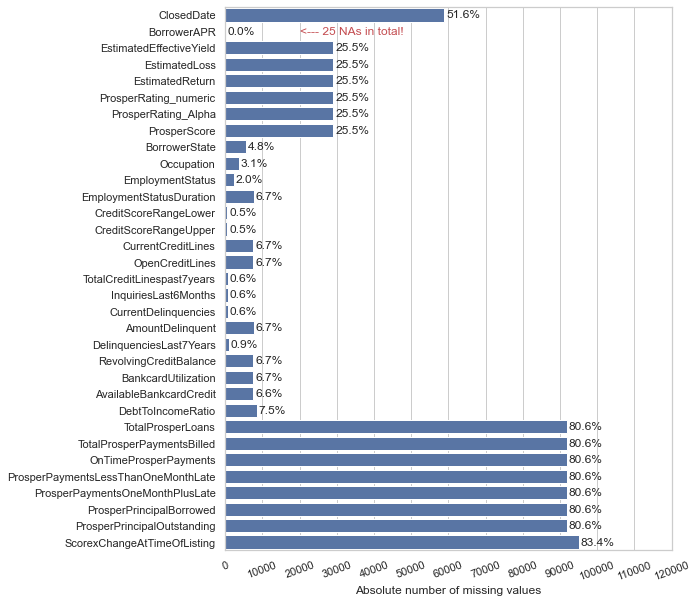

In [34]:
# Get an overview on the remaining colums
# set the base color
base_color = sb.color_palette()[0]

# plot a horizontal bar chart for missing values
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts>0]
plt.figure(figsize=(8,10))
sb.barplot(x=null_counts, y=np.arange(len(null_counts)), orient = 'h', color=base_color)
plt.xlabel('Absolute number of missing values')
plt.xticks(np.arange(0,130000,10000), rotation=20)
plt.yticks(np.arange(len(null_counts)),null_counts.index,rotation='horizontal');

# annotate with %
for i in np.arange(len(null_counts)):
    prop = null_counts[i]/len(df)
    if prop > 0:
        pct_string = '{:0.1f}%'.format(100*prop)
        #print(pct_string)
        plt.text(null_counts[i]+500, i, pct_string, va = 'center')
# annotate a small number>        
plt.text(20000, 1, '<--- 25 NAs in total!', va = 'center', color='r');

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113937 entries, 0 to 113936
Data columns (total 53 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingNumber                        113937 non-null  int64  
 1   ListingCreationDate                  113937 non-null  object 
 2   Term                                 113937 non-null  int64  
 3   LoanStatus                           113937 non-null  object 
 4   ClosedDate                           55089 non-null   object 
 5   BorrowerAPR                          113912 non-null  float64
 6   BorrowerRate                         113937 non-null  float64
 7   LenderYield                          113937 non-null  float64
 8   EstimatedEffectiveYield              84853 non-null   float64
 9   EstimatedLoss                        84853 non-null   float64
 10  EstimatedReturn                      84853 non-null   float64
 11  ProsperRating_nume

`Comment`: Ok, let's comment and decide what to do?

* Occupation: 3.1 % -> Handle during Univariate / data type could be changed to categorial
* EmploymentStatus: 2% -> Handle during Univariate / data type could be changed to categorial
* BorrowerState: 4,8 -> Handle during Univariate / / data type could be changed to categorial
* BorrowerAPR: 25 in total -> Handle during Univariate / data type ok
* ProsperRating: only after July 2009, I believe this fact is the root cause of the 25,5% missing values  -> Handle during Univariate / data type ok
* ProsperRating (Alpha): same as above / data type ok
* ProsperScore: same as above / data type ok
* DebtToIncomeRatio: 7,5% -> Handle during Univariate / data type ok

Ther is fundamaental amount missing for closed date, which I believe is mainly die to the fact that the majority of loans are still running. Furthermore the section at the bottom, introduced bay TotalProspertLoans, TotalProsperPaymentBilled, etc. are aggregations based on historical data, hence if we haev first time lenders, those will be not filled. 


Start with the Univariate Analysis ...

### ProsperRating (Alpha) / ProsperRating
The Prosper Rating assigned at the time the listing was created between AA - HR. Applicable for loans originated after July 2009.
0 - N/A, 1 - HR, 2 - E, 3 - D, 4 - C, 5 - B, 6 - A, 7 - AA. 

In [36]:
df.ProsperRating_numeric.value_counts()

4.0    18345
5.0    15581
6.0    14551
3.0    14274
2.0     9795
1.0     6935
7.0     5372
Name: ProsperRating_numeric, dtype: int64

In [37]:
df.ProsperRating_Alpha.value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating_Alpha, dtype: int64

In [38]:
df.ProsperRating_Alpha.dtype

dtype('O')

In [39]:
df[['ProsperRating_Alpha', 'CreditScoreRangeLower', 'CreditScoreRangeUpper']].head(10)

ProsperRating_Alpha  CreditScoreRangeLower  CreditScoreRangeUpper
0                 NaN                  640.0                  659.0
1                   A                  680.0                  699.0
2                 NaN                  480.0                  499.0
3                   A                  800.0                  819.0
4                   D                  680.0                  699.0
5                   B                  740.0                  759.0
6                   E                  680.0                  699.0
7                   C                  700.0                  719.0
8                  AA                  820.0                  839.0
9                  AA                  820.0                  839.0

`Comment`: As we have 25% not populated because the Prosper Rating started after July 2009 I thought maybe a simple rule (or even regression) for the derivation of the Prosper
rating based on the external one would be easy. But it is not as e.g. D is between 680 - 699 and E later down as well. So let's flag them as before_July09
and analyze keeping decide at th end to keep or to get rid of them.

In [40]:
df.ProsperRating_Alpha.fillna('before_July09', inplace=True)
df.ProsperRating_Alpha.value_counts()

before_July09    29084
C                18345
B                15581
A                14551
D                14274
E                 9795
HR                6935
AA                5372
Name: ProsperRating_Alpha, dtype: int64

In [41]:
# ok it's string let's convert into a categorial var with the right order. 

In [42]:
#survey_responses = pd.Categorical(responses, categories=["happy", "content", "sad"], ordered=True)
df.ProsperRating_Alpha = pd.Categorical(df.ProsperRating_Alpha, categories=["AA", "A", "B", "C", "D", "E", "HR", "before_July09"], ordered=True)

In [43]:
df.ProsperRating_Alpha.describe()

count            113937
unique                8
top       before_July09
freq              29084
Name: ProsperRating_Alpha, dtype: object

In [44]:
df.ProsperRating_Alpha.sort_values().head(10)

92781    AA
52828    AA
29329    AA
52838    AA
96696    AA
29302    AA
12779    AA
82795    AA
29286    AA
96714    AA
Name: ProsperRating_Alpha, dtype: category
Categories (8, object): ['AA' < 'A' < 'B' < 'C' < 'D' < 'E' < 'HR' < 'before_July09']

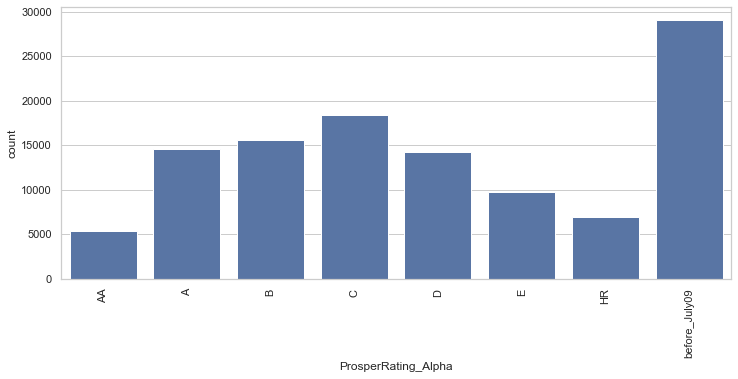

In [45]:
# let's visualize
plt.figure(figsize = [12, 5])
sb.countplot(data = df, x = 'ProsperRating_Alpha',color=base_color)
            
plt.xticks(rotation=90);

`Comment`: For further analysis, we need to exclude the records "before_July09" (so let's remove them).  The other rating counts are nicely centred around "C" which divides lower risks and higher risks.

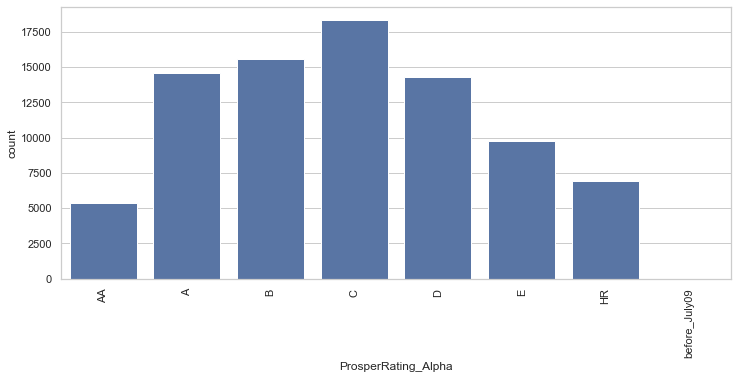

In [46]:
df = df[df.ProsperRating_Alpha != 'before_July09']
# let's visualize
plt.figure(figsize = [12, 5])
sb.countplot(data = df, x = 'ProsperRating_Alpha',color=base_color)
plt.xticks(rotation=90);
df['ProsperRating_Alpha'] = df['ProsperRating_Alpha'].cat.remove_categories(['before_July09'])

### ProsperScore

A custom risk score built using historical Prosper data. The score ranges from 1-10, with 10 being the best, or lowest risk score. Applicable for loans originated after July 2009.

In [47]:
df.ProsperScore.value_counts()

4.0     12595
6.0     12278
8.0     12053
7.0     10597
5.0      9813
3.0      7642
9.0      6911
2.0      5766
10.0     4750
11.0     1456
1.0       992
Name: ProsperScore, dtype: int64

In [48]:
print(df.ProsperScore.nunique(), df.ProsperScore.dtype) 

11 float64


In [49]:
df.ProsperScore.isna().sum()

0

`Comment`: ok it's 11 levels as seen in the data and in that [link](https://www.prosper.com/plp/general-prosper_score/).

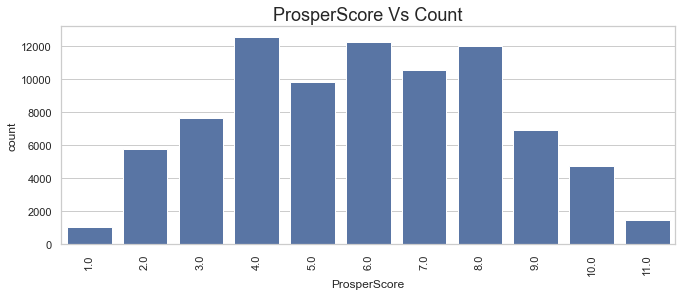

In [50]:
# let's visualize
plt.figure(figsize = [11, 4])
sb.countplot(data = df, x = 'ProsperScore',color=base_color)         
plt.xticks(rotation=90)
plt.title('ProsperScore Vs Count', fontsize=18);

`Comment`: The other scores counts are somehow centred around "6" which divides lower risks and higher risks. Although the 8 and 4 are as well very dominant.


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84853 entries, 1 to 113936
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ListingNumber                        84853 non-null  int64   
 1   ListingCreationDate                  84853 non-null  object  
 2   Term                                 84853 non-null  int64   
 3   LoanStatus                           84853 non-null  object  
 4   ClosedDate                           26005 non-null  object  
 5   BorrowerAPR                          84853 non-null  float64 
 6   BorrowerRate                         84853 non-null  float64 
 7   LenderYield                          84853 non-null  float64 
 8   EstimatedEffectiveYield              84853 non-null  float64 
 9   EstimatedLoss                        84853 non-null  float64 
 10  EstimatedReturn                      84853 non-null  float64 
 11  ProsperRating_numer

### Occupation

The Occupation selected by the Borrower at the time they created the listing.

In [52]:
df.Occupation.value_counts()

Other                          21317
Professional                   10542
Executive                       3468
Computer Programmer             3236
Teacher                         2888
                               ...  
Judge                             22
Student - College Freshman        17
Student - College Sophomore       16
Student - Community College       10
Student - Technical School         2
Name: Occupation, Length: 67, dtype: int64

`Comment`: Oh my god, seems to be free text entry, actually not that bad. 67 different professions, majority is in _Others_, btw the missing values (3.1%) we can move to others

In [53]:
# change Occupation NAs to "Others"
df['Occupation'].fillna(df.Occupation.value_counts().index[0], inplace=True)

In [54]:
df.Occupation.value_counts().isnull().sum()

0

In [55]:
df['Occupation'] = df['Occupation'].astype('category')

In [56]:
df.Occupation.dtype

CategoricalDtype(categories=['Accountant/CPA', 'Administrative Assistant', 'Analyst',
                  'Architect', 'Attorney', 'Biologist', 'Bus Driver',
                  'Car Dealer', 'Chemist', 'Civil Service', 'Clergy',
                  'Clerical', 'Computer Programmer', 'Construction', 'Dentist',
                  'Doctor', 'Engineer - Chemical', 'Engineer - Electrical',
                  'Engineer - Mechanical', 'Executive', 'Fireman',
                  'Flight Attendant', 'Food Service',
                  'Food Service Management', 'Homemaker', 'Investor', 'Judge',
                  'Laborer', 'Landscaping', 'Medical Technician',
                  'Military Enlisted', 'Military Officer', 'Nurse (LPN)',
                  'Nurse (RN)', 'Nurse's Aide', 'Other', 'Pharmacist',
                  'Pilot - Private/Commercial',
                  'Police Officer/Correction Officer', 'Postal Service',
                  'Principal', 'Professional', 'Professor', 'Psychologist',
          

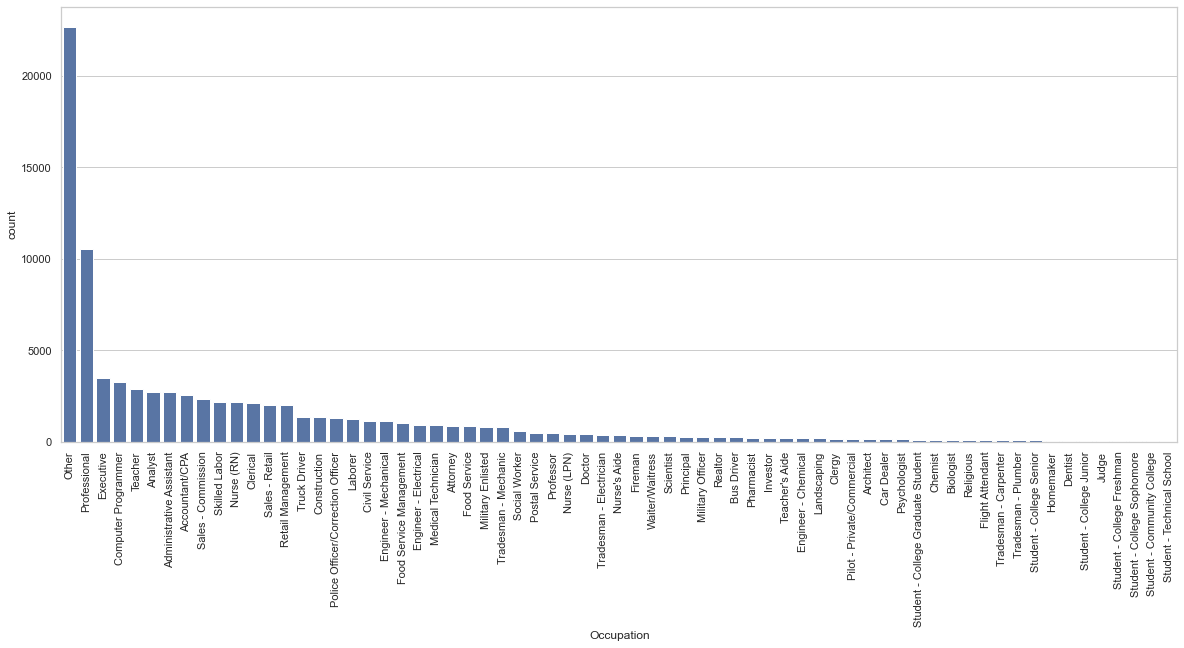

In [57]:
# let's do a bar plot
plt.figure(figsize = [20, 8])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'Occupation',color=base_color, order=df['Occupation'].value_counts().index)
plt.xticks(rotation=90);

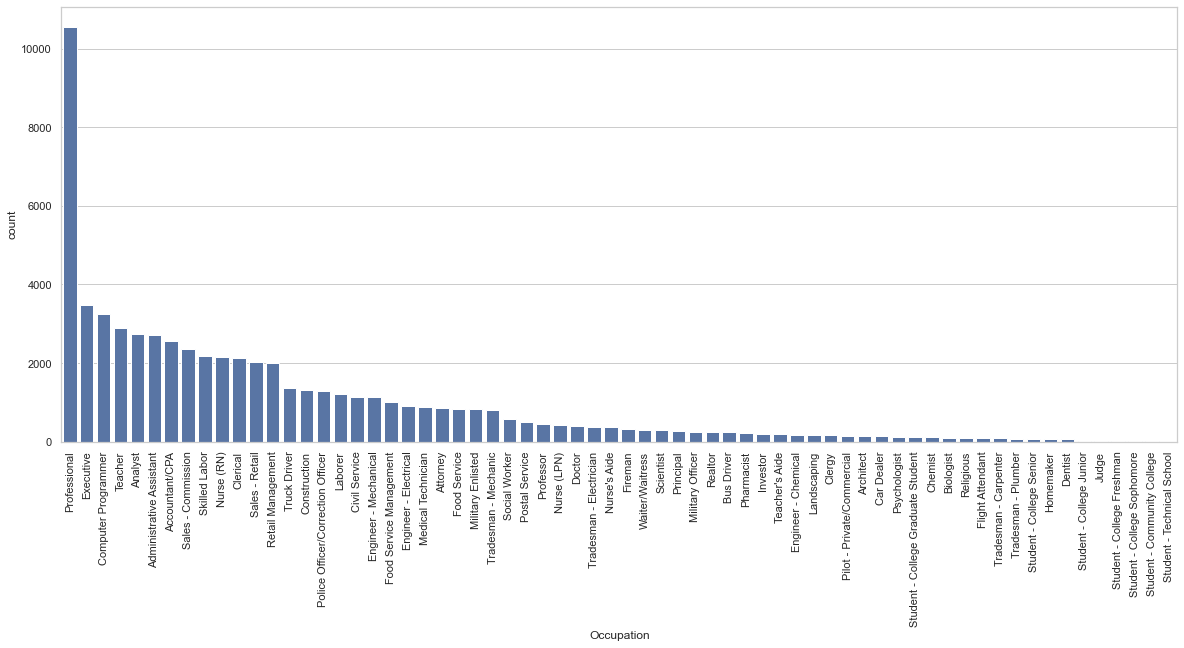

In [58]:
# let's show the values after "Others"

plt.figure(figsize = [20, 8])
sb.countplot(data = df, x = 'Occupation',color=base_color, 
             order=df['Occupation'].value_counts().iloc[1:].index)
plt.xticks(rotation=90);

`Comment`: Leaving the occupation euqals to "Other" out gives a good picture on the different professions, however most counted vales are "Other" and "Professional".

### EmploymentStatus
The employment status of the borrower at the time they posted the listing.

In [59]:
df.EmploymentStatus.value_counts()

Employed         67310
Full-time         7927
Self-employed     4538
Other             3806
Not employed       649
Retired            367
Part-time          256
Name: EmploymentStatus, dtype: int64

In [60]:
df.EmploymentStatus.isna().sum()

0

`Comment`: Change to catergorial.

In [61]:
# change to categorial
df['EmploymentStatus'] = df['EmploymentStatus'].astype('category')

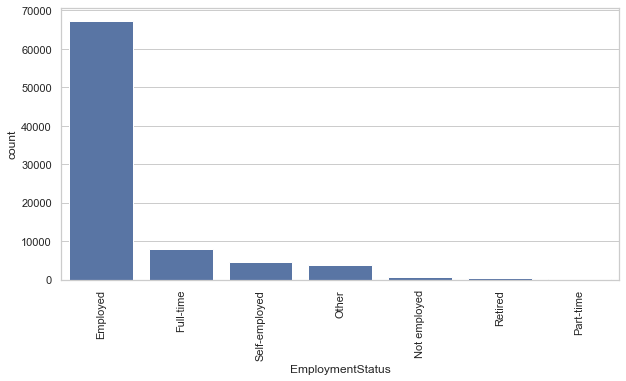

In [62]:
# let's do a bar plot
plt.figure(figsize = [10, 5])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'EmploymentStatus',color=base_color, order=df['EmploymentStatus'].value_counts().index)
plt.xticks(rotation=90);

`Comment`: Most values are labeled as "Employed". 2nd highest is "Full-time" which could be as well "Employed". The same applies for "Part-time", where is the real distinguishing to "Employeed". 
A dimension reduction strategy here is to combine already categories: Employed + Full-time = Employed(full-time)

In [63]:
# first add new categories 
df['EmploymentStatus'] = df['EmploymentStatus'].cat.add_categories(['Employed (full-time)'])

In [64]:
# now get the Full-times and change to the Employed(full-time)
full_time = df[df['EmploymentStatus'] == 'Full-time'].index
df.loc[full_time, 'EmploymentStatus'] = 'Employed (full-time)'

# change as well  the Employed to Employed(full-time)
full_time = df[df['EmploymentStatus'] == 'Employed'].index
df.loc[full_time, 'EmploymentStatus'] = 'Employed (full-time)'

In [65]:
# get rid of the consolidated categories
df['EmploymentStatus'] = df['EmploymentStatus'].cat.remove_categories(['Employed', 'Full-time'])

Index(['Not employed', 'Other', 'Part-time', 'Retired', 'Self-employed',
       'Employed (full-time)'],
      dtype='object')


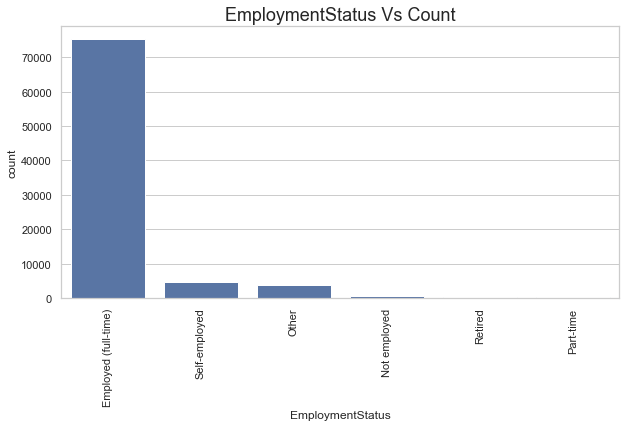

In [66]:
# let's do a bar plot
plt.figure(figsize = [10, 5])
base_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'EmploymentStatus',color=base_color, order=df['EmploymentStatus'].value_counts().index)
plt.xticks(rotation=90);
plt.title('EmploymentStatus Vs Count', fontsize=18)
print(df['EmploymentStatus'].cat.categories)

`Comment`: Most lenders are "Employed (full-time) only a small proportion is "Self-employed". Even less is the proportion of "Part-time" workers. 

### IsBorrowerHomeowner
A Borrower will be classified as a homowner if they have a mortgage on their credit profile or provide documentation confirming they are a homeowner.

In [67]:
sorted_counts=df.IsBorrowerHomeowner.value_counts().sort_values(ascending = False)
sorted_counts

True     44848
False    40005
Name: IsBorrowerHomeowner, dtype: int64

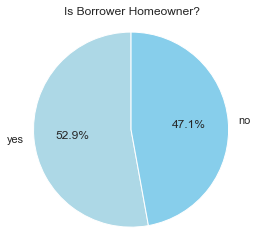

In [68]:
# plot a piechart 
plt.pie(sorted_counts, labels = ['yes', 'no'], startangle = 90, autopct='%1.1f%%', 
        counterclock = True, colors=['lightblue','skyblue']);
plt.axis('square')
plt.title('Is Borrower Homeowner?');


In [69]:
# I don' like the boolean variable false. 

In [70]:
df['IsBorrowerHomeowner'].replace({True: 'Yes', False: 'No'}, inplace=True)

df.IsBorrowerHomeowner = pd.Categorical(df.IsBorrowerHomeowner, 
                                  categories=['Yes', 'No'], ordered=True)
df.IsBorrowerHomeowner.value_counts()

Yes    44848
No     40005
Name: IsBorrowerHomeowner, dtype: int64

`Comment`: Nearly evenly distributed, this is nice and can be analyzed further. In Bivariate e.g. together with income etc...


### BorrowerState
The two letters abbreviation of the state of the address of the borrower at the time the Listing was created.

In [71]:
df.BorrowerState.value_counts(normalize=True)

CA    0.126819
NY    0.068872
TX    0.066397
FL    0.063710
IL    0.050252
OH    0.039751
GA    0.039445
VA    0.032751
NJ    0.032114
PA    0.031560
MI    0.030900
NC    0.028744
MD    0.026410
WA    0.025373
MA    0.021578
MO    0.021131
CO    0.020376
MN    0.020211
IN    0.019469
TN    0.018125
WI    0.017925
CT    0.017583
AZ    0.015992
OR    0.014307
AL    0.013989
NV    0.012068
SC    0.011714
KY    0.010465
KS    0.010064
LA    0.009911
AR    0.009063
OK    0.008627
MS    0.007955
NE    0.006541
UT    0.006152
NH    0.005221
RI    0.004820
ID    0.004749
HI    0.004030
NM    0.003901
DC    0.003866
WV    0.003653
DE    0.003147
MT    0.002605
SD    0.002227
VT    0.002015
AK    0.001968
WY    0.001450
Name: BorrowerState, dtype: float64

In [72]:
# Missing Values
df.BorrowerState.isnull().sum()

0

In [73]:
# originally I had the prosper_score (with the 25% missing values mot in the beginning)
# Let's distribute the NAs propotional to the States observed
# https://stackoverflow.com/questions/44867219/pandas-filling-na-values-to-be-filled-based-on-distribution-of-existing-values

In [74]:
null_counts = df.BorrowerState.value_counts(normalize=True)
#null_counts

In [75]:
# assign the missing values
#missing = df['BorrowerState'].isnull()
# take a sample from the missing states based on the proportion (probability) of it's counts and assign it to the
# missing values
#df.loc[missing,'BorrowerState'] = np.random.choice(null_counts.index, size=len(df[missing]),p=null_counts.values)
# change to categorial
df['BorrowerState'] = df['BorrowerState'].astype('category')
print(df.BorrowerState.isnull().sum())

0


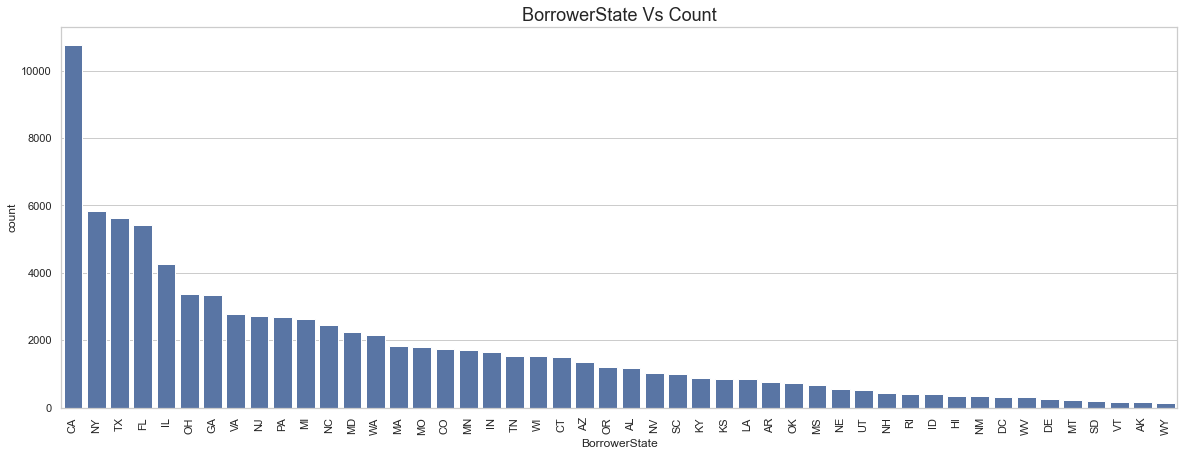

In [76]:
# let's show the values after "Others"
plt.figure(figsize = [20, 7])
sb.countplot(data = df, x = 'BorrowerState',color=base_color, 
             order=df['BorrowerState'].value_counts().index)
plt.xticks(rotation=90)
plt.title('BorrowerState Vs Count', fontsize=18);

`Comments`: Ok, California is leading clearly that distribution, might be that all of those "Computer Programmers" are located in Silicon Valley. 

### ListingCreationDate
The date the listing was created.

In [77]:
df.ListingCreationDate.describe()

count                             84853
unique                            83980
top       2013-10-02 17:20:16.550000000
freq                                  6
Name: ListingCreationDate, dtype: object

`Comment`: The data typs is string let's covert to date

In [78]:
df.ListingCreationDate =  pd.to_datetime(df['ListingCreationDate'])

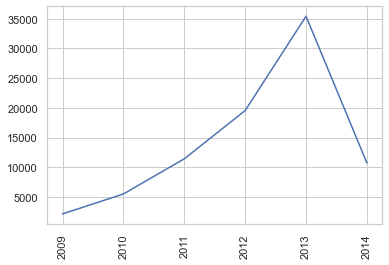

In [79]:
df['ListingCreationDate'].dt.week
df['ListingCreationDate'].dt.year
yearly_dev = df.groupby(df['ListingCreationDate'].dt.year)['ListingCreationDate'].count().reset_index(name = 'Yearly_Count')
plt.errorbar(data = yearly_dev, x = 'ListingCreationDate', y = 'Yearly_Count')
years = np.arange(2009, 2015, 1)
plt.xticks(years,rotation=90);

In [80]:
df.ListingCreationDate.max()

Timestamp('2014-03-10 12:20:53.760000')

`Comment`: There is a clear upward over the years, as 2014 is only available till mid of march it is not really a drop. 

### LoanOriginationDate
The date the loan was originated.

In [81]:
df.LoanOriginationDate.describe()

count                   84853
unique                   1165
top       2014-01-22 00:00:00
freq                      491
Name: LoanOriginationDate, dtype: object

In [82]:
df.LoanOriginationDate =  pd.to_datetime(df['LoanOriginationDate'])

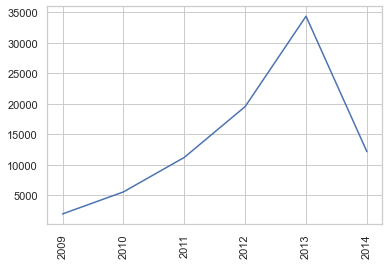

In [83]:
yearly_dev = df.groupby(df['LoanOriginationDate'].dt.year)['LoanOriginationDate'].count().reset_index(name = 'Yearly_Count')
plt.errorbar(data = yearly_dev, x = 'LoanOriginationDate', y = 'Yearly_Count')
years = np.arange(2009, 2015, 1)
plt.xticks(years,rotation=90);

`Comment`: Nearly the same as the ListingCreationDate.

### ListingCategory
The category of the listing that the borrower selected when posting their listing: 0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans

In [84]:
df.ListingCategory_numeric.value_counts(normalize=True)

1     0.626731
7     0.108635
2     0.080150
3     0.062437
6     0.026363
13    0.023523
15    0.017937
18    0.010430
14    0.010324
20    0.009086
19    0.009051
16    0.003583
5     0.003229
11    0.002557
8     0.002345
10    0.001072
9     0.001002
12    0.000695
17    0.000613
0     0.000236
Name: ListingCategory_numeric, dtype: float64

In [85]:
# transform the variable
## step 1: create a pandas series index 0 = Not Avalibale....
data = np.array(['Not Available','Debt Consolidation','Home Improvement','Business',
                 'Personal Loan','Student Use','Auto','Other','Baby&Adoption',
                 'Boat','Cosmetic Procedure','Engagement Ring','Green Loans','Household Expenses',
                 'Large Purchases','Medical/Dental','Motorcycle','RV','Taxes',
                 'Vacation','Wedding Loans'])
listing_category_alpha = pd.Series(data)

In [86]:
## Step 2 define a function which gives based on zeh index the cat string
def trans_2_cat(x):
    category = listing_category_alpha[x]
    return category
## create a new attribute 
df['ListingCategory_alpha'] = df['ListingCategory_numeric'].apply(trans_2_cat)
## transform to categorial
df['ListingCategory_alpha'] = df['ListingCategory_alpha'].astype('category')

In [87]:
df.ListingCategory_alpha.value_counts(normalize=True)

Debt Consolidation    0.626731
Other                 0.108635
Home Improvement      0.080150
Business              0.062437
Auto                  0.026363
Household Expenses    0.023523
Medical/Dental        0.017937
Taxes                 0.010430
Large Purchases       0.010324
Wedding Loans         0.009086
Vacation              0.009051
Motorcycle            0.003583
Student Use           0.003229
Engagement Ring       0.002557
Baby&Adoption         0.002345
Cosmetic Procedure    0.001072
Boat                  0.001002
Green Loans           0.000695
RV                    0.000613
Not Available         0.000236
Name: ListingCategory_alpha, dtype: float64

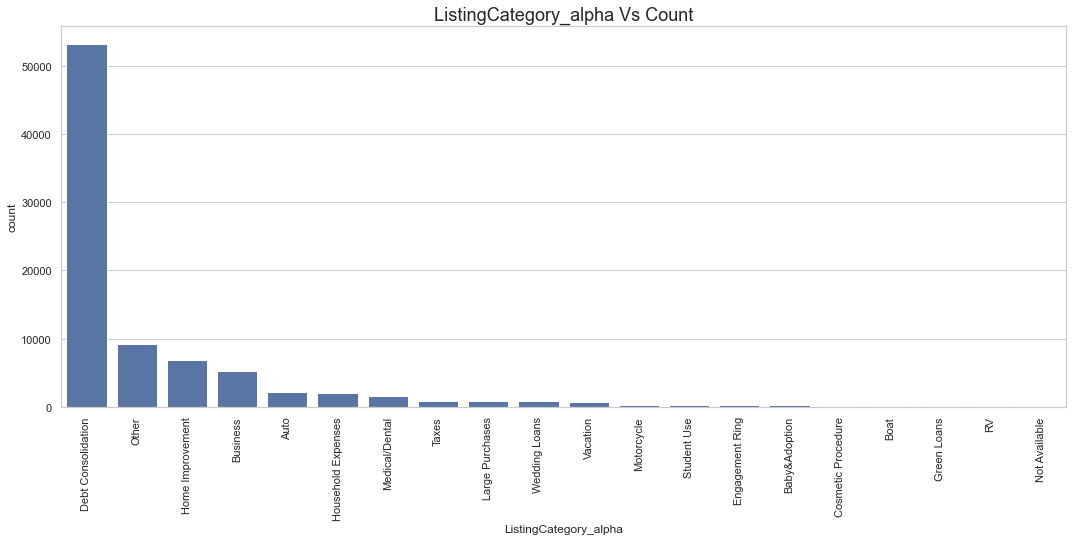

In [88]:
# let's visualize
plt.figure(figsize = [18, 7])
sb.countplot(data = df, x = 'ListingCategory_alpha',color=base_color, 
             order=df['ListingCategory_alpha'].value_counts().index)
plt.xticks(rotation=90)
plt.title('ListingCategory_alpha Vs Count', fontsize=18);

`Comment`: This is not a surprise, actually in the various articles I read about P2P lending, it is often mentioned that this type of loan is ideal to consolidate different loans including credit card debts. Here we can see that more than the half of lall loans are used for that purpose. Also here 
merge "Not Available" to Others.

In [89]:
# first add new categories 
#df['ListingCategory_alpha'] = df['ListingCategory_alpha'].cat.add_categories(['Employed (full-time)'])

# get the not avalible and chnage it to Other
na_ = df[df['ListingCategory_alpha'] == 'Not Available'].index
df.loc[na_, 'ListingCategory_alpha'] = 'Other'

# remove the unused cat
df['ListingCategory_alpha'] = df['ListingCategory_alpha'].cat.remove_categories(['Not Available'])

#df['EmploymentStatus'] = df['EmploymentStatus'].cat.add_categories(['Others (incl. n/a)'])
df['ListingCategory_alpha'].cat.categories

Index(['Auto', 'Baby&Adoption', 'Boat', 'Business', 'Cosmetic Procedure',
       'Debt Consolidation', 'Engagement Ring', 'Green Loans',
       'Home Improvement', 'Household Expenses', 'Large Purchases',
       'Medical/Dental', 'Motorcycle', 'Other', 'RV', 'Student Use', 'Taxes',
       'Vacation', 'Wedding Loans'],
      dtype='object')

### BorrowerAPR
The Borrower's Annual Percentage Rate (APR) for the loan.

In [90]:
df.BorrowerAPR.isna().sum()

0

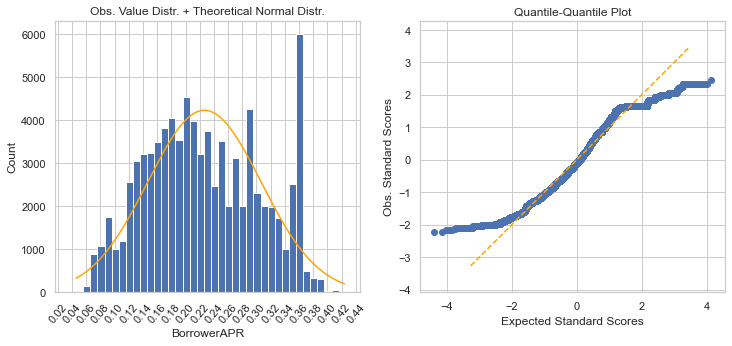

In [91]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is already so useful
metric_distri_qq(df.BorrowerAPR, [12,5],  0.01, 0.02)

`Comment`: Difficult ... there are a lot of values at the end in the bins of <font color='red'>0,35 - 0,36</font> (btw. which is more than 30%). However looking to the distribution I would say it can be considered as normal distributed.

### BorrowerRate
The Borrower's interest rate for this loan.

In [92]:
df.BorrowerRate.describe()

count    84853.000000
mean         0.196022
std          0.074631
min          0.040000
25%          0.135900
50%          0.187500
75%          0.257400
max          0.360000
Name: BorrowerRate, dtype: float64

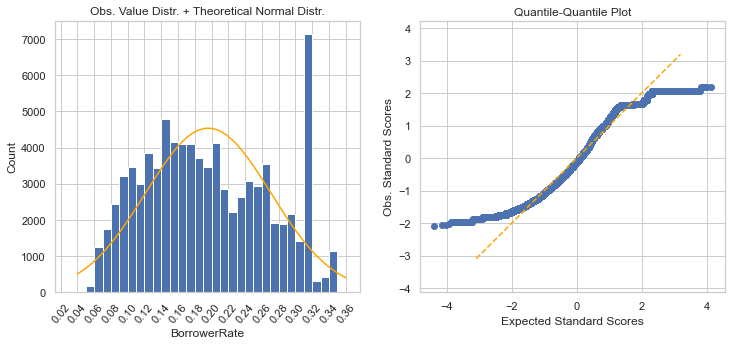

In [93]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.BorrowerRate, [12,5],  0.01, 0.02)

`Comment`: Very similar to the APR which is no surprise as the APR is including the fees and teg the rate, actually everthing the borrower needs to pay for. Actually a bit better then the APR as on there is only one spike far right in the bin of <font color='red'>0,33</font>. This might be related to the spike of the BorrowerAPR.

### Term

In [94]:
df.Term.describe()

count    84853.000000
mean        42.486135
std         11.640346
min         12.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: Term, dtype: float64

In [95]:
df.Term.isna().sum()

0

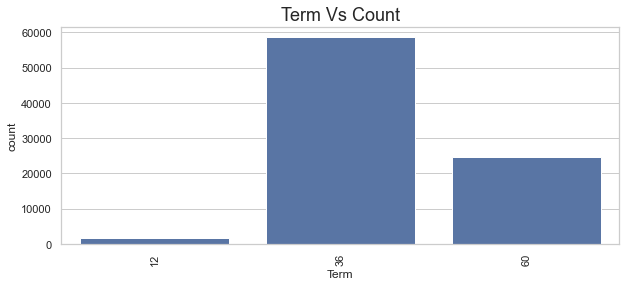

In [96]:
# let's visualize
plt.figure(figsize = [10, 4])
sb.countplot(data = df, x = 'Term',color=base_color)         
plt.xticks(rotation=90)
plt.title('Term Vs Count', fontsize=18);

`Comment`: 36 month term is clearly dominant, followed by 60 month. 12 month seems to be not that important.

### LoanStatus

In [97]:
df.LoanStatus.describe()

count       84853
unique         11
top       Current
freq        56576
Name: LoanStatus, dtype: object

In [98]:
df.LoanStatus.isna().sum()

0

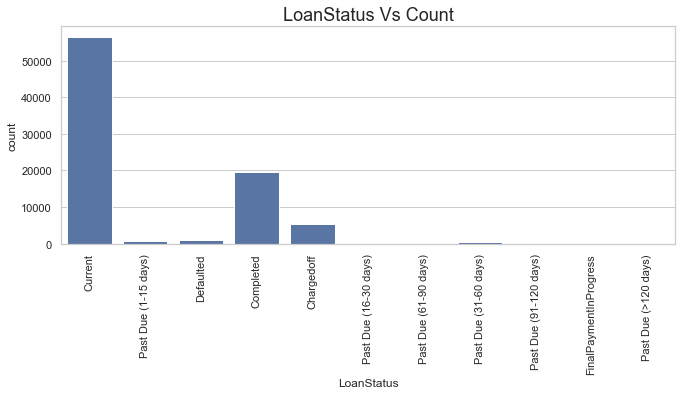

In [99]:
plt.figure(figsize = [11, 4])
sb.countplot(data = df, x = 'LoanStatus',color=base_color)         
plt.xticks(rotation=90)
plt.title('LoanStatus Vs Count', fontsize=18);

In [100]:
df.LoanStatus.value_counts(normalize=True)

Current                   0.666753
Completed                 0.231742
Chargedoff                0.062885
Defaulted                 0.011844
Past Due (1-15 days)      0.009499
Past Due (31-60 days)     0.004278
Past Due (61-90 days)     0.003689
Past Due (91-120 days)    0.003583
Past Due (16-30 days)     0.003123
FinalPaymentInProgress    0.002416
Past Due (>120 days)      0.000189
Name: LoanStatus, dtype: float64

`Comment`: Most of the loans are in good shape either "Completed" or "Current", some of the loans are in in a Past Due category indicating that the lender is behind the payment schedule.
Finally there is a considerable amount of loans defaulted (comes after the Past Due)  and even more are finally Charged Off (appr. 6%). Which indicates the potential risk.

###  DebtToIncomeRatio
The debt to income ratio of the borrower at the time the credit profile was pulled. This value is Null if the debt to income ratio is not available. This value is capped at 10.01 (any debt to income ratio larger than 1000% will be returned as 1001%). The lower the better!

In [101]:
df.DebtToIncomeRatio.describe()

count    77557.000000
mean         0.258752
std          0.318326
min          0.000000
25%          0.150000
50%          0.220000
75%          0.320000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

In [102]:
print(df.DebtToIncomeRatio.isna().sum() , df[df['DebtToIncomeRatio'] == 0.0]['ListingNumber'].count())

7296 6


`Comment`: As I don't konw how the Ratio is excatly caluclated I need to exclude the NAs. The 19 records with 0.0 I treat as properly calculated

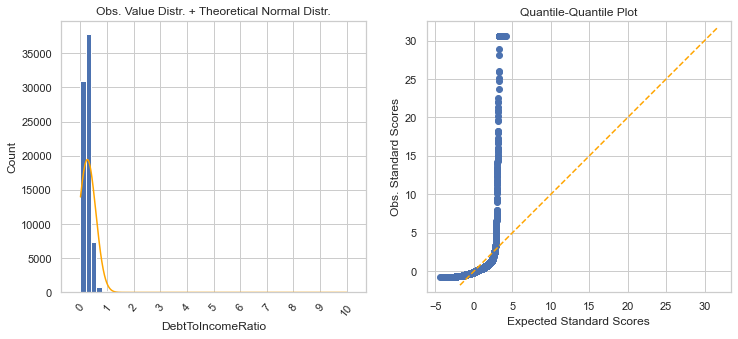

In [103]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df[df.DebtToIncomeRatio.notnull()]['DebtToIncomeRatio'], [12,5],  0.2, 1.0)

`Comment`: This isn't looking normal distributed at all. As it's a financial KPI and the original scale is pretty much right skewed, a log scale might better explain the distribution.

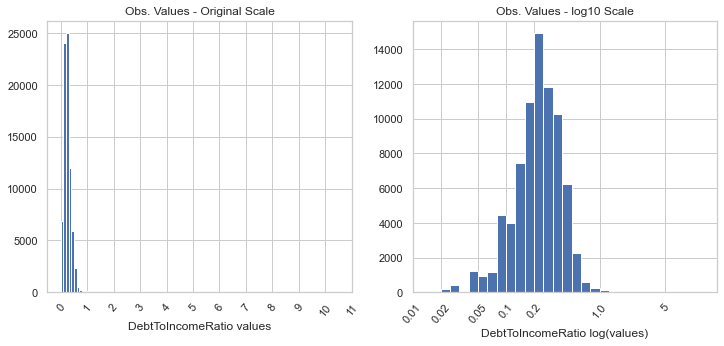

In [104]:
# ok let's do a scale log transformation
metric_distri_log(data = df[df.DebtToIncomeRatio.notnull() & df.DebtToIncomeRatio > 0]['DebtToIncomeRatio'],
                  figsize = [12, 5],
                  bin_size_n = 0.1,
                  tick_size_n = 1.0,
                  bin_size_l = 0.1,
                  tick_locs = [0.01, 0.02, 0.05, 0.1, 0.2, 0,5,1.0 ],
                  initial = False)

`Comment`: Better the log transformed scale shows a normal looking distribution. 

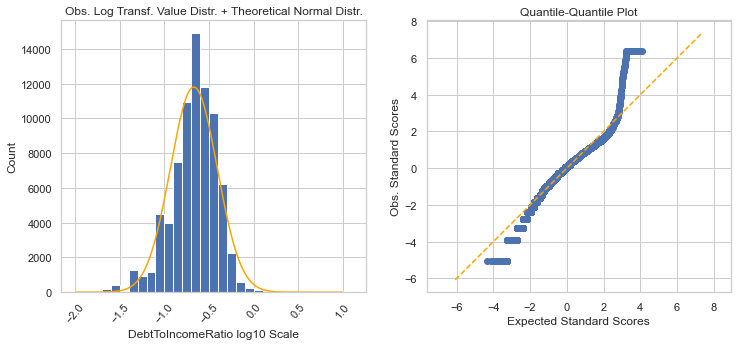

In [105]:
log_d2ir = np.log10(df[df.DebtToIncomeRatio.notnull() & df.DebtToIncomeRatio > 0]['DebtToIncomeRatio'])
metric_distri_qq2(log_d2ir, [12,5], 0.1, 0.0)

`Comment`: The Q-Q Plot and the standard test isn't perfect but the log10 scale plot looks definitely more normal than the original scale.

In [106]:
#How many are 0
df.query('DebtToIncomeRatio == 0')['ListingNumber'].count()

6

In [107]:
# ok we eliminate them 
df = df.query('DebtToIncomeRatio > 0')

In [108]:
# Let's store the log 
df['DebtToIncomeRatio_ln'] = np.log10(df['DebtToIncomeRatio'])
df['DebtToIncomeRatio_ln'].describe()

count    77551.000000
mean        -0.670481
std          0.262030
min         -2.000000
25%         -0.823909
50%         -0.657577
75%         -0.494850
max          1.000434
Name: DebtToIncomeRatio_ln, dtype: float64

### IncomeRange
The income range of the borrower at the time the listing was created.

In [109]:
df.IncomeRange.value_counts()

$50,000-74,999    24030
$25,000-49,999    22023
$100,000+         14013
$75,000-99,999    13644
$1-24,999          3840
Not employed          1
Name: IncomeRange, dtype: int64

`Comment`: I think it could be better to look after the organic distribution of the income the borrowers have at hand at the time of the 
listing creation. let's have a look on StatedMonthlyIncome.

### StatedMonthlyIncome
The monthly income the borrower stated at the time the listing was created.

In [110]:
df.StatedMonthlyIncome.describe().apply(lambda x: format(x, '.2f'))

count     77551.00
mean       5940.30
std        4000.82
min           0.25
25%        3533.33
50%        5000.00
75%        7166.67
max      158333.33
Name: StatedMonthlyIncome, dtype: object

In [111]:
df[df.StatedMonthlyIncome == 0]['ListingNumber'].count()

0

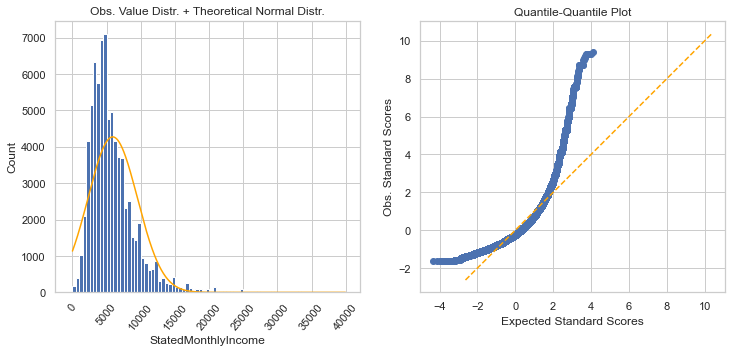

In [112]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.query('StatedMonthlyIncome > 0 & StatedMonthlyIncome <= 40000' )['StatedMonthlyIncome'], [12,5],  500, 5000)

`Comment`: I could can only produce a meaningful plot by filtering below 40k. The data is exremly right skewed and definitely on the original sclae not normal distributed. 

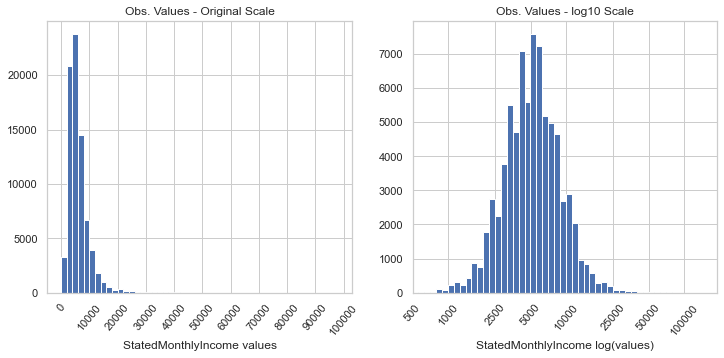

In [113]:
# ok let's do a scale log transformation
metric_distri_log(data = df.query('StatedMonthlyIncome > 0 & StatedMonthlyIncome <= 100000' )['StatedMonthlyIncome'],
                  figsize = [12, 5],
                  bin_size_n = 2000,
                  tick_size_n = 10000,
                  bin_size_l = 0.05,
                  tick_locs = [500, 1000, 2500, 5000, 10000, 25000, 50000, 100000 ],
                  initial = False)

In [114]:
1750002.916667
df.query('StatedMonthlyIncome > 20000' )['StatedMonthlyIncome'].count()

793

`Comment`: A few outliers are pretty much moving the shape to the right. 943 "Monthly Incomes" are higher than 20000$.

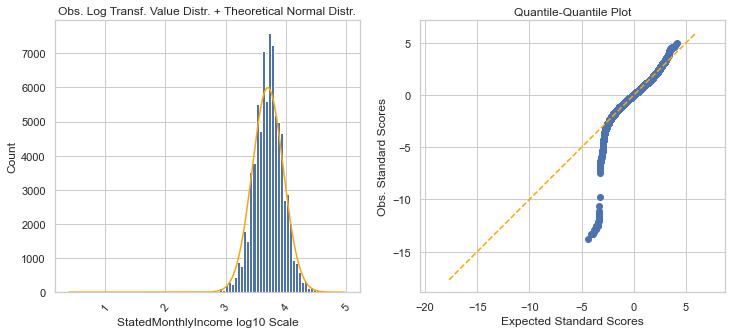

In [115]:
log_d2ir = np.log10(df.query('StatedMonthlyIncome > 0 & StatedMonthlyIncome <= 100000' )['StatedMonthlyIncome'])
metric_distri_qq2(log_d2ir, [12,5], 0.05, 1)

`Comment`: The Q-Q Plot is not really underlining the normality. However the log transformed plot is really much more following a "bell-shape" then the original scale. Let's check as well closer in the up-coming analysis.

In [116]:
#How many are 0
df.query('StatedMonthlyIncome == 0')['ListingNumber'].count()

0

In [117]:
# Let's store the log 
df['StatedMonthlyIncome_ln'] = np.log10(df['StatedMonthlyIncome'])
df['StatedMonthlyIncome_ln'].describe()

count    77551.000000
mean         3.702245
std          0.257954
min         -0.602060
25%          3.548185
50%          3.698970
75%          3.855317
max          5.199572
Name: StatedMonthlyIncome_ln, dtype: float64

### MonthlyLoanPayment

In [118]:
df.MonthlyLoanPayment.describe()

count    77551.000000
mean       295.766419
std        189.328517
min          0.000000
25%        158.490000
50%        256.390000
75%        392.280000
max       2251.510000
Name: MonthlyLoanPayment, dtype: float64

In [119]:
df.MonthlyLoanPayment.isna().sum()

0

In [120]:
df.MonthlyLoanPayment[df.MonthlyLoanPayment <= 10].count()

454

In [121]:
df[df.MonthlyLoanPayment == 0]['ListingNumber'].count()

443

In [122]:
df[df.MonthlyLoanPayment < 10]['LoanStatus'].value_counts()

Completed                 432
Defaulted                  18
FinalPaymentInProgress      4
Name: LoanStatus, dtype: int64

In [123]:
df[df.LoanStatus.isin(['Completed', 'Defaulted','FinalPaymentInProgress'])]['ListingNumber'].count()

18774

`Comment`: There are some values here which are extremely low below 10$ and they spread to different categories like completed etc. However out of thise categories the proportion of 0 is very low.

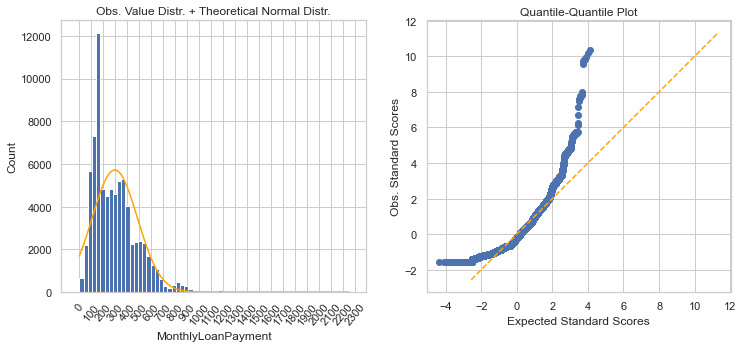

In [124]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.MonthlyLoanPayment, [12,5],  35, 100)

`Comment`: Not looking normal on the original scale. Outliers are in the bins of <font color='red'>100 and 200</font> 

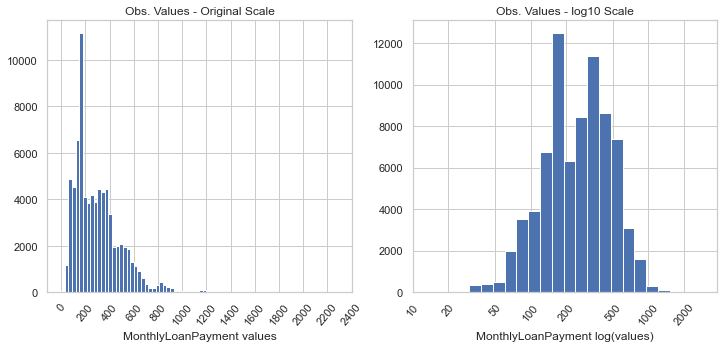

In [125]:
# ok let's do a scale log transformation
metric_distri_log(data = df.MonthlyLoanPayment[df.MonthlyLoanPayment > 0],
                  figsize = [12, 5],
                  bin_size_n = 30,
                  tick_size_n = 200,
                  bin_size_l = 0.1,
                  tick_locs = [10, 20, 50, 100, 200, 500, 1000, 2000],
                  initial = False)

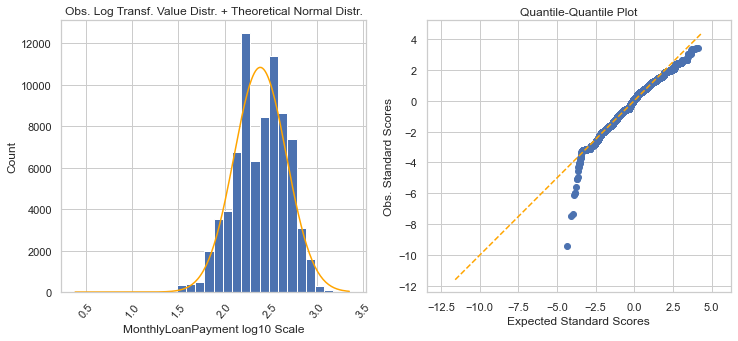

In [126]:
log_data = np.log10(df.MonthlyLoanPayment[df.MonthlyLoanPayment > 0])
metric_distri_qq2(log_data, [12,5], 0.1, 1)

`Comment`: The log transformation seems to describe the values pretty well. 

In [127]:
df.query('MonthlyLoanPayment == 0')['PercentFunded'].mean()

0.9993555304740406

Normally we could look how to fill the loan payments, bu as it is small number we can get rid it.

In [128]:
df = df.query('MonthlyLoanPayment > 0')

In [129]:
df['MonthlyLoanPayment_ln'] = np.log10(df['MonthlyLoanPayment'])
df['MonthlyLoanPayment_ln'].describe()

count    77108.000000
mean         2.387007
std          0.284090
min         -0.619789
25%          2.203495
50%          2.411670
75%          2.594183
max          3.352474
Name: MonthlyLoanPayment_ln, dtype: float64

### LoanOriginalAmount
The origination amount of the loan.

In [130]:
df.LoanOriginalAmount.describe()

count    77108.000000
mean      9300.966683
std       6398.995358
min       1000.000000
25%       4000.000000
50%       8000.000000
75%      14584.500000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

In [131]:
df.LoanOriginalAmount.isna().sum()

0

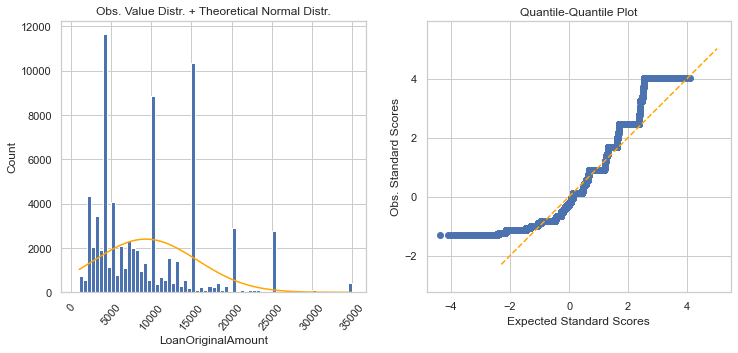

In [132]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.LoanOriginalAmount, [12,5],  500, 5000)

Seems to be not normal....

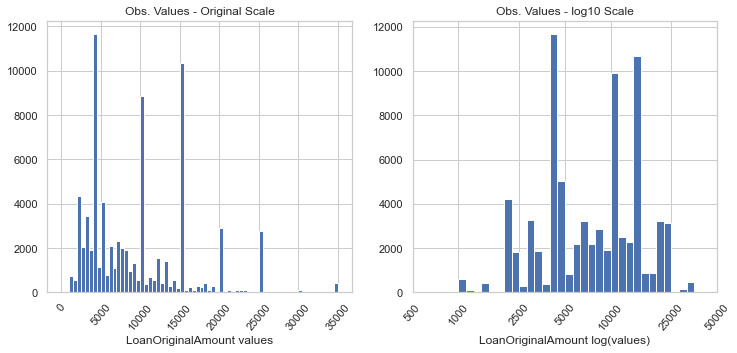

In [133]:
# ok let's do a scale log transformation
metric_distri_log(data = df.LoanOriginalAmount,
                  figsize = [12, 5],
                  bin_size_n = 500,
                  tick_size_n = 5000,
                  bin_size_l = 0.05,
                  tick_locs = [500, 1000, 2500, 5000, 10000, 25000, 50000],
                  initial = False)

Looks a bit better however still not the ideal bell curve or close to it.

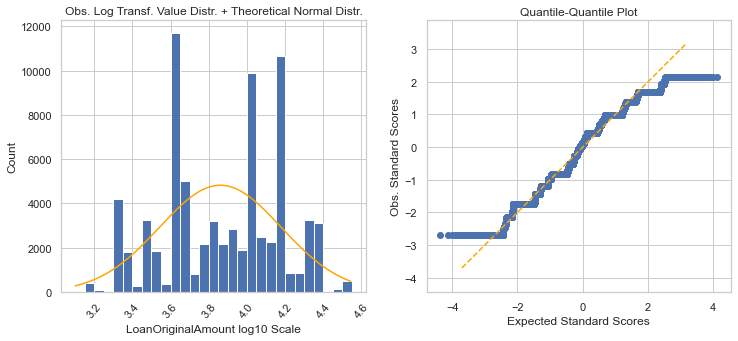

In [134]:
log_data = np.log10(df.LoanOriginalAmount)
metric_distri_qq2(log_data, [12,5], 0.05, 0.1)

`Comment`: Ok, looking better but still not normal. So I decide to work with the original scale.

### PercentFunded 

Percent the listing was funded.

In [135]:
df.PercentFunded.describe()

count    77108.000000
mean         0.998156
std          0.020428
min          0.700000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.012500
Name: PercentFunded, dtype: float64

Nice sometimes more was funded then requested...

In [136]:
df.PercentFunded.isna().sum()

0

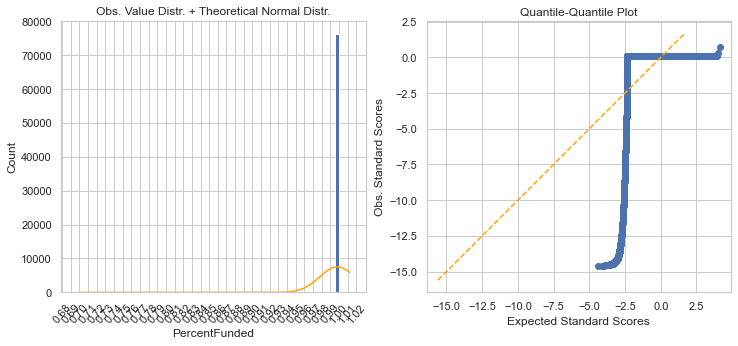

In [137]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.PercentFunded, [12,5],  0.005, 0.01)

`Comment`: Most of the times the full amount was paid out.

### EstimatedReturn
The estimated return assigned to the listing at the time it was created. Estimated return is the difference between the Estimated Effective Yield and the Estimated Loss Rate. Applicable for loans originated after July 2009.


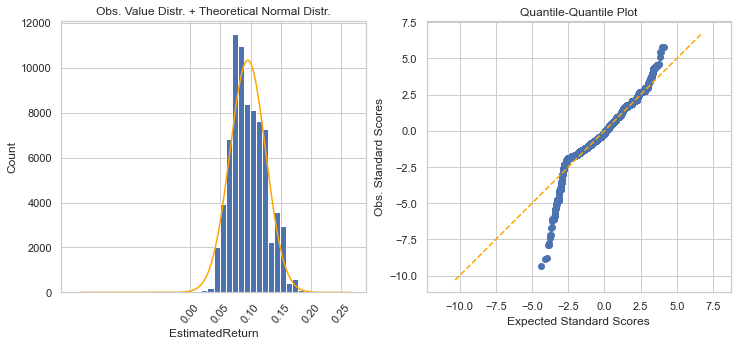

In [138]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.EstimatedReturn, [12,5],  0.01, 0.05)

In [139]:
df.query('EstimatedReturn <= 0')['ListingNumber'].count()

140

`Comment`: ok the Estimated return is sometimes 0 or negative. Apart from that it looks pretty normal. What about the Loss?

### Estimated Loss
LossEstimated loss is the estimated principal loss on charge-offs. Applicable for loans originated after July 2009.


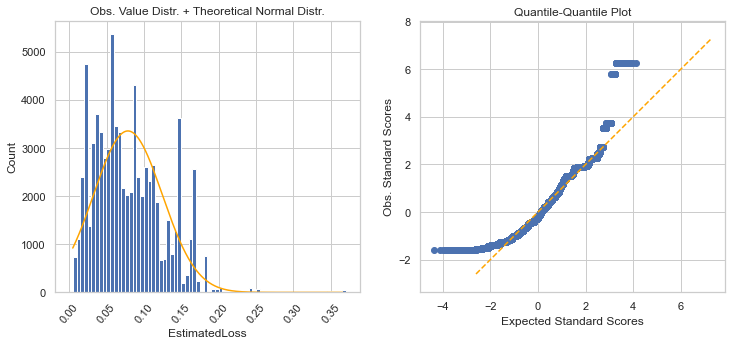

In [140]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is still so useful
metric_distri_qq(df.EstimatedLoss, [12,5],  0.005, 0.05)

`Comment`: ok the Estimated return is sometimes 0 or negative. Apart from that it looks pretty normal. What about the Loss?

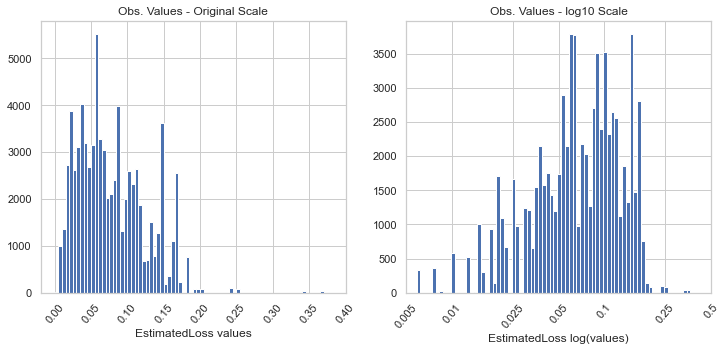

In [141]:
# ok let's do a scale log transformation
metric_distri_log(data = df.EstimatedLoss,
                  figsize = [12, 5],
                  bin_size_n = 0.005,
                  tick_size_n = 0.05,
                  bin_size_l = 0.025,
                  tick_locs = [0.005, 0.01 , 0.025, 0.05, 0.1,0.25, 0.5 ],
                  initial = False)

`Comment`: From right to left skewed. We will look in the further analysis and stay with the original scale.

### Univariate Exploration Summary



* `Cleaning General`:
The following attributes have being excluded: ListingKey, CreditGrade, CurrentlyInGroup, GroupKey, DateCreditPulled, FirstRecordedCreditLine, OpenRevolvingAccounts, OpenRevolvingMonthlyPayment, TotalInquiries, PublicRecordsLast10Years, PublicRecordsLast12Months, TotalTrades, ,TradesNeverDelinquent (percentage), TradesOpenedLast6Months, LoanKey, LoanCurrentDaysDelinquent, LoanFirstDefaultedCycleNumber, LoanMonthsSinceOrigination ,LoanNumber, LoanOriginationQuarter, LP_CustomerPayments, LP_CustomerPrincipalPayments, LP_InterestandFees, LP_ServiceFees, LP_CollectionFees, LP_GrossPrincipalLoss, LP_NetPrincipalLoss, LP_NonPrincipalRecoverypayments.

* `Prosper Rating`:
As we have 25% not populated because the Prosper Rating started after July 2009 I thought maybe a simple rule (or even regression) for the derivation of the Prosper
rating based on the external one would be easy. But it is not as e.g. D is between 680 - 699 and E later down as well. So let's flag them as before_July09
and analyze keeping decide at th end to keep or to get rid of them.


* `BorrowerAPR`: There are a lot of values at the end in the bins of <font color='red'>0,35 - 0,36</font> (btw. which is more than 30%). However looking to the distribution I would say it can be considered as normal distributed.

* `DebtToIncomeRatio`: This isn't looking normal distributed at all. As it's a financial KPI and the original scale is pretty much right skewed, a log scale might better explain the distribution.

* `StatedMonthlyIncome`: The Q-Q Plot is not really underlining the normality. However the log transformed plot is really much more following a "bell-shape" then the original scale.

* `MonthlyLoan Payment`: Here are some values here which are extremely low below 10$ and they spread to different categories like completed etc. However out of those categories the proportion of 0 is very low. The log scale describes the data pretty normal.

* `EstimatedReturn`:The Estimated return is sometimes 0 or negative. Apart from that it looks pretty normal.

* EstimatedLoss: The data looks right-skewed, after the log transform it look left-skewed, so I decide to stay with the original scale.



## Bivariate Exploration

Now move o to the bivariate exploration, first see if there is a any insight in the following attribute comparisons.

In [142]:
# cluster the variabless
numeric_vars = ['BorrowerAPR', 'BorrowerRate', 'DebtToIncomeRatio_ln', 'StatedMonthlyIncome_ln', 'MonthlyLoanPayment_ln', 
                        'LoanOriginalAmount', 'EstimatedLoss', 'EstimatedReturn']

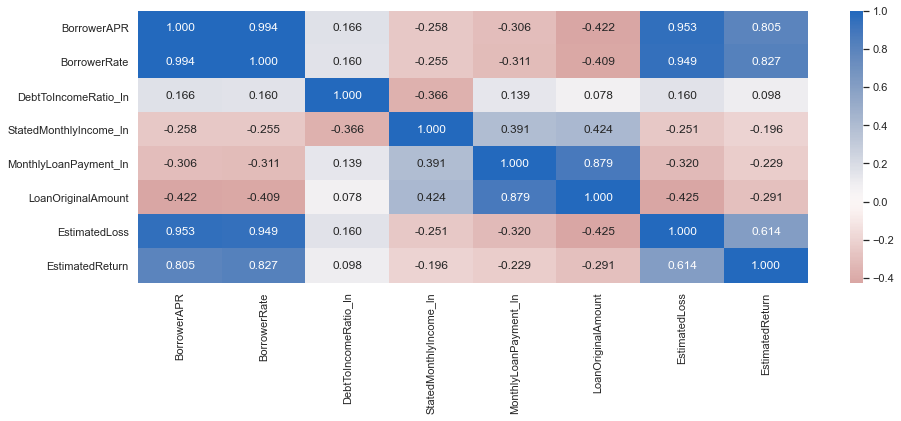

In [143]:
plt.figure(figsize = [15, 5])
# correlation plot
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0);

In [144]:
# plot matrix: sample 7000 (appr. 10%) so that plots are clearer and they render faster
samples = np.random.choice(df.shape[0], 7000, replace = False)
pairplot_samp = df.iloc[samples,:]

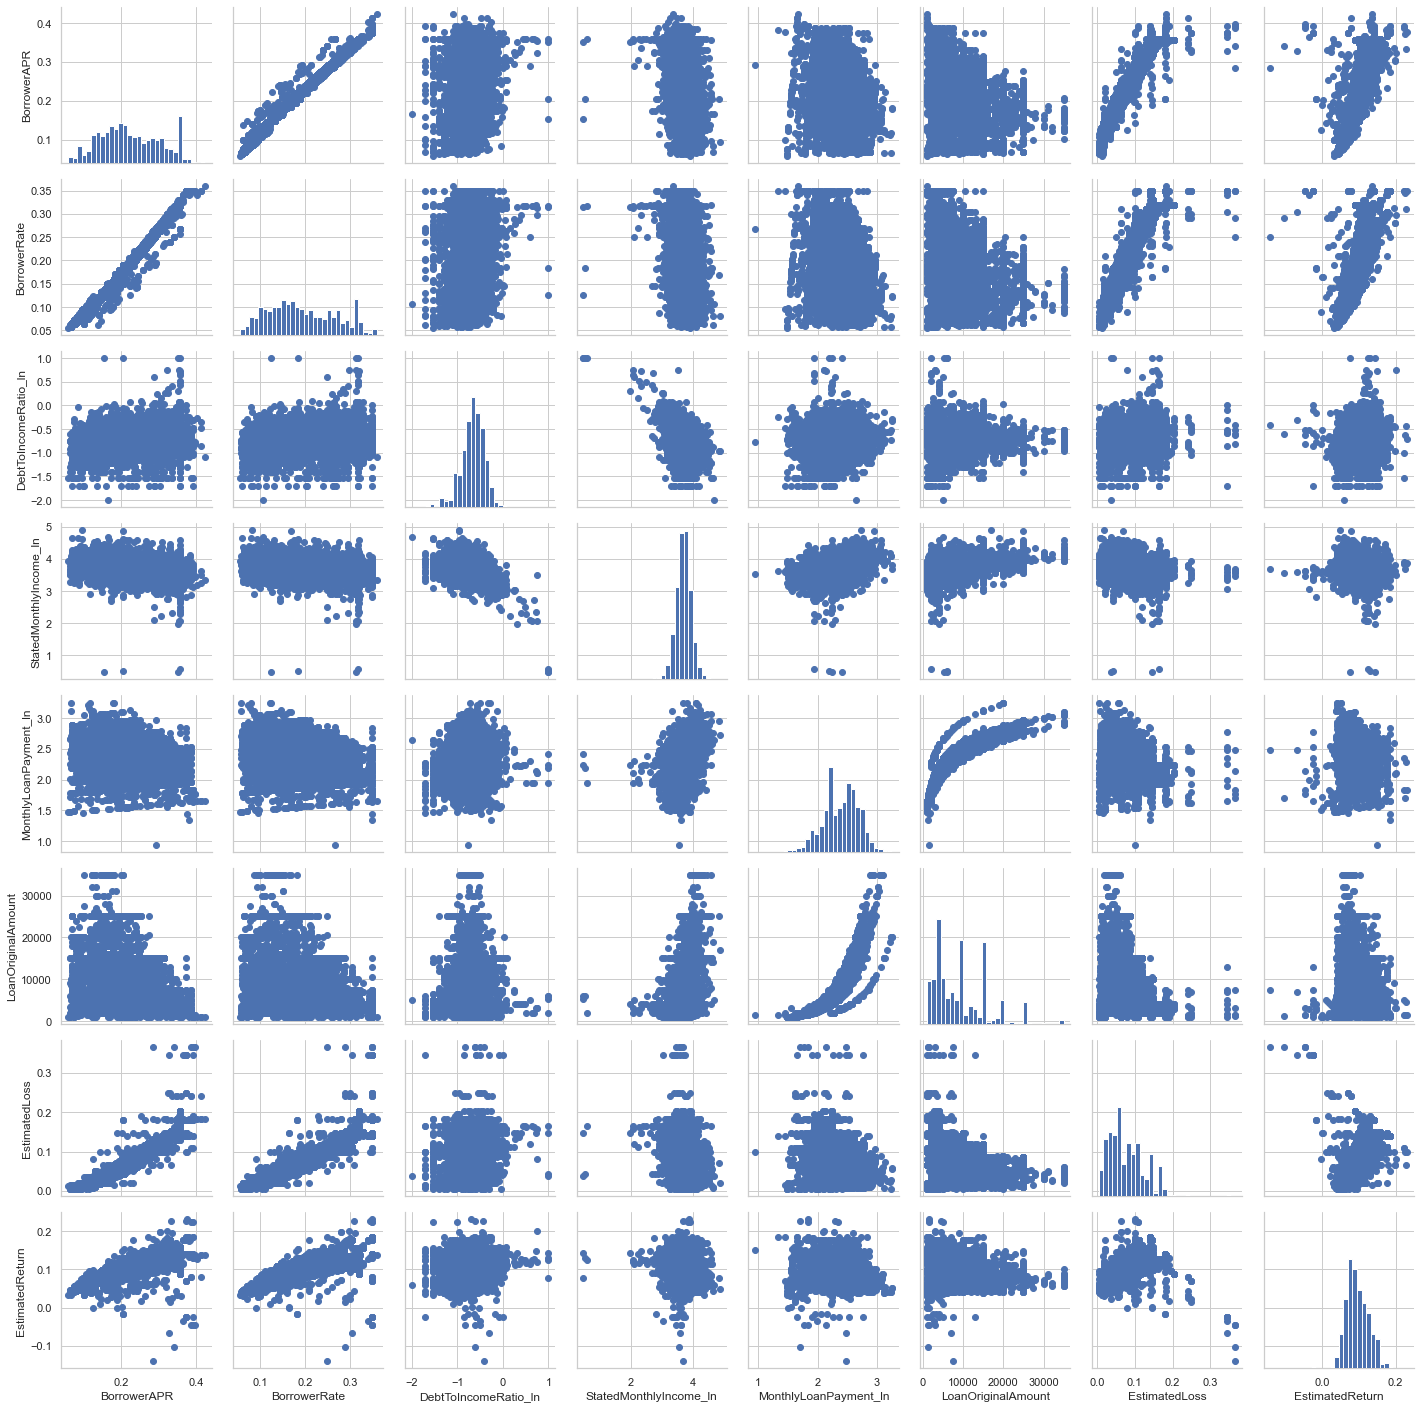

In [145]:
# Pairplot of the variables interested....
g = sb.PairGrid(data = pairplot_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 30);
g.map_offdiag(plt.scatter);

Ok, the correlation matrix and the pairplot show some good candidates for continous comparison. I continue based on th equestion I formulated.

### Who is using Prosper?
Analyse who is using prosper, which occupation, which state in combination. 

#### Occupation vs. State
Which Occupations coming from which state?

Occupation BorrowerState
Denominator: 77108


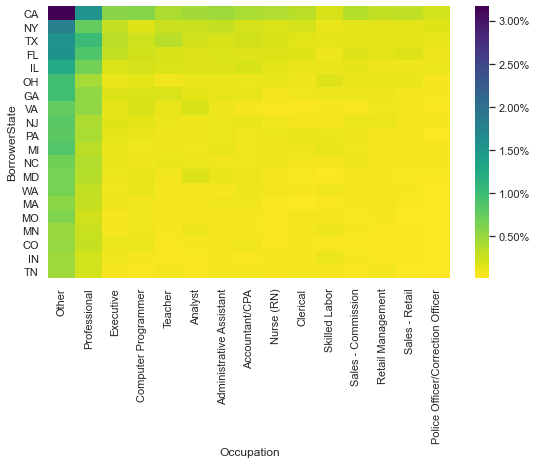

In [146]:
categorial_2d(data=df, x='Occupation',y='BorrowerState',zoom_x=15,zoom_y=20,fig_size=[9,5], percent=True, annotate=False )

`Comment`: As expected, the pivot of state and occupation shows that e.g. that the group "Others" and "Professionals" comimng from California (CA) are the most frequent. We have more computer programmers in California then other states. 
Let's look if there is an intersting insight for lenders owing a house. Do they own houses?

#### State vs. Homeowner 
Are there states with more homeowners in the Prosper Community?

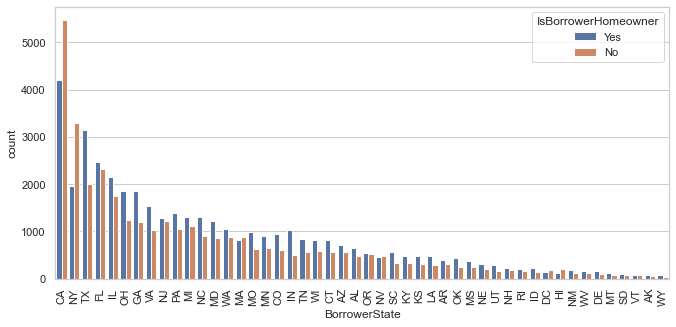

In [147]:
plt.figure(figsize = [11, 5])
# plot and assign a axis 
ax = sb.countplot(data = df, x = 'BorrowerState', hue = 'IsBorrowerHomeowner',
             order=df['BorrowerState'].value_counts().index);
plt.xticks(rotation=90);

`Comment`: The Homeowner counts in Californa(CA) are much lesser than eg. Texas. In Florida is nearly even. The smaller the overall Prosper utilization gets the bigger the count of the homeowners get (with a few exceptions).
I'm not an US expert but comparing e.g. California and NY with WA as example is also comparing Metroplitan areas vs. counteyside. Which occupation do Homeowners have?

#### Occupation vs. Homeowner
Are there occupation groups having more houses?

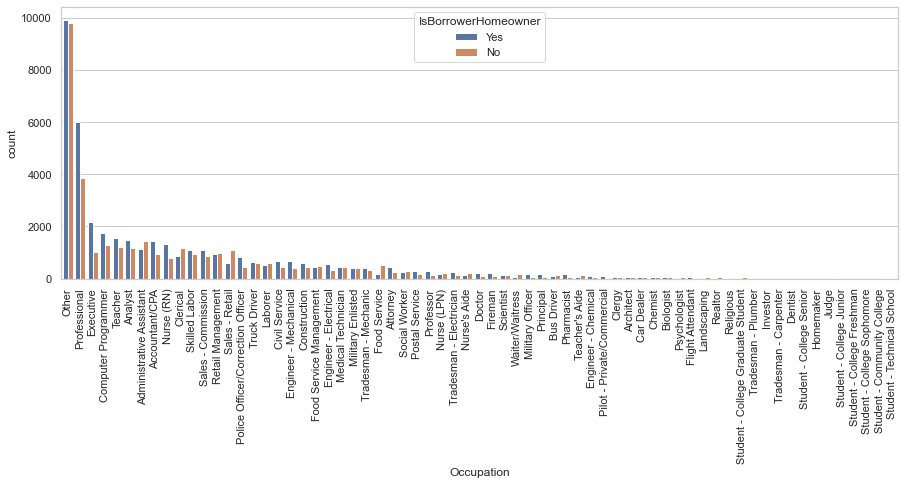

In [148]:
plt.figure(figsize = [15, 5])
# plot and assign a axis 
ax = sb.countplot(data = df, x = 'Occupation', hue = 'IsBorrowerHomeowner',
             order=df['Occupation'].value_counts().index);
plt.xticks(rotation=90);

In [149]:
# Zoom to the top 20 

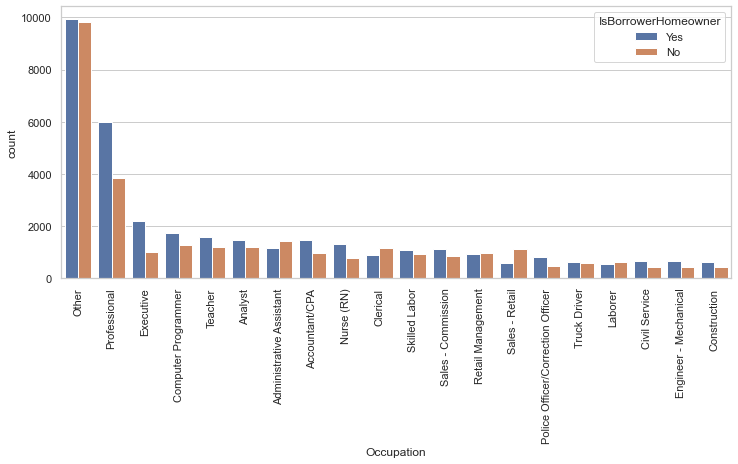

In [150]:
plt.figure(figsize = [12, 5])
# plot and assign a axis 
ax = sb.countplot(data = df, x = 'Occupation', hue = 'IsBorrowerHomeowner',
             order=df['Occupation'].value_counts().index[0:20]);
plt.xticks(rotation=90);

`Comment`: Group "Others" have less "Homeowners" than e.g. than "Professionals" the 2nd largest group. Executives tend to have more real estate property as well. Overall we know that the split of Homeowners and Non-Homeowners is nearly even. Which Employement Status do the different occupations have?

#### EmploymentStatus vs. Occupation
Which Occupations have which Employment Status?

Occupation EmploymentStatus
Denominator: 77108


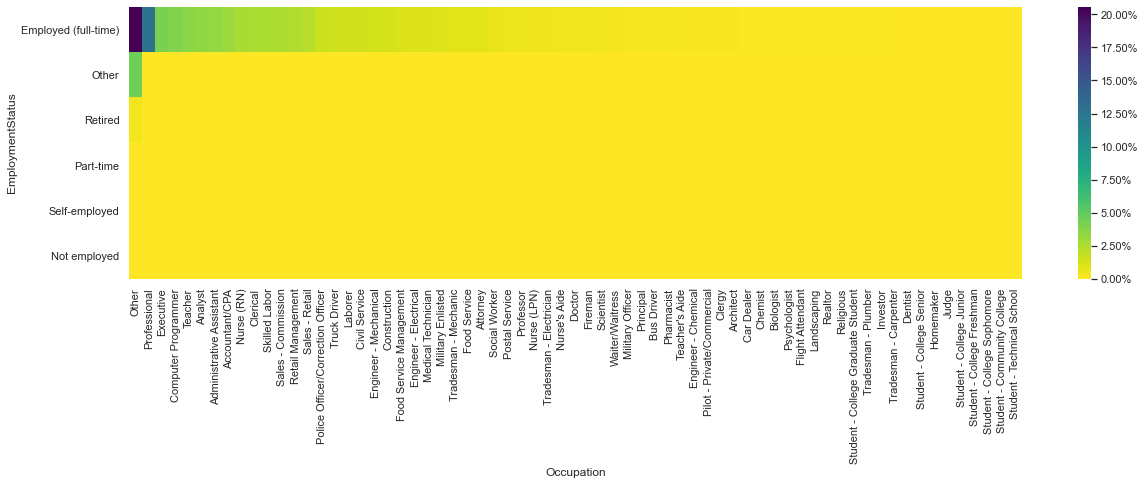

In [151]:
categorial_2d(data=df, x='Occupation',y='EmploymentStatus',zoom_x=0,zoom_y=0,fig_size=[20,5], percent=True, annotate=False )

`Comment`: Biggest group "Others" has most of them as "Employed". The following groups "Professional", "Comp. Progr.", "Executive" and  have no (or neglectable) count of not employed or retired. Even part-time proportion is very low. So bottomline the Prosper Community sees to be Full-time employed.

There might be a relationship between state and listing type?

#### Listing Type vs. State

ListingCategory_alpha BorrowerState
Denominator: 77108


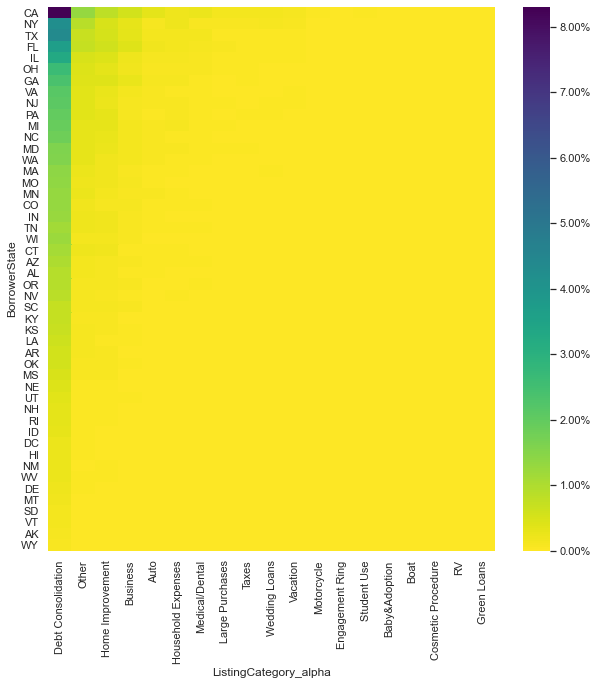

In [152]:
categorial_2d(data=df, x='ListingCategory_alpha',y='BorrowerState',zoom_x=0,zoom_y=0,fig_size=[10,10], percent=True, annotate=False )

`Comment`: Nothing special here, California and Debt Consolidation collects most of the counts. Debt consolidation seems to be leading:
Do we have occupation categories doing a particular type of loan?

#### Occupation vs. Listing Type

Are there proffessions doing a particular ListingCategory more often?

ListingCategory_alpha Occupation
Denominator: 77108


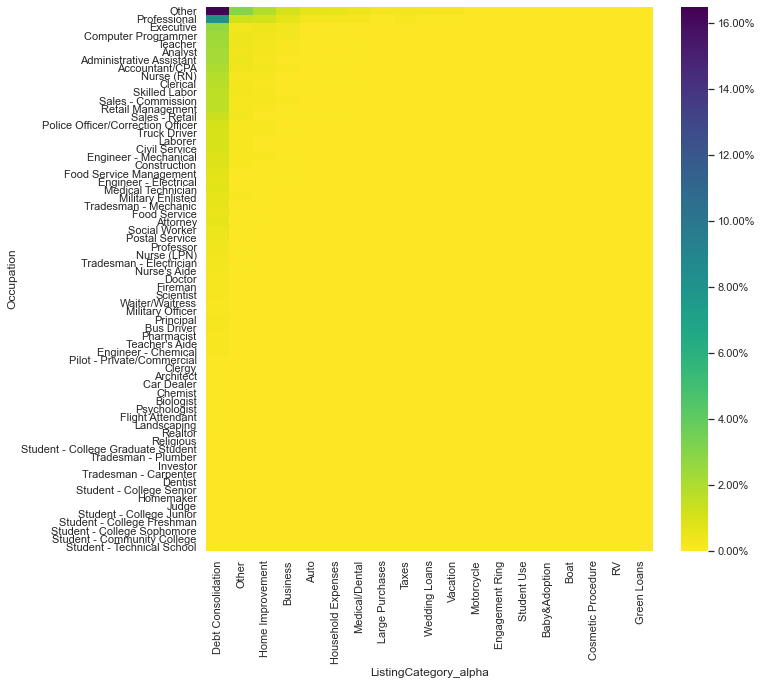

In [153]:
categorial_2d(data=df, x='ListingCategory_alpha',y='Occupation',zoom_x=0,zoom_y=0,fig_size=[10,10], percent=True, annotate=False)

`Comment`: The Other categories are kind of dominating. Professionals do most Debt Consolidation. Followed by Home Improvement and Business. Not a big inside as we know already that the Consolidtion of loans is the strongest use case. Do homeowners do different things withe the money?

#### Listing Category vs. Homeowner
Are Homeowners more in the Home Improvement Busienss?

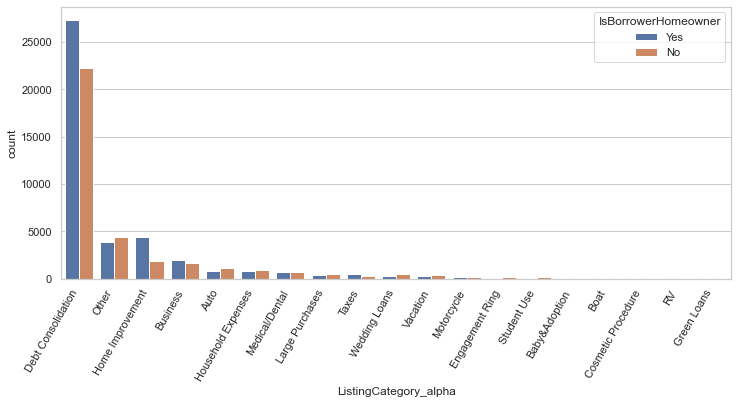

In [154]:
plt.figure(figsize = [12, 5])
# plot and assign a axis 
ax = sb.countplot(data = df, x = 'ListingCategory_alpha', hue = 'IsBorrowerHomeowner',
             order=df['ListingCategory_alpha'].value_counts().index);
plt.xticks(rotation=60, ha='right');

In [155]:
df.groupby(['ListingCategory_alpha', 'IsBorrowerHomeowner']).size()/len(df)*100

ListingCategory_alpha  IsBorrowerHomeowner
Auto                   Yes                     1.084194
                       No                      1.505680
Baby&Adoption          Yes                     0.130985
                       No                      0.116719
Boat                   Yes                     0.047985
                       No                      0.058360
Business               Yes                     2.582093
                       No                      2.120403
Cosmetic Procedure     Yes                     0.042797
                       No                      0.060953
Debt Consolidation     Yes                    35.454168
                       No                     28.783006
Engagement Ring        Yes                     0.071329
                       No                      0.188048
Green Loans            Yes                     0.029828
                       No                      0.028531
Home Improvement       Yes                     5.747782
     

`Comment`: Debt Consolidation is highest for Homeowner as well. Surprisingly Home Improvement is done by non-Homeowner as well (appr. 2,5%). 
Ok, by now not too much intersting insights let's explore further some quantitative attributes.

How much money do the different occupations have at hand?

#### Occupation vs. Monthly Income

In [156]:
df.StatedMonthlyIncome_ln.describe()

count    77108.000000
mean         3.702410
std          0.257981
min         -0.602060
25%          3.549192
50%          3.698970
75%          3.855317
max          5.199572
Name: StatedMonthlyIncome_ln, dtype: float64

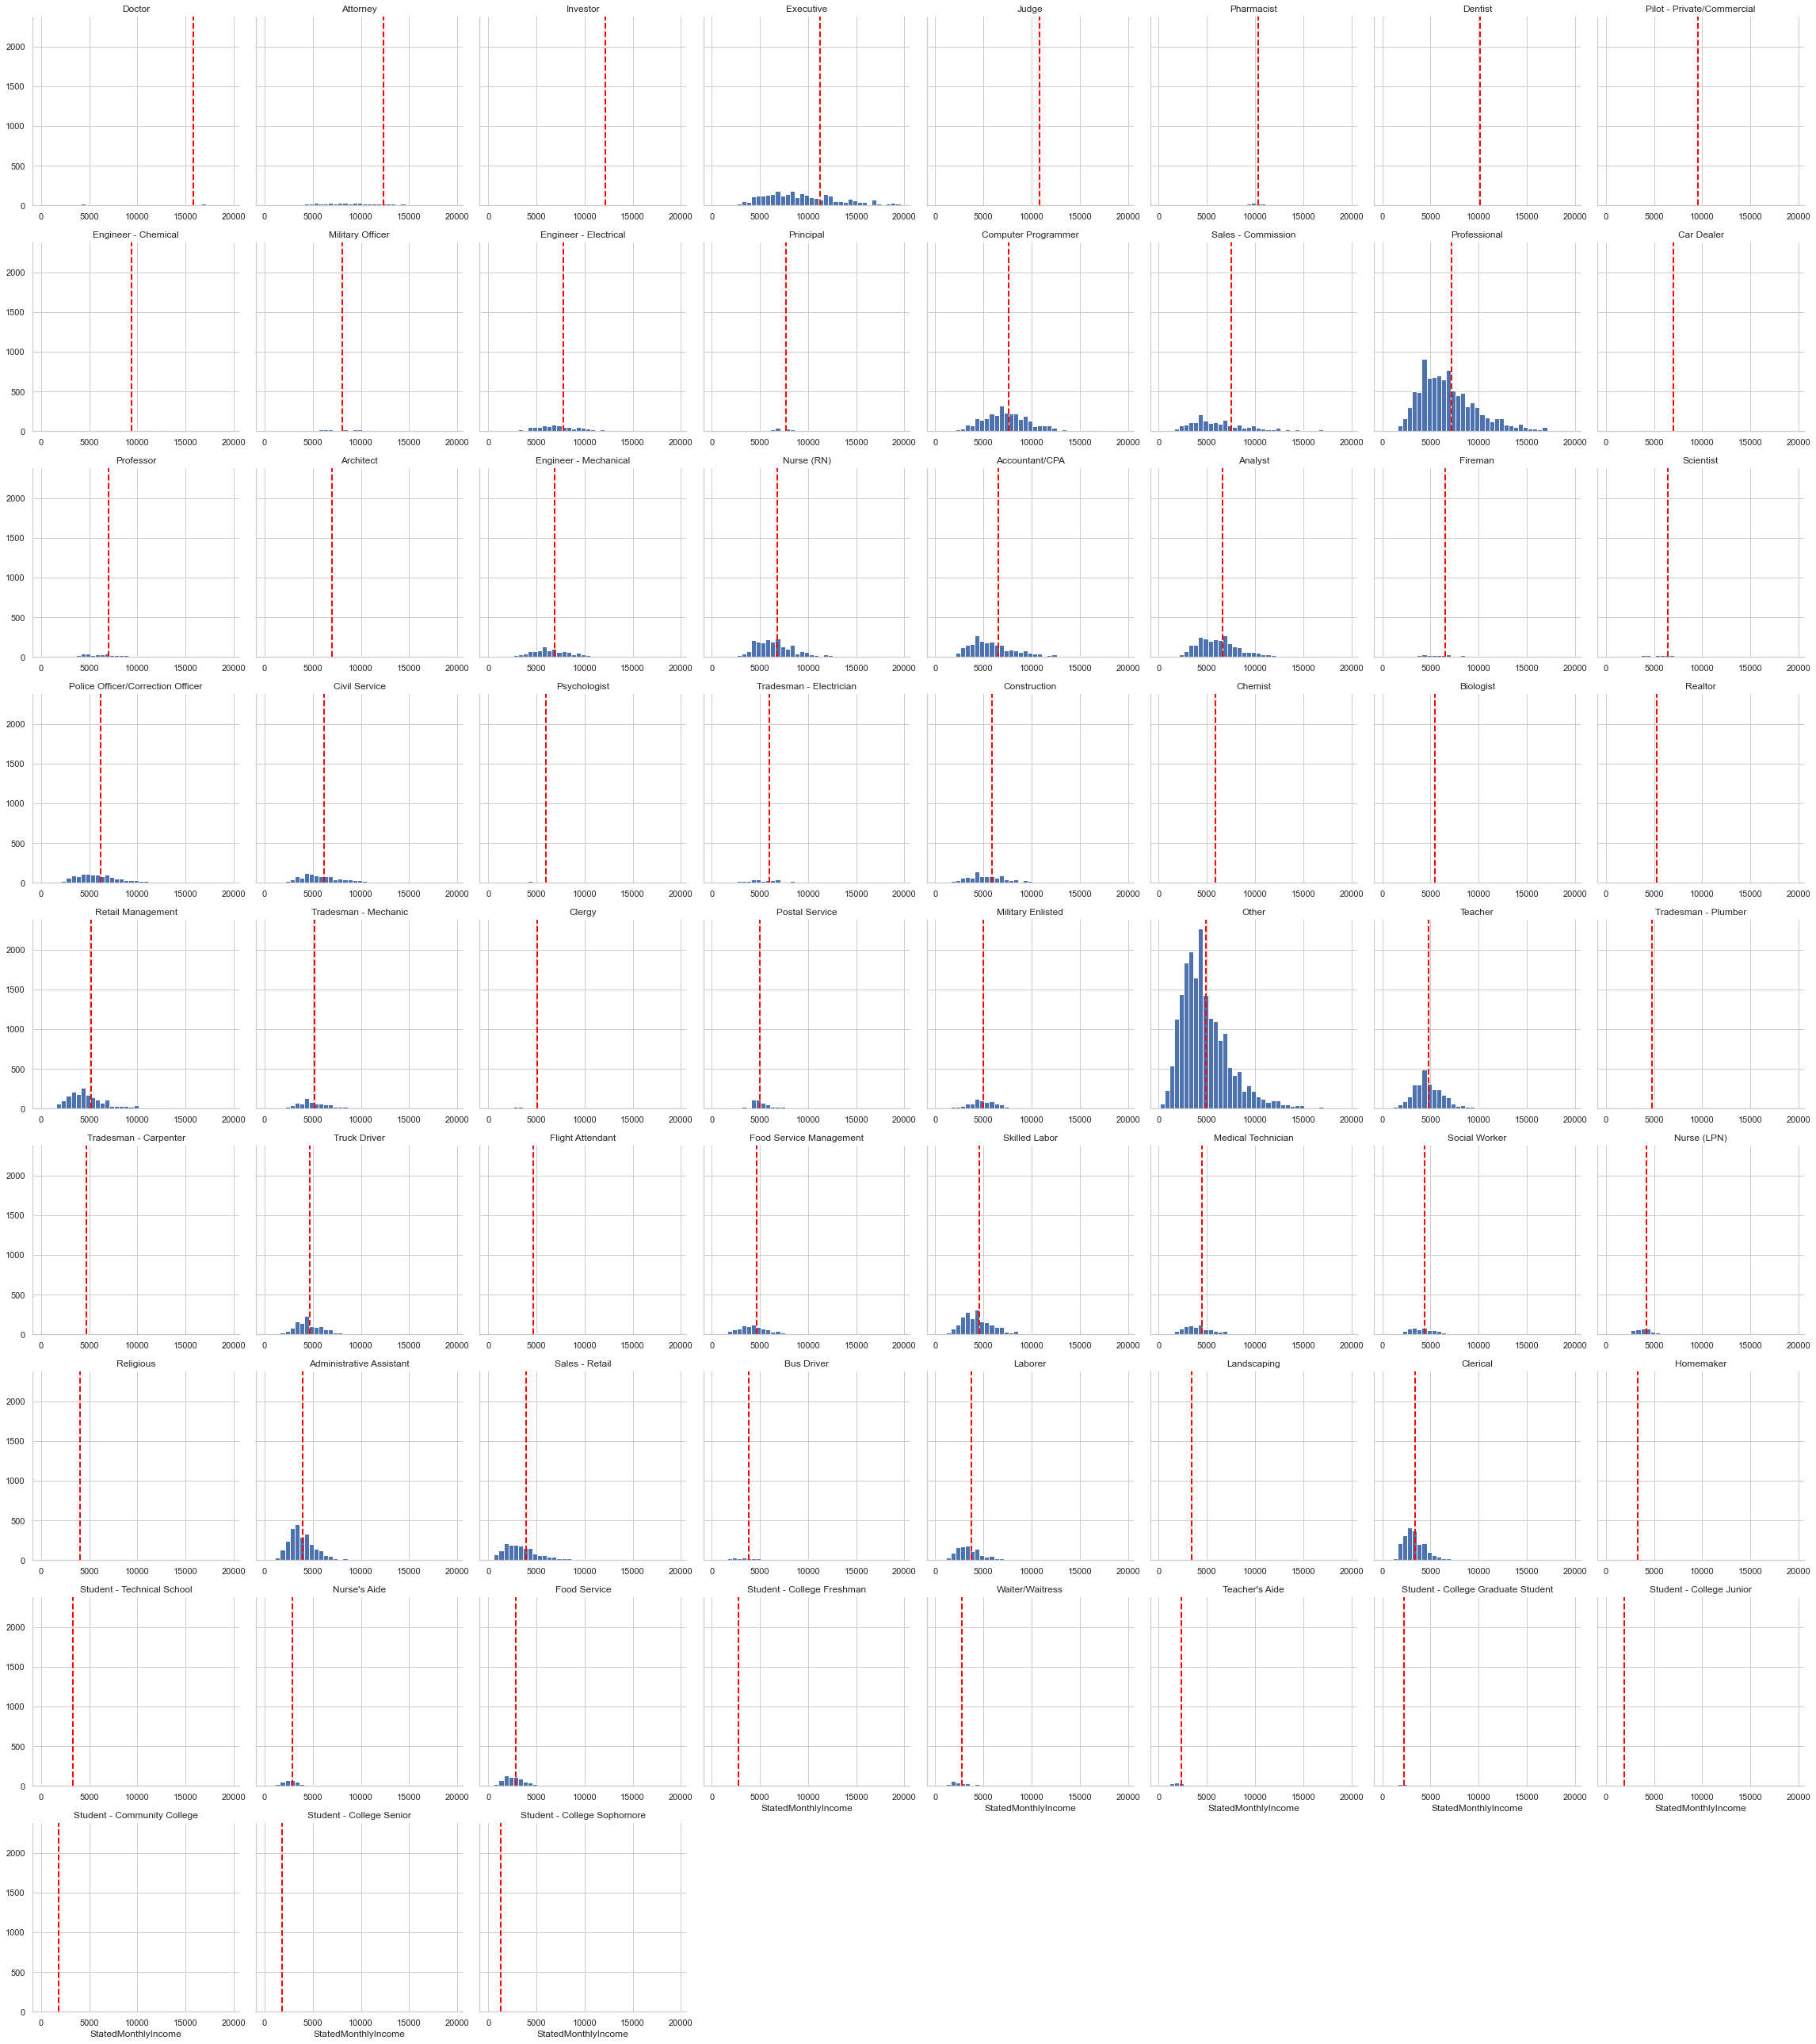

In [157]:
# create the means 
occ_montly_income = df.groupby(['Occupation']).mean()
occ_montly_income_order = occ_montly_income.sort_values(['StatedMonthlyIncome'], ascending = False).index

# plot the vertical mean 
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)

def mean_as_text(col):
    print(col)
    a = str(occ_montly_income.query('Occupation == @col')['StatedMonthlyIncome'].mean())
    print(col + a)
    return a

# create the facet plot
g = sb.FacetGrid(data = df, col = 'Occupation', col_wrap = 8, size = 4, sharex=False,col_order = occ_montly_income_order);
g.map(plt.hist, 'StatedMonthlyIncome', bins = np.arange(100, 20000, 500));
g.map(vertical_mean_line, 'StatedMonthlyIncome');
g.set_titles('{col_name}');

`Comment`: The histograms above are ordered by descending by the sum of avaibale incomme in that group.Interestingly the mean income (red line) has a different order. Let's look to that.

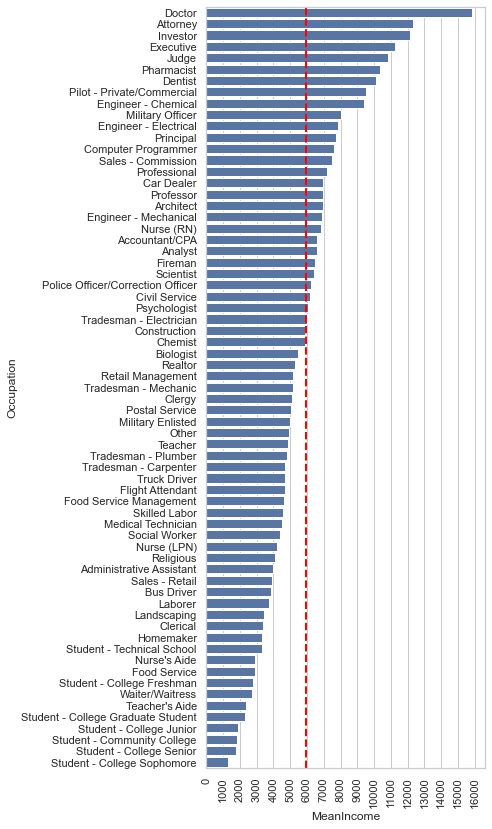

In [158]:
# make a bar chart vertical with a overall mean of the income
occ_mi_mean = df.groupby('Occupation')['StatedMonthlyIncome'].mean().reset_index(name = 'MeanIncome')
occ_mi_mean.MeanIncome = occ_mi_mean.MeanIncome.astype(float)
plt.figure(figsize = [5, 14])
sb.barplot(y="Occupation", x="MeanIncome", data=occ_mi_mean, color=base_color, order=occ_mi_mean.sort_values(['MeanIncome'], ascending = False)['Occupation']) ;
plt.xticks(rotation=90);
plt.xticks(np.arange(0,occ_mi_mean.MeanIncome.max()+1000,1000))
plt.axvline(df.StatedMonthlyIncome.mean(), color='red', linestyle='dashed', linewidth=2);

`Comment`: Ok, doctors have the most available income ...

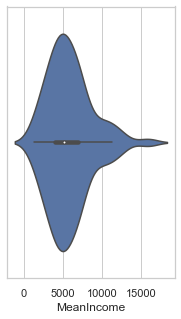

In [159]:
plt.figure(figsize = [3, 5])
sb.violinplot(data = occ_mi_mean, x = 'MeanIncome', color = base_color);

`Comment`: However Professionals, Computer Programmers and the very large group Others are still above the average income.

Let's see how the overall debt situation is looking like..

#### Occupation vs. DebtToIncomeRatio

Let's neglect the outlier for the momnet and have a look to the values up to the 3rd quantile.

In [160]:
df.DebtToIncomeRatio.describe()

count    77108.000000
mean         0.259043
std          0.318858
min          0.010000
25%          0.150000
50%          0.220000
75%          0.320000
max         10.010000
Name: DebtToIncomeRatio, dtype: float64

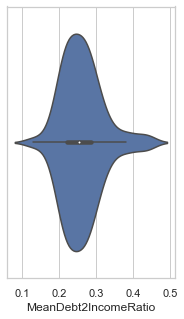

In [161]:
occ_d2ir_mean = df.groupby('Occupation')['DebtToIncomeRatio'].mean().reset_index(name = 'MeanDebt2IncomeRatio')
occ_d2ir_mean.MeanDebt2IncomeRatio = occ_d2ir_mean.MeanDebt2IncomeRatio.astype(float)
plt.figure(figsize = [3, 5])
sb.violinplot(data = occ_d2ir_mean, x = 'MeanDebt2IncomeRatio', color = base_color);

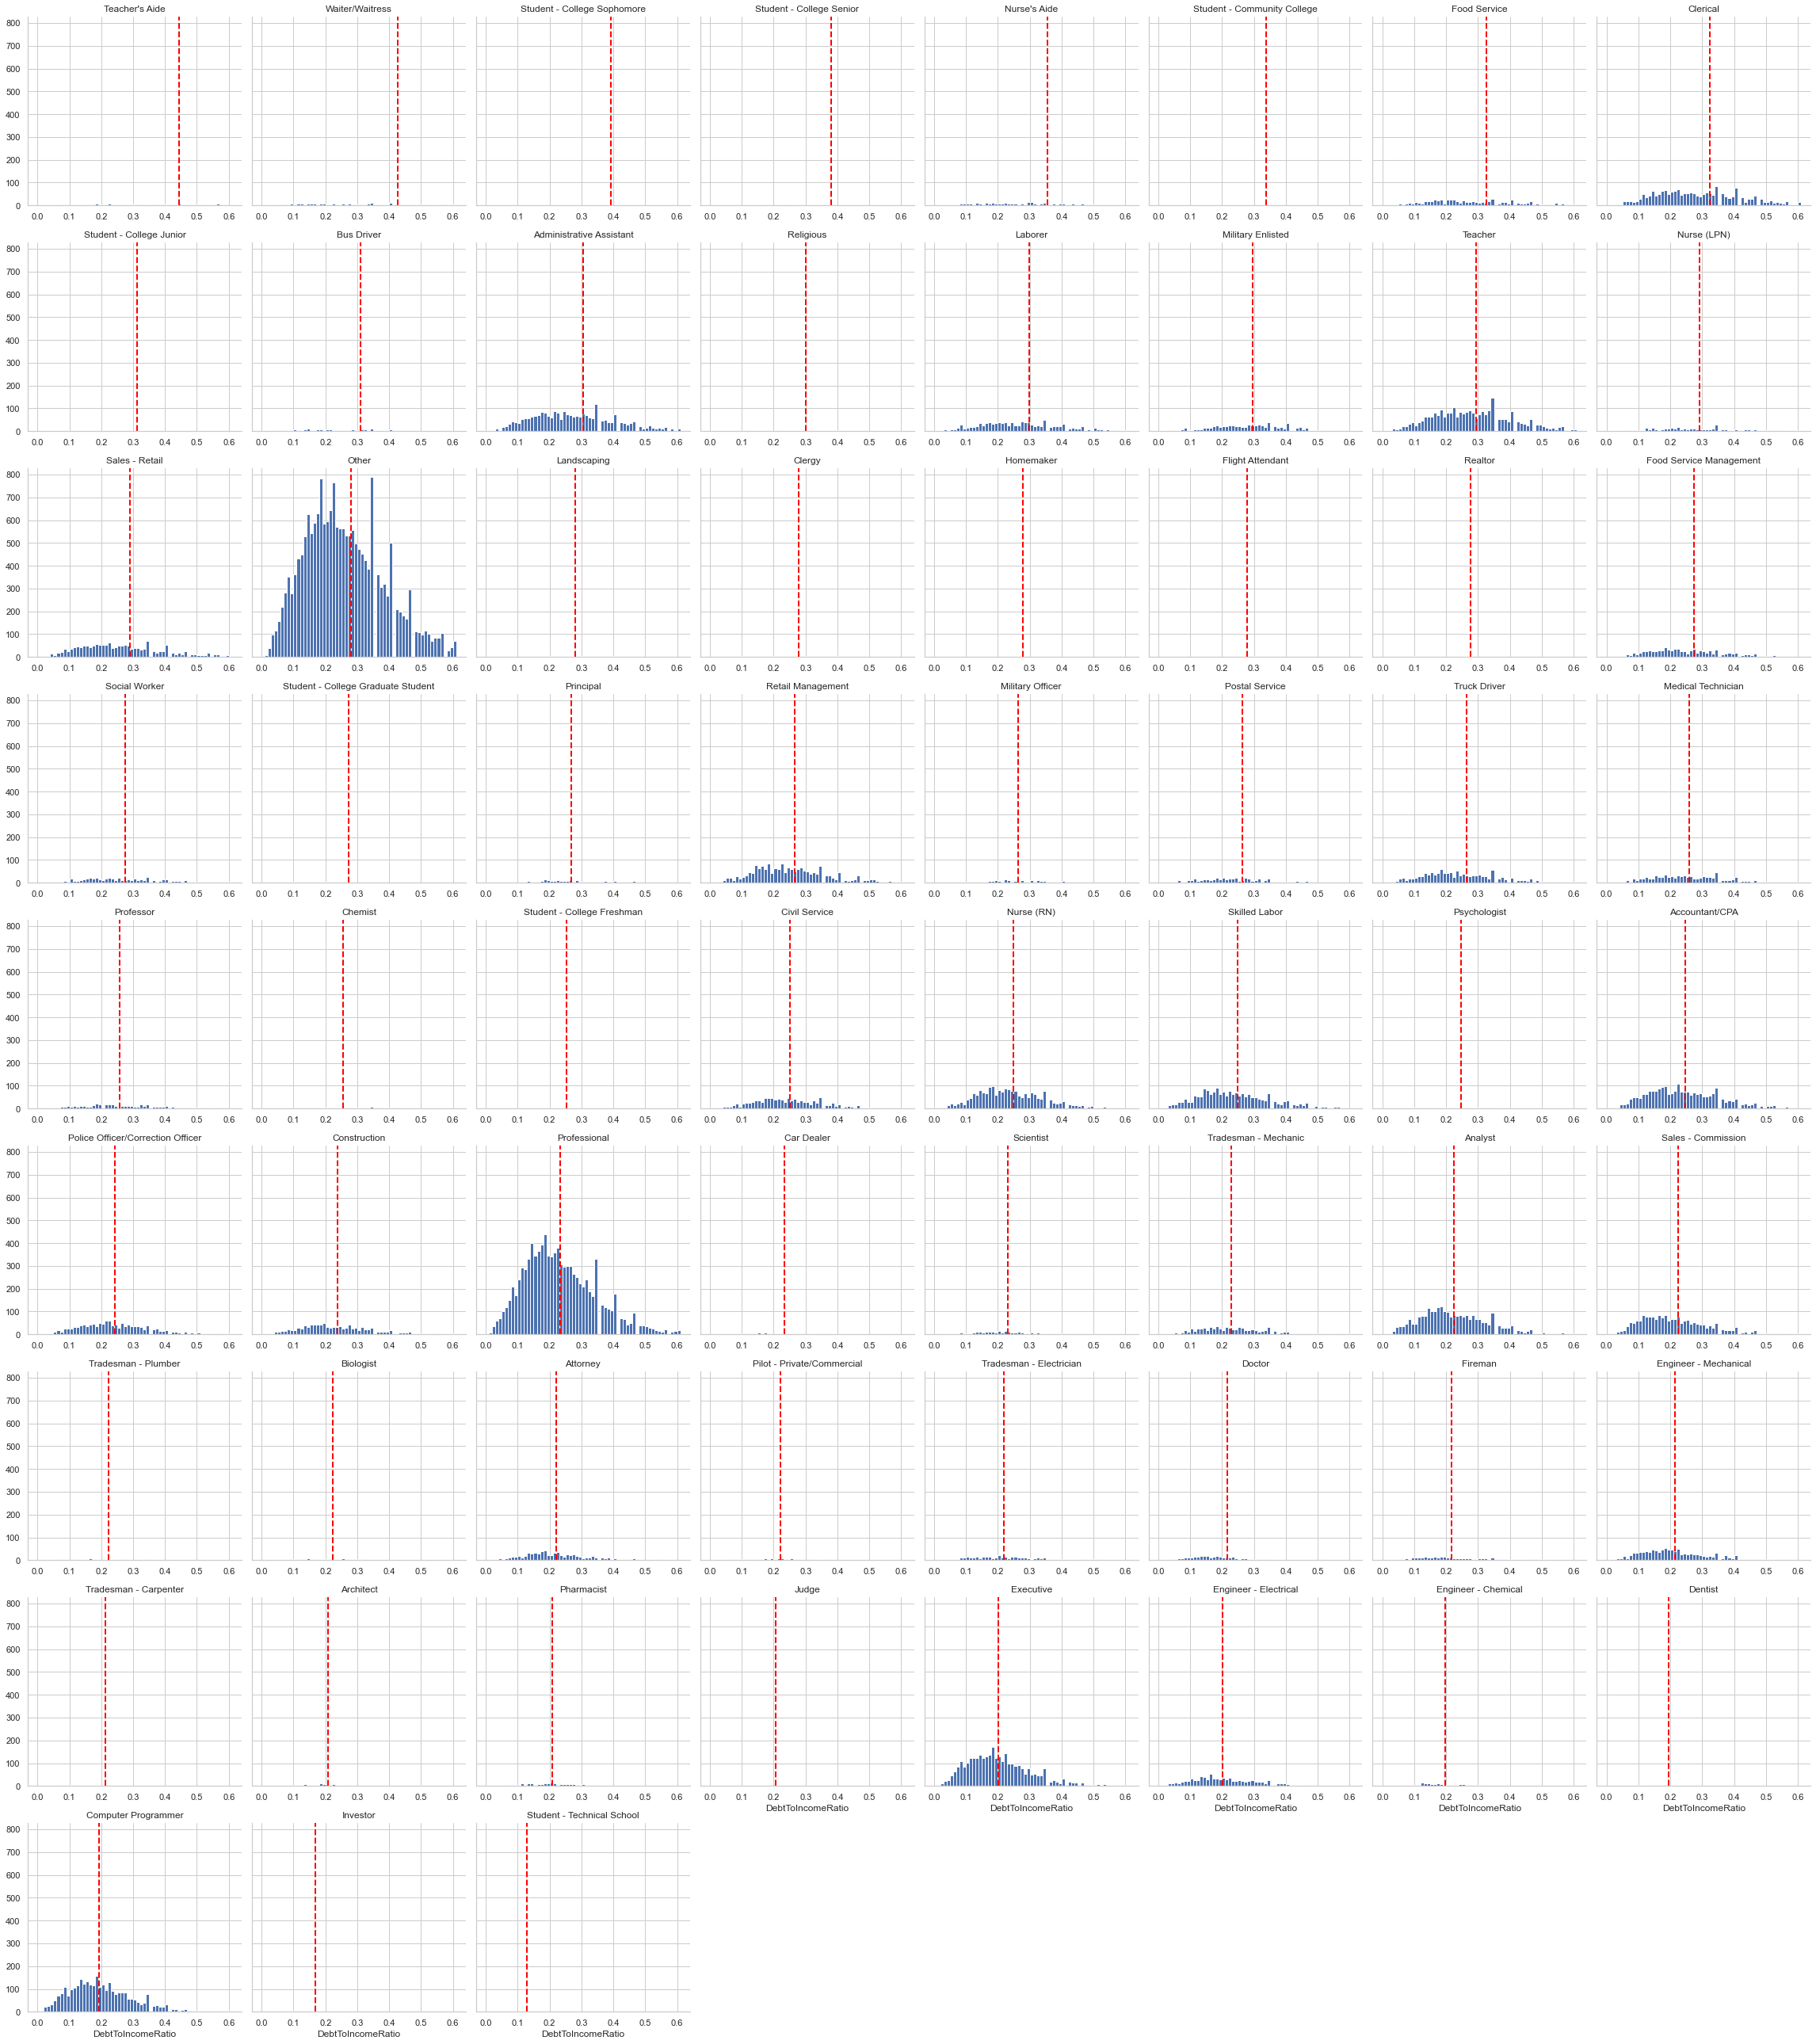

In [162]:
# let's get the mean DebtToIncomeRatio
occ_d2ir = df.groupby(['Occupation']).mean()
occ_d2ir = occ_d2ir.sort_values(['DebtToIncomeRatio'], ascending = False).index

# plot the vertical mean 
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)

# create the plot
g = sb.FacetGrid(data = df, col = 'Occupation', col_wrap = 8, size = 4, sharex=False,col_order = occ_d2ir);
g.map(plt.hist, 'DebtToIncomeRatio', bins = np.arange(0, df.DebtToIncomeRatio.describe()[6]+0.3, 0.01));
g.map(vertical_mean_line, 'DebtToIncomeRatio');
g.set_titles('{col_name}');

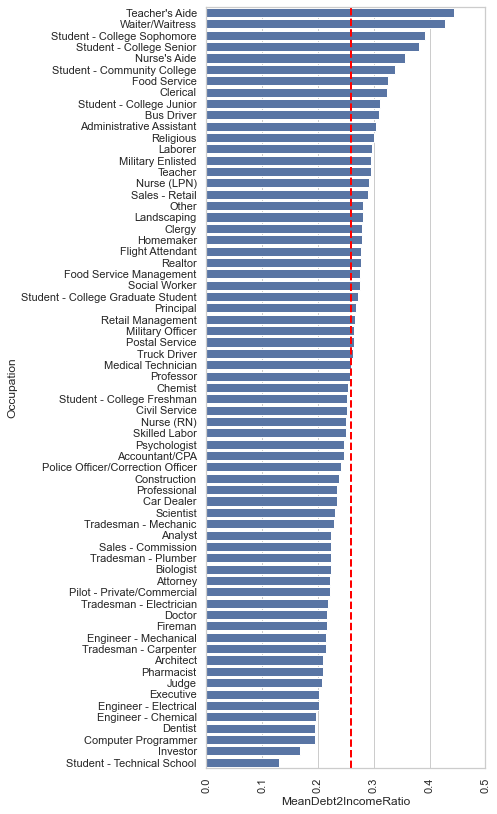

In [163]:
# plot a barchart with overall mean 
plt.figure(figsize = [5, 14])
sb.barplot(y="Occupation", x="MeanDebt2IncomeRatio", data=occ_d2ir_mean, color=base_color, order=occ_d2ir_mean.sort_values(['MeanDebt2IncomeRatio'], ascending = False)['Occupation']) ;
plt.xticks(rotation=90);
plt.xticks(np.arange(0,occ_d2ir_mean.MeanDebt2IncomeRatio.max()+0.1,0.1))
plt.axvline(df.DebtToIncomeRatio.describe()[1], color='red', linestyle='dashed', linewidth=2);

`Comment`: Teachers Aide, Waiters, Students and Fodd Service have the highest ratio. Computer Programmers, Professionals are below the average Ratio, however the large group of Others is slightly above. Whart about the extemes > 0,3

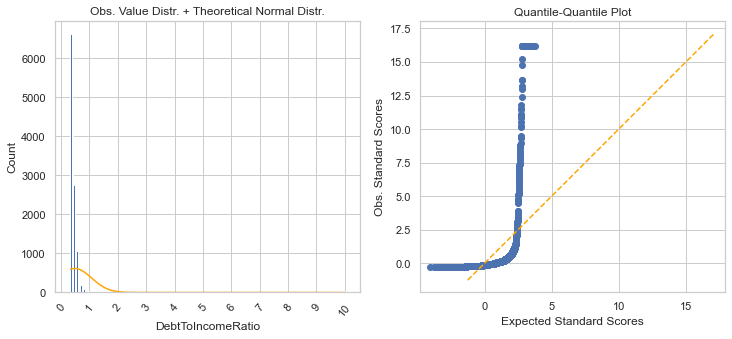

In [164]:
occ_d2ir = df.query('DebtToIncomeRatio > @df.DebtToIncomeRatio.describe()[6]')
metric_distri_qq(occ_d2ir.DebtToIncomeRatio, [12,5],  .05, 1)

In [165]:
df.query('DebtToIncomeRatio > 1')['DebtToIncomeRatio'].count()

320

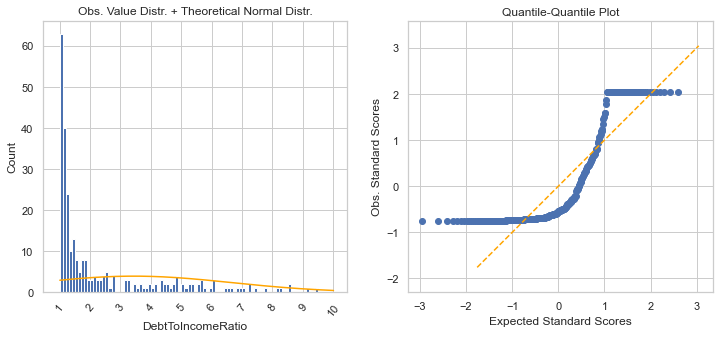

In [166]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is already so useful
metric_distri_qq(df.query('DebtToIncomeRatio > 1')['DebtToIncomeRatio'], [12,5],  .1, 1)

`Comment`:  We have 323 above 1 which means those lenders have earn the same amount of money as they have debts(and evern more). There seems to be a concentration between 1 and 3. I don't consider them as they make only a small propoportion. Let's look to the high ratios.

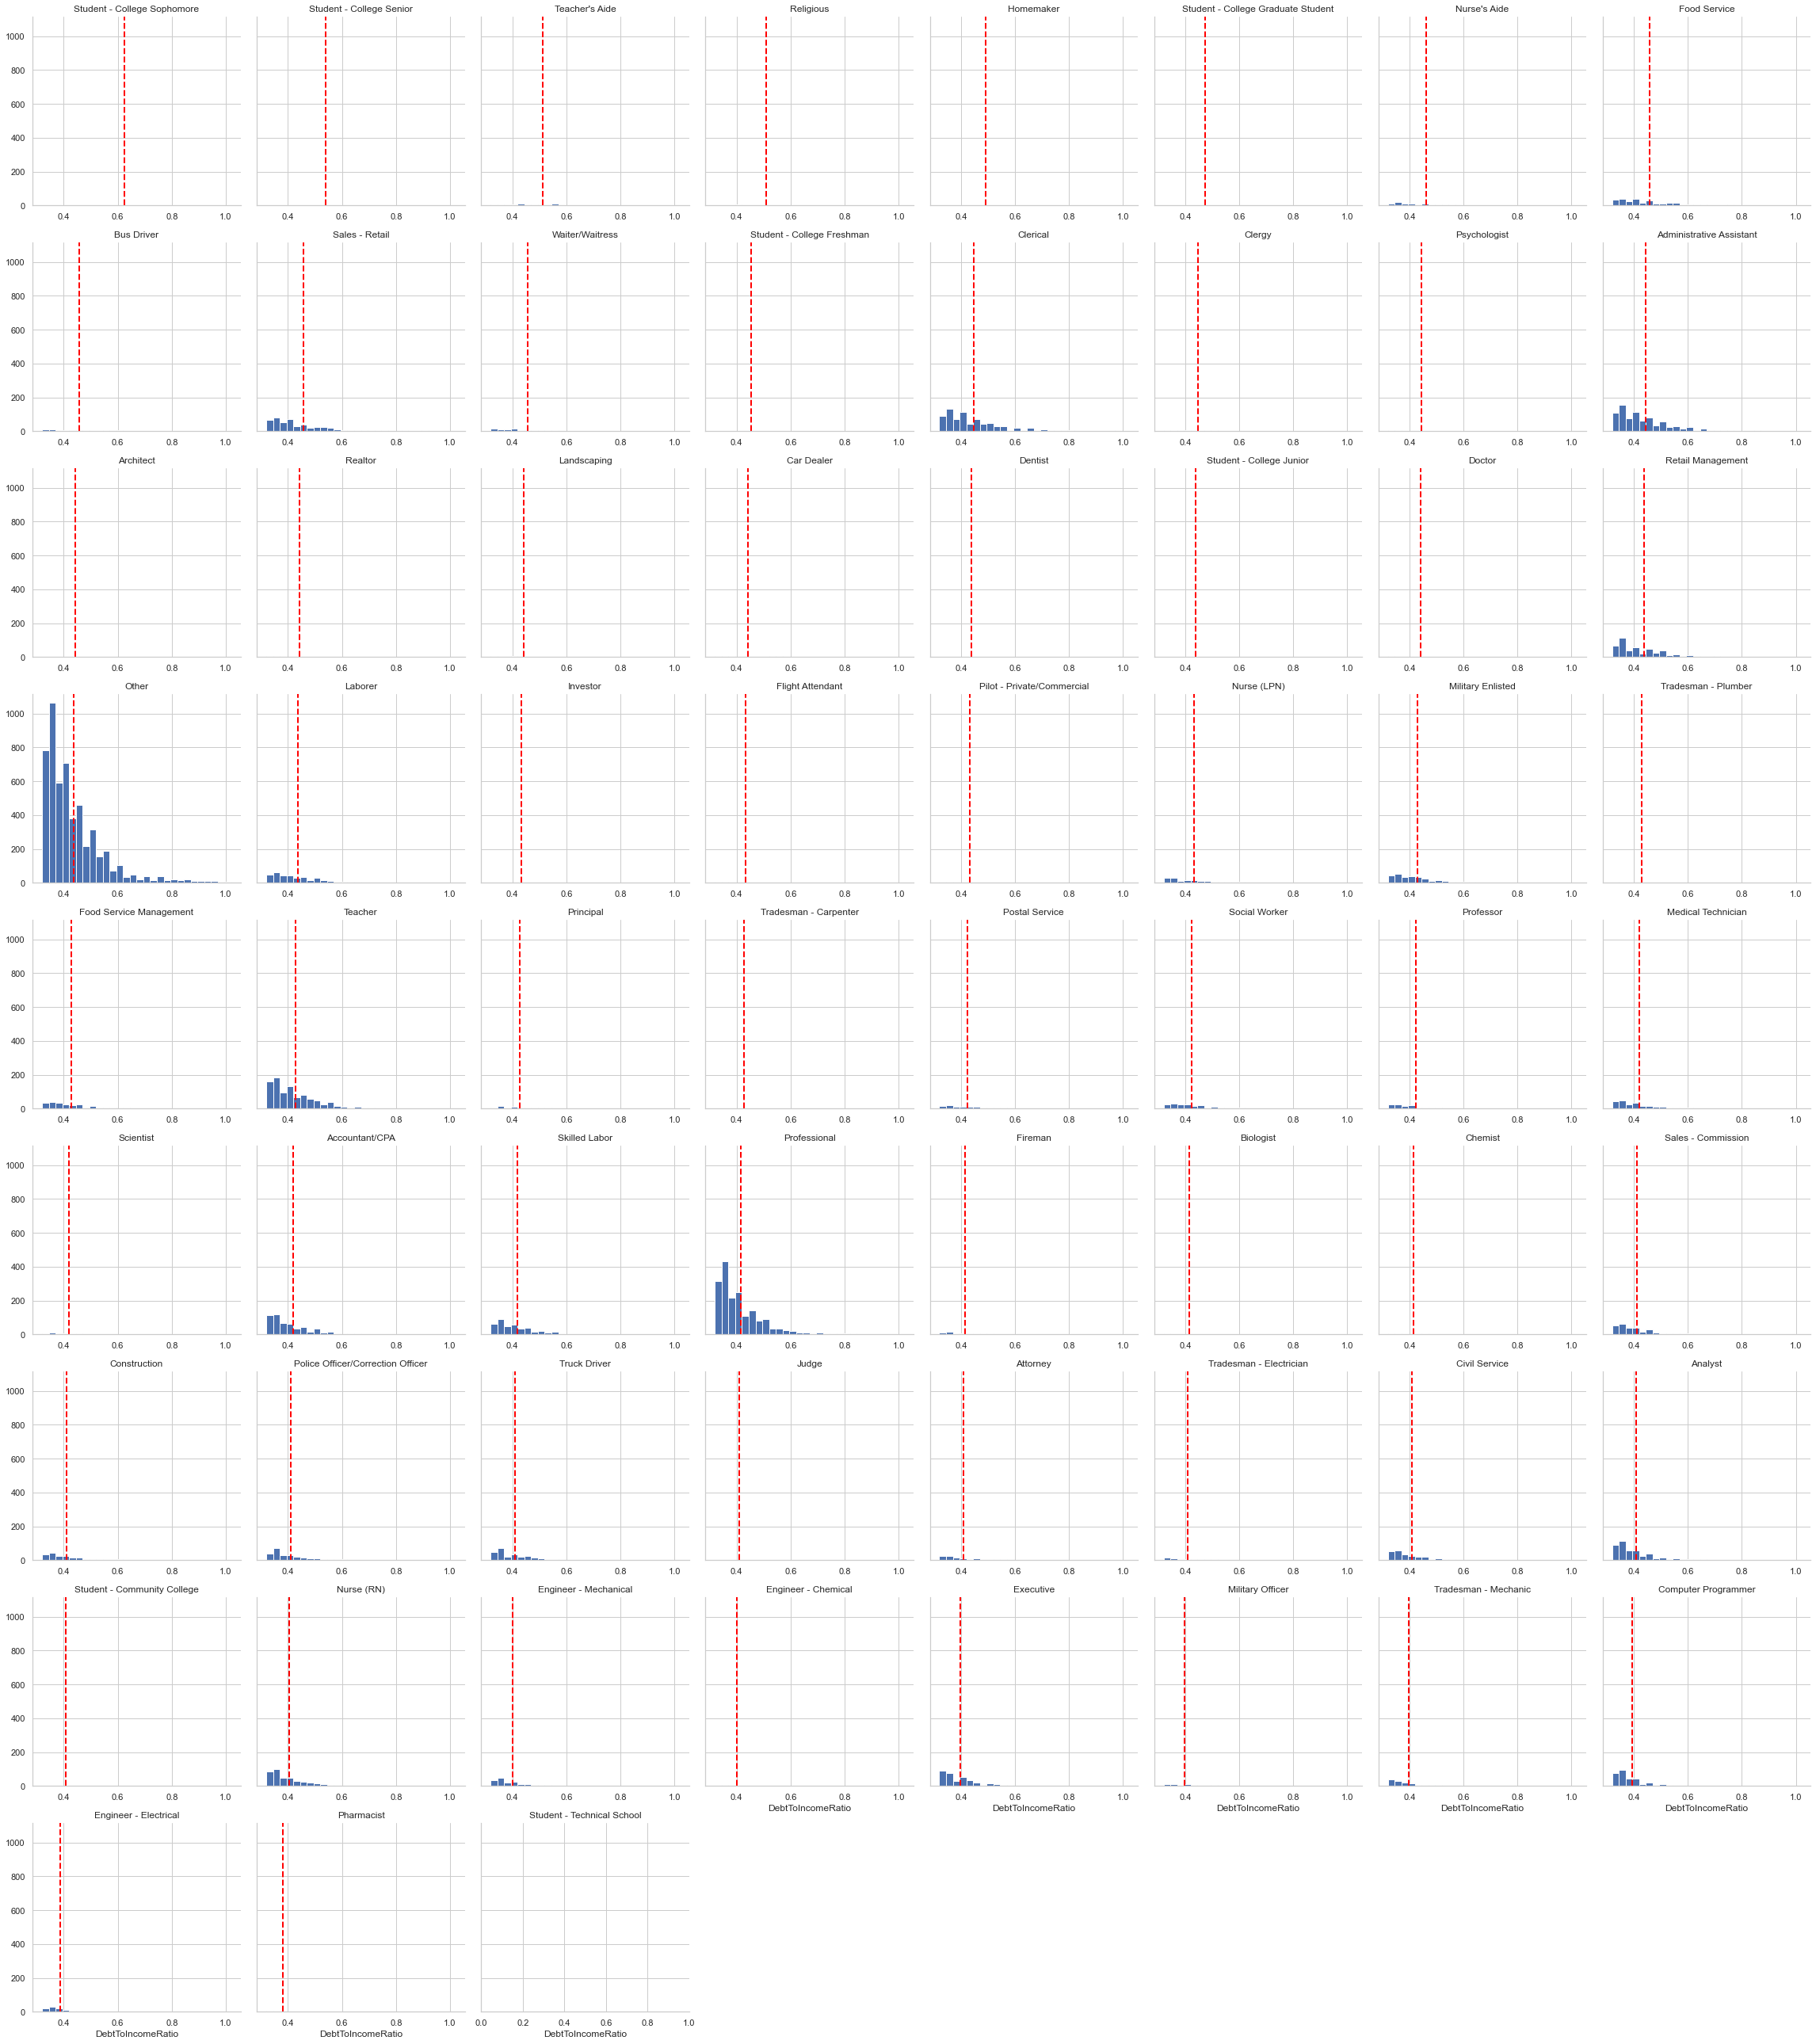

In [167]:
# get the mean of all DebtToIncomeRatio <= 1 
occ_d2ir = df.query('DebtToIncomeRatio > @df.DebtToIncomeRatio.describe()[6] & DebtToIncomeRatio <= 1')
occ_d2ir_sort = occ_d2ir.groupby(['Occupation']).mean()
occ_d2ir_sort = occ_d2ir_sort.sort_values(['DebtToIncomeRatio'], ascending = False).index

# plot the vertical mean 
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)

# create the plot
g = sb.FacetGrid(data = occ_d2ir, col = 'Occupation', col_wrap = 8, size = 4, sharex=False, col_order = occ_d2ir_sort);
g.map(plt.hist, 'DebtToIncomeRatio', bins = np.arange(df.DebtToIncomeRatio.describe()[6], 1+0.025, 0.025))
g.map(vertical_mean_line, 'DebtToIncomeRatio');
g.set_titles('{col_name}');

`Comment`: Food Service, Sales/Retail, Clerical, Teachers as well as Others, Computer Programmers and Professionals have considerable amount of high ratio. How is the score looking for the occupations?

#### Occupations vs. LoanAmount
How much money do they borrow on average?

In [168]:
df.LoanOriginalAmount.describe()

count    77108.000000
mean      9300.966683
std       6398.995358
min       1000.000000
25%       4000.000000
50%       8000.000000
75%      14584.500000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

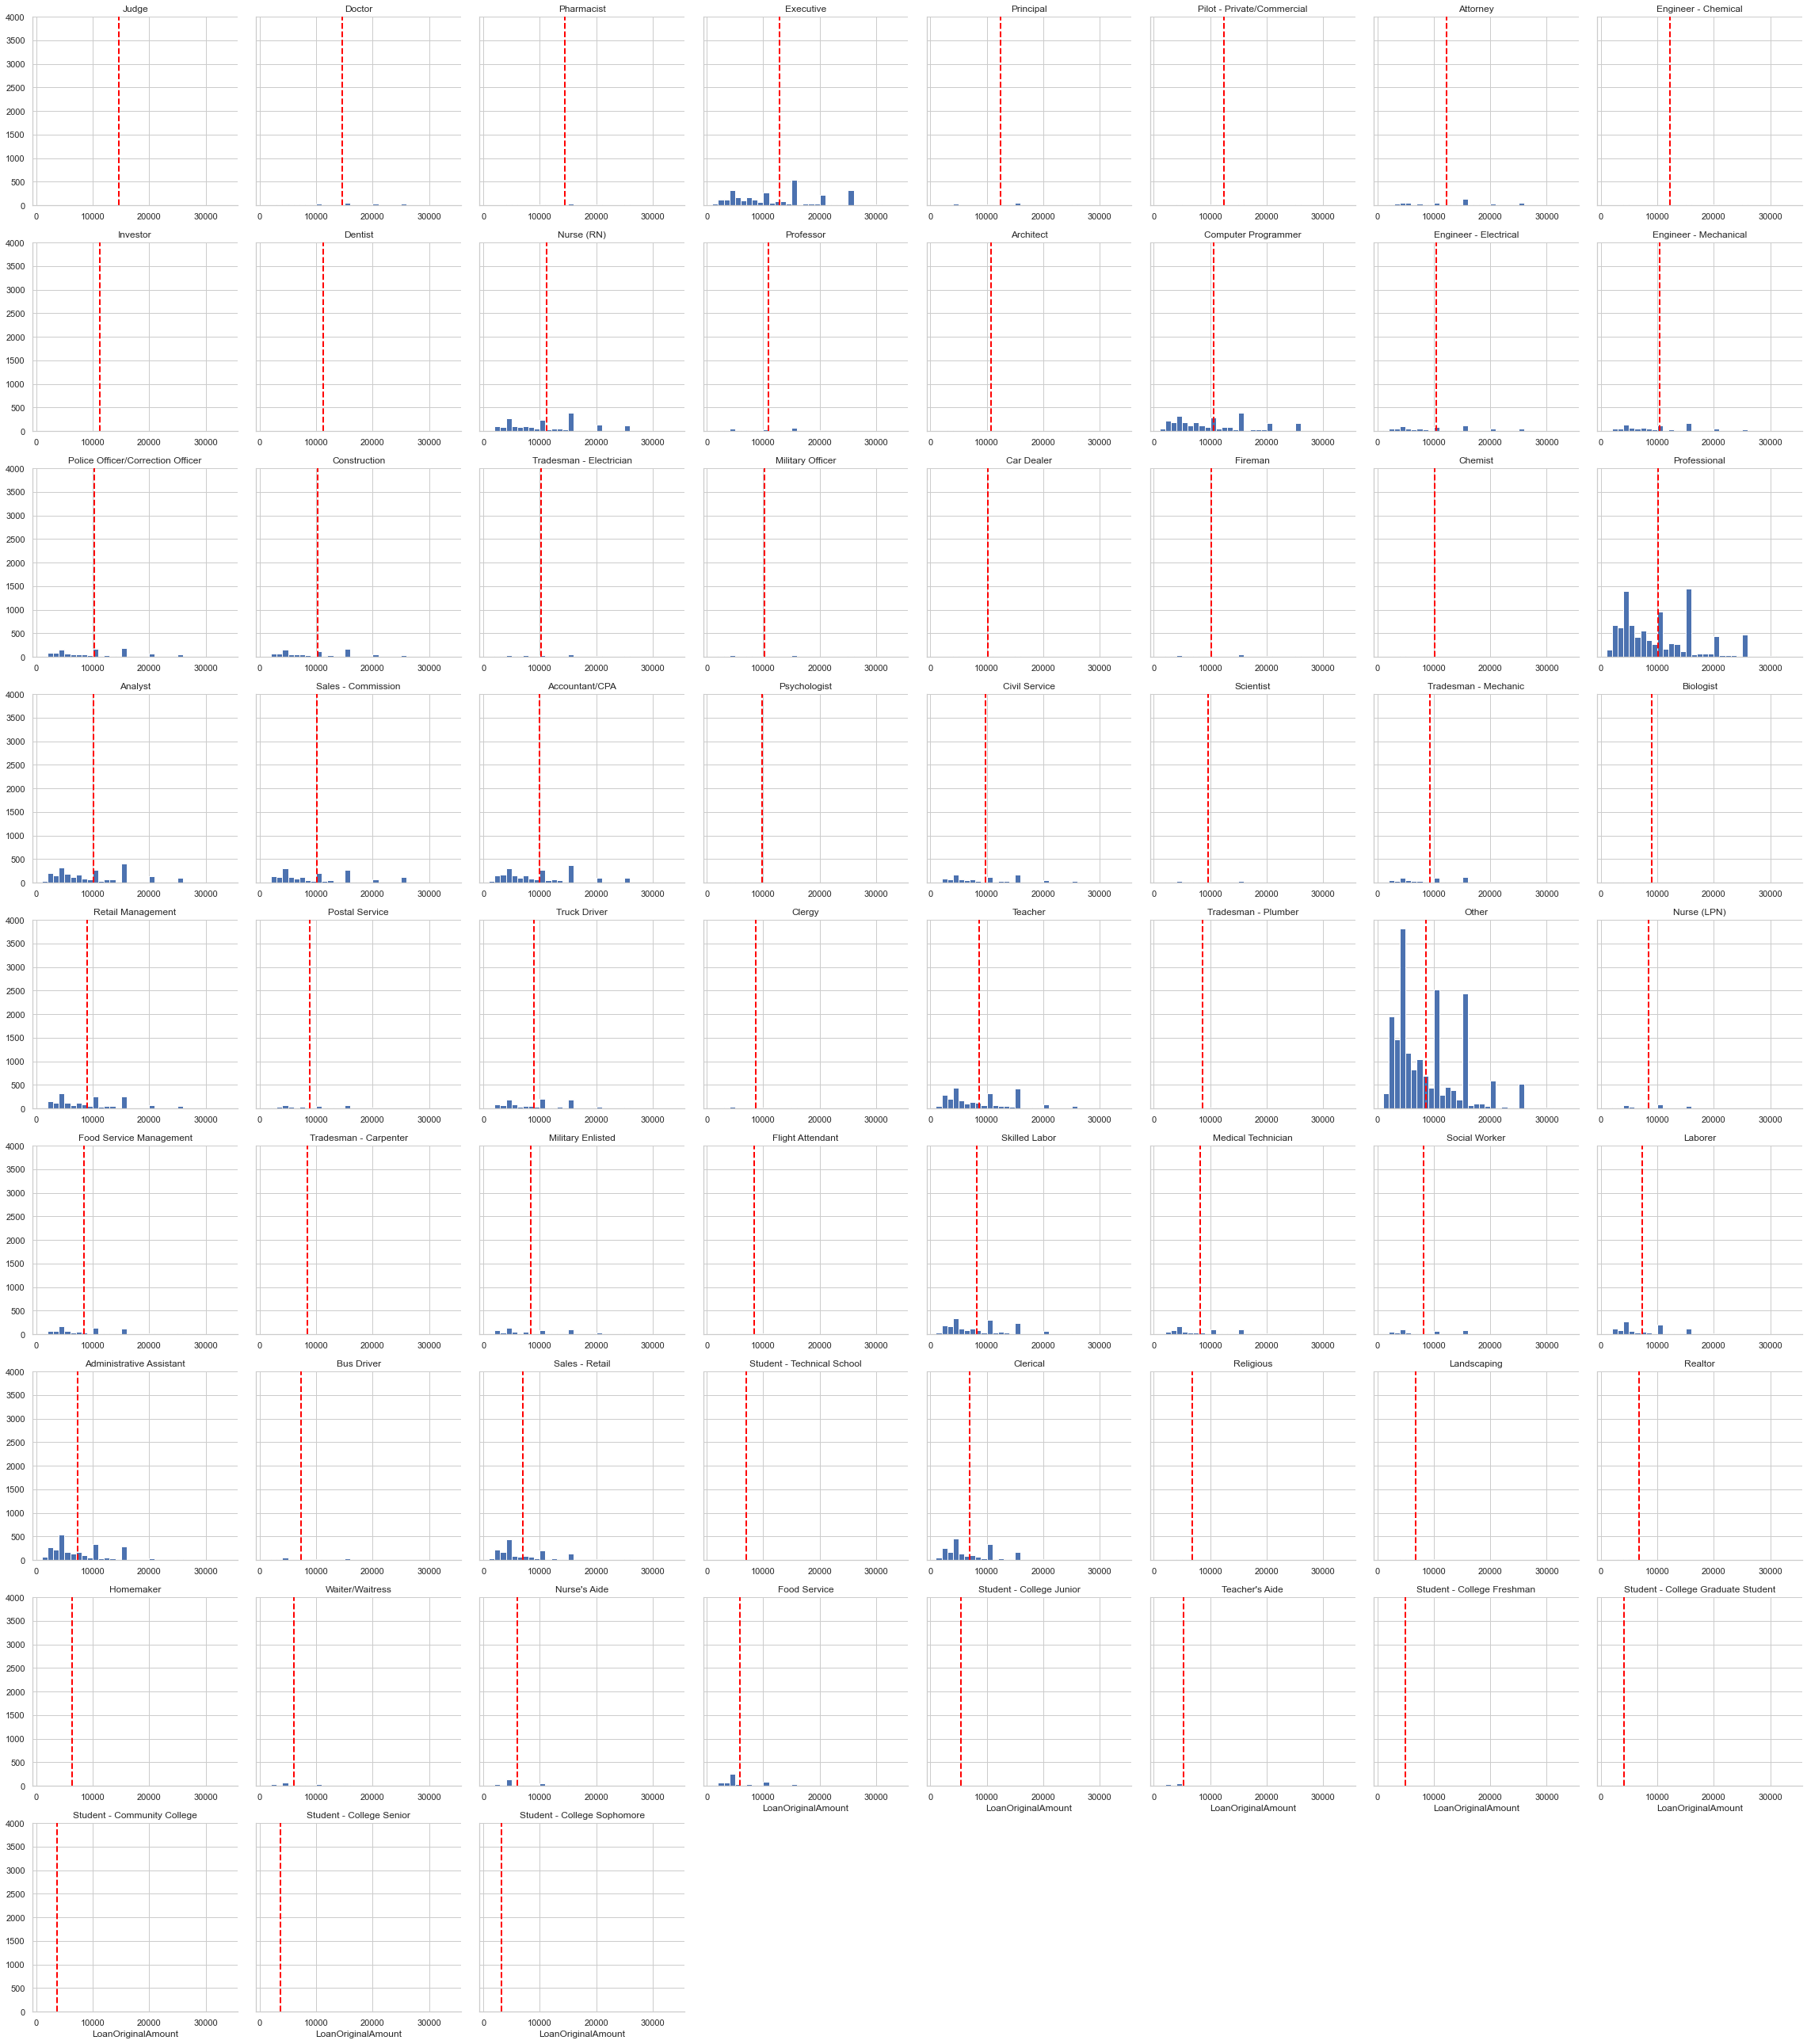

In [169]:
# get the mean LoanAmount
occ_rate = df.groupby(['Occupation']).mean()
occ_rate = occ_rate.sort_values(['LoanOriginalAmount'], ascending = False).index

# plot the vertical mean 
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)

# create the plot
g = sb.FacetGrid(data = df, col = 'Occupation', col_wrap = 8, size = 4, sharex=False,col_order = occ_rate);
g.map(plt.hist, 'LoanOriginalAmount', bins = np.arange(1000, 35000, 1000));
g.map(vertical_mean_line, 'LoanOriginalAmount');
g.set_titles('{col_name}');

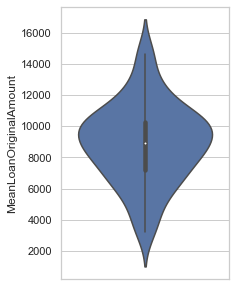

In [170]:
occ_loan_mean = df.groupby('Occupation')['LoanOriginalAmount'].mean().reset_index(name = 'MeanLoanOriginalAmount')
occ_loan_mean.MeanLoanOriginalAmount = occ_loan_mean.MeanLoanOriginalAmount.astype(float)
plt.figure(figsize = [3, 5])
sb.violinplot(data = occ_loan_mean, y = 'MeanLoanOriginalAmount', color = base_color);

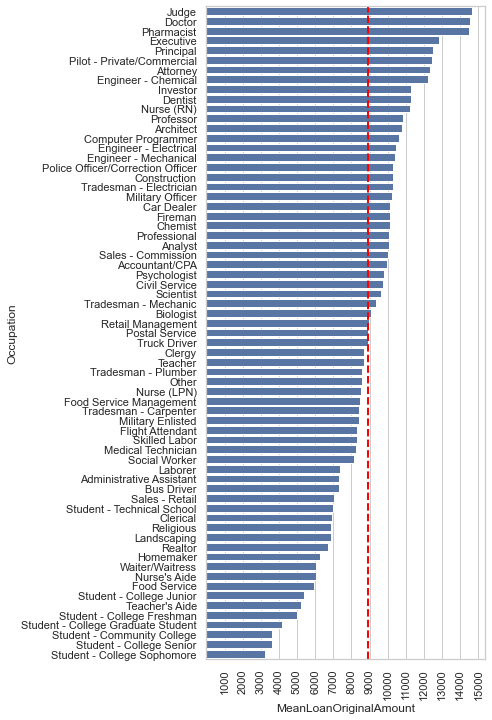

In [171]:
#Plot along the occupations
plt.figure(figsize = [5, 12])
sb.barplot(y="Occupation", x="MeanLoanOriginalAmount", data=occ_loan_mean, color=base_color, order=occ_loan_mean.sort_values(['MeanLoanOriginalAmount'], ascending = False)['Occupation']) ;
plt.xticks(rotation=90);
plt.xticks(np.arange(1000,occ_loan_mean.MeanLoanOriginalAmount.max()+1000,1000))
plt.axvline(occ_loan_mean.MeanLoanOriginalAmount.describe()[1], color='red', linestyle='dashed', linewidth=2);

#### Occupation vs. ProsperScore

First let's compare the 2 main scoring attributes ProsperScore and ProsperRating, 

In [172]:
df['ProsperScore_Num'] = df['ProsperScore'].astype(float)

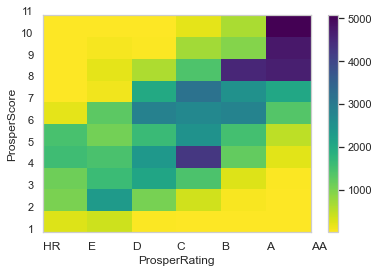

In [173]:
fig, ax = plt.subplots(1,1) 
# adjust the bins
bins_x = np.arange(1, 8, 1)
bins_y = np.arange(1, 12, 1)
img = ax.hist2d(data = df, x = 'ProsperRating_numeric', y = 'ProsperScore_Num',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5 )
# adjust the labels 
plt.xlabel('ProsperRating')
plt.ylabel('ProsperScore');
x_ticks_labels = ["HR", "E", "D", "C", "B", "A", "AA"]

# Set number of ticks for x-axis
ax.set_xticks(bins_x)
ax.set_yticks(bins_y)
# Set ticks labels for x-axis
ax.set_xticklabels(x_ticks_labels, fontsize=12, ha='left');
ax.set_yticklabels(labels=bins_y,  va='baseline');
plt.colorbar(img[3], ax=ax);


`Comment`: The darker area somehow shows the relationsip between the 2. However Prosper Rating e.g. of "C" gives a range of from 2-11. 

Occupation ProsperRating_Alpha
Denominator: 77108


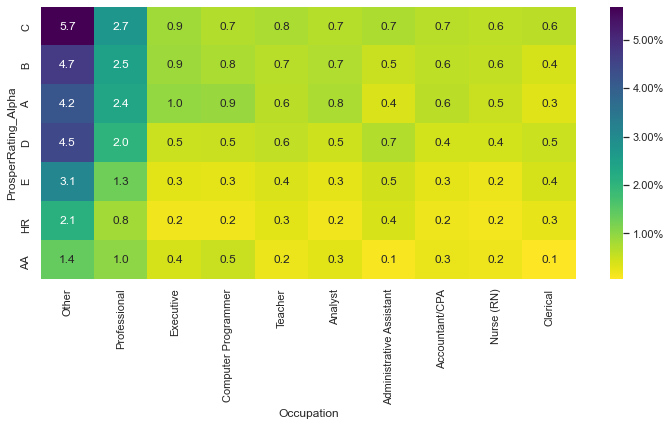

In [174]:
categorial_2d(data=df, x='Occupation',y='ProsperRating_Alpha',zoom_x=10,zoom_y=10,fig_size=[12,5], percent=True, annotate=True)

`Comment`: The majority of the different professions are concentrated in the area from C to A. What is the Score telling us?

Occupation ProsperScore
Denominator: 77108


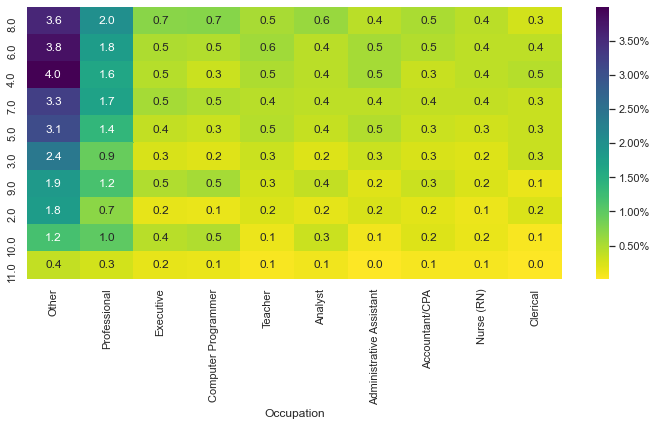

In [175]:
# zoom to the first most count occupations
categorial_2d(data=df, x='Occupation',y='ProsperScore',zoom_x=10,zoom_y=10,fig_size=[12,5], percent=True, annotate=True)

`Comment:` It ranges 2-10, so the extreme 1 and 11 are much lesser seen. Espeically the usual suspects Others, Professionals, Executives , Computer Programmer, Teacher etc. are underlining that.

`Summary Who is using Prosper`: 
* It seems that the occupations and the status pretty clear shows that the occupation groups "Others" 
* "Proffesional, "Executives" and "Computer Programmers" from California are most present.
* There is a nearly equal split of Homeowners and Non-Homeowners, however the lesser the proportion of 
prosper user is the higher the homeowner proportion gets (with some exceptions)
* Most of the Prosper Users are "Employed (Fulltime)"
* Most of the Prosper Users are using the loan for "Debt consolidation" 
* The highest mean income do "Doctors" have 
* The highest mean DebtToIncomeRation do "Teacher's Aide" have.
* The highest mean loan amount do "Judges" have 
* The most frequent Score is 4 along the "Others" and "Professional" group
* The most frequent rating is C along the "Others" and "Professional" group

In general the occupation group "Other" is dominating the listings, whereas other occupations have a small proportion. This is a petty as it might be due to the fact that users have the possibility to choose from a ddlb the other category.

Let's move over to my 2nd question I had and pull some atributes for bi-variate analysis.

### Why is Prosper used?
I had immidiatly 2 things in mind why the borrowers use Prosper instead using a normal bank. As we know now already that Debt Consolidation is the most frequent ListingType so loan type, what makes it so attractive? Is it the time from application to the point of time receiving the money. I call that time to money.

#### Listing Creation Date vs. Loan Origination Date 

In [176]:
# create a time series by week
week_loan = df.groupby([pd.Grouper(key='LoanOriginationDate', freq='W-MON')])['ListingNumber'].count().reset_index().sort_values('LoanOriginationDate')
week_list = df.groupby([pd.Grouper(key='ListingCreationDate', freq='W-MON')])['ListingNumber'].count().reset_index().sort_values('ListingCreationDate')
week_list.rename(index=str, columns={"ListingCreationDate": "week", "ListingNumber": "ListingCount"}, inplace=True)
week_loan.rename(index=str, columns={"LoanOriginationDate": "week", "ListingNumber": "LoanCount"}, inplace=True)

In [177]:
week = pd.merge(week_list, week_loan, how='outer', on='week')
week.fillna(0,inplace=True)
week.set_index('week', inplace=True)
week.head()

ListingCount  LoanCount
week                               
2009-07-13          12.0        0.0
2009-07-20          66.0        1.0
2009-07-27          51.0        3.0
2009-08-03          55.0       16.0
2009-08-10          61.0       54.0

In [178]:
# calculate the difference of  Listing Creation Date vs. Loan Origination Date 
df['Time2Money'] = df['LoanOriginationDate'] - df['ListingCreationDate']

In [179]:
# round to full days
df['Time2Money'] = df['Time2Money'].dt.round('1d')
df['Time2Money'] = df['Time2Money'].dt.days

In [180]:
df.Time2Money.describe()

count    77108.000000
mean        11.102674
std         17.459497
min          0.000000
25%          4.000000
50%          7.000000
75%         12.000000
max        530.000000
Name: Time2Money, dtype: float64

In [181]:
week_time2money_avg = df.groupby([pd.Grouper(key='ListingCreationDate', freq='W-MON')])['Time2Money'].mean().reset_index().sort_values('Time2Money')

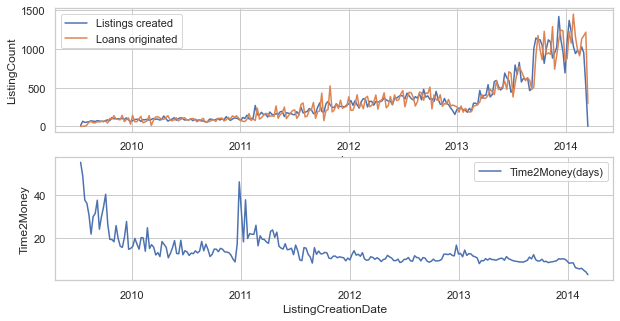

In [182]:
# plot a time series

plt.figure(figsize = [10, 5]) # larger figure size for subplots
# histogram on left, example of too-large bin size
plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1
ax = sb.lineplot(week.index, week.ListingCount, label='Listings created')
ax = sb.lineplot(week.index, week.LoanCount, label='Loans originated')

plt.subplot(2, 1, 2) # 1 row, 2 cols, subplot 2
ax2 = sb.lineplot(week_time2money_avg.ListingCreationDate, week_time2money_avg.Time2Money, label='Time2Money(days)')

`Comment`: Fast is different, however the platform Prosper seems to accelarate with increasing Listings. There is a clear downward trend in Time2Money attribute, which might attract the borrowers. What else could attract borrowers to use Prosper? What else could be reason to use Prosper? For sure the money you need to pay which can be summarized by the Borrower Annual % Rate.

#### Listing Creation Date vs. BorrowerAPR

In [183]:
# create a time series by week
week_apr  = df.groupby([pd.Grouper(key='ListingCreationDate', freq='W-MON')])['BorrowerAPR'].mean().reset_index().sort_values('ListingCreationDate')
week_rate = df.groupby([pd.Grouper(key='ListingCreationDate', freq='W-MON')])['BorrowerRate'].mean().reset_index().sort_values('ListingCreationDate')
week_apr.set_index('ListingCreationDate', inplace=True)
week_rate.set_index('ListingCreationDate', inplace=True)
#week_apr.rename(index=str, columns={"ListingCreationDate": "week"}, inplace=True)
#week_rate.rename(index=str, columns={"ListingCreationDate": "week", "ListingNumber": "LoanCount"}, inplace=True)

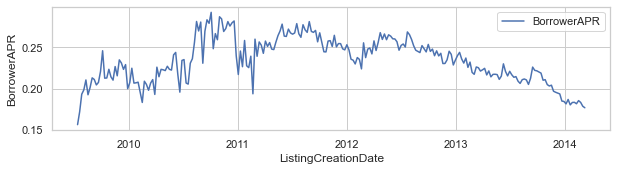

In [184]:
# plot a a time series
plt.figure(figsize = [10, 5]) # larger figure size for subplots
# histogram on left, example of too-large bin size
plt.subplot(2, 1, 1) # 1 row, 2 cols, subplot 1
ax = sb.lineplot(week_apr.index, week_apr.BorrowerAPR, label='BorrowerAPR')
#ax = sb.lineplot(week.index, week.ListingCount, label='Listings created')

`Comment`: At the end of 2011 the rates have being considerable higher as before and it seems as this was the end of an upward trend, till the mid of 2014 it was constantly going down. Is there a difference on the Occupation?

#### BorrowerAPR vs. Occupation

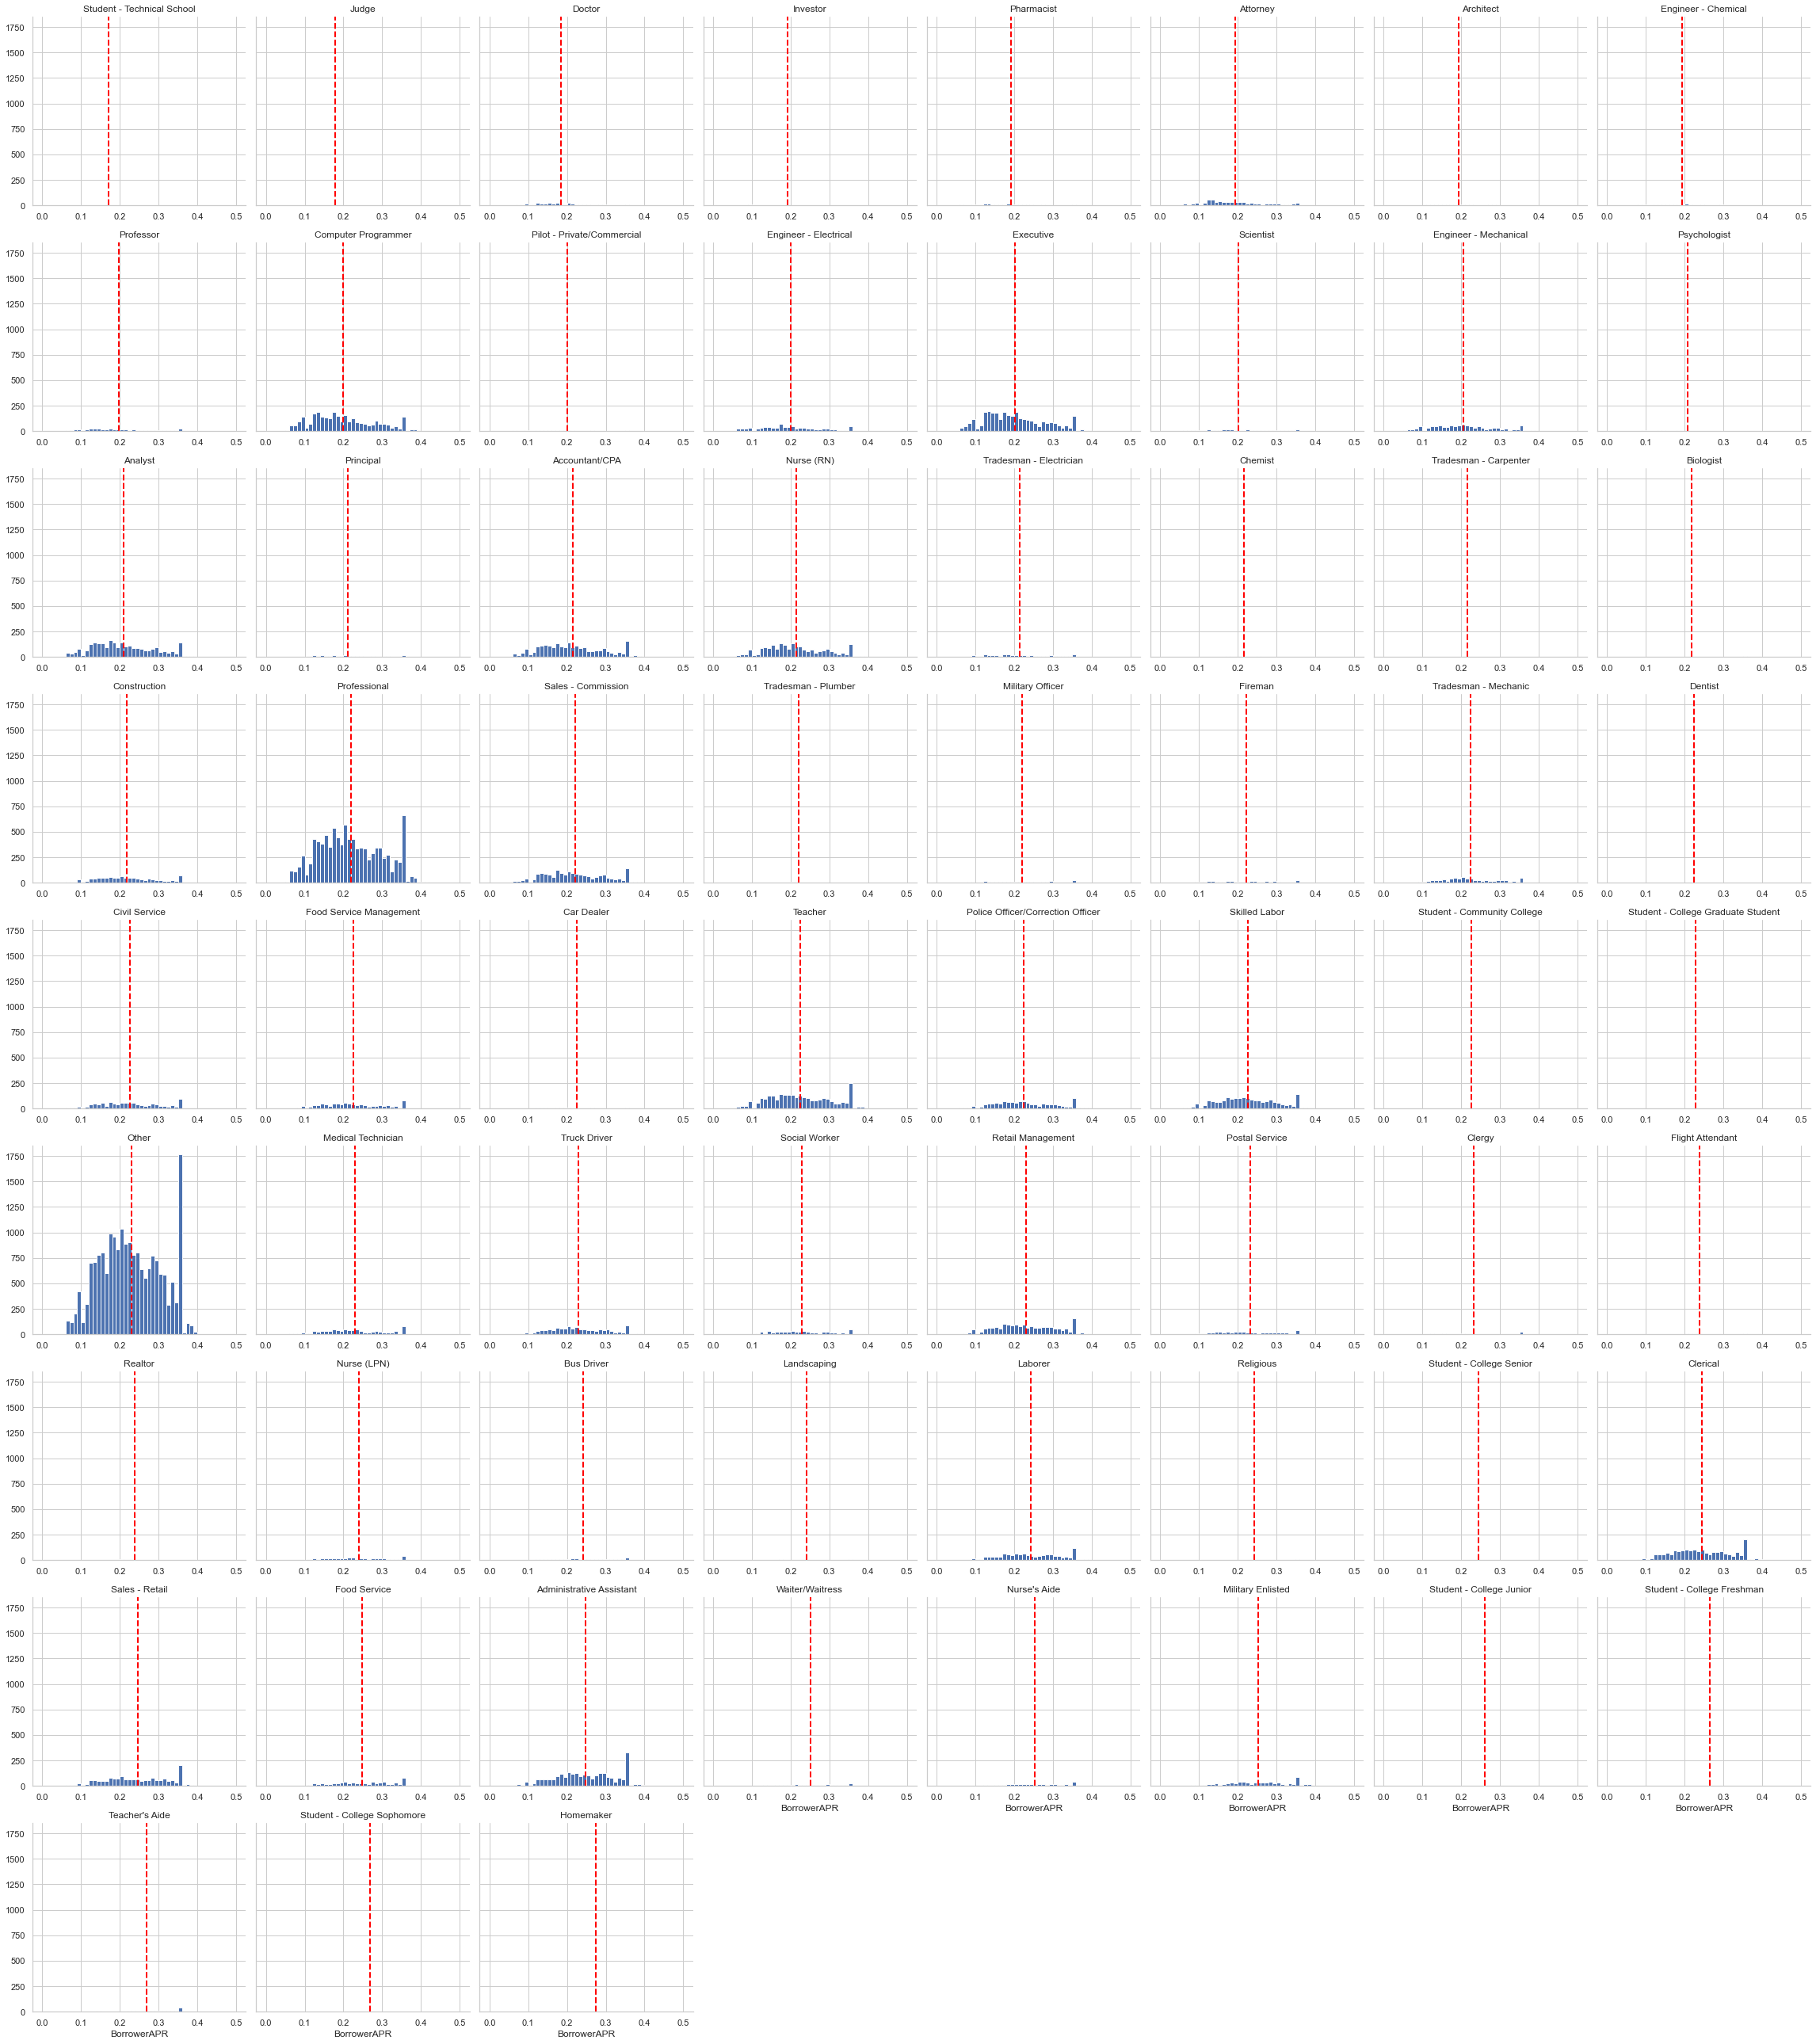

In [185]:
# calculate the mean APR
occ_rate = df.groupby(['Occupation']).mean()
occ_rate = occ_rate.sort_values(['BorrowerAPR'], ascending = True).index

# plot the vertical mean 
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)

# create the plot
g = sb.FacetGrid(data = df, col = 'Occupation', col_wrap = 8, size = 4, sharex=False, col_order = occ_rate);
g.map(plt.hist, 'BorrowerAPR', bins = np.arange(0, .5+0.01, 0.01));
g.map(vertical_mean_line, 'BorrowerAPR');
g.set_titles('{col_name}');

Student from a technical school having the best mean APR followed by Judges, Doctors, Invstors as an example. However one can see that the porportion of those aren't very high. The usual suspects in that dataset (Others, Professionalsetc.) come later. Let's check the distribution of the means and bring it to an order.

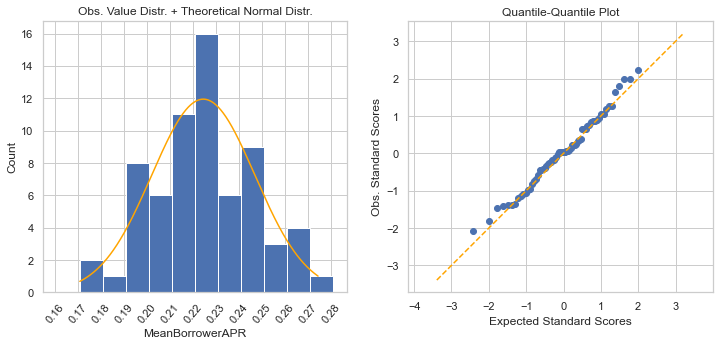

In [186]:
# let's plot the distribution, I know Q-Q plot is already bivraiate but it is already so useful
occ_rate_mean = df.groupby('Occupation')['BorrowerAPR'].mean().reset_index(name = 'MeanBorrowerAPR')
occ_rate_mean.MeanBorrowerAPR = occ_rate_mean.MeanBorrowerAPR.astype(float)
metric_distri_qq(occ_rate_mean.MeanBorrowerAPR, [12,5],  0.01, 0.01)

the means of the occupations seems to be nicely normal distributed... let's review them 

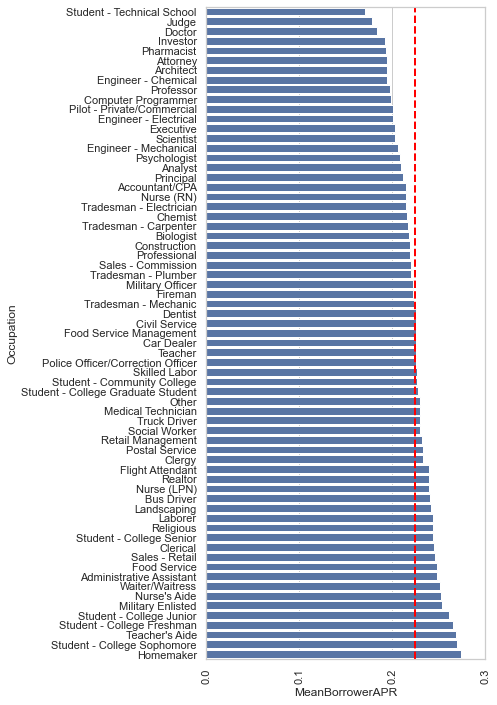

In [187]:
plt.figure(figsize = [5, 12])
sb.barplot(y="Occupation", x="MeanBorrowerAPR", data=occ_rate_mean, color=base_color, order=occ_rate_mean.sort_values(['MeanBorrowerAPR'], ascending = True)['Occupation']) ;
plt.xticks(rotation=90);
plt.xticks(np.arange(0,df.BorrowerAPR.mean()+0.1,0.1))
plt.axvline(occ_rate_mean.MeanBorrowerAPR.describe()[1], color='red', linestyle='dashed', linewidth=2);

In [188]:
df.BorrowerAPR.mean()

0.2238441454842164

`Comment`: It's not a bargain, the avg. Borrower APR is appr. 22%.  Let's look if there is a relation to the score. However Computer Programmer and Executives are getting far better rates then Professionals and the famous Others.

`Summary`: Why is Prosper used?

* Time2Money: Might be a reason,but fast is different, however the platform Prosper seems to accelarate with increasing listings count over time. There is a clear downward trend in Time2Money attribute, which might attract the borrowers. 
* BorrowerAPR over time: At the end of 2011 the rates have being considerable higher as before and it seems as this was the end of an upward trend, till the mid of 2014 it was constantly going down
* BorrowerAPR by Occupation: Still not a bargain, the avg. Borrower APR is appr. 22%.  Let's look if there is a relation to the score. However Computer Programmer and Executives are getting far better rates then Professionals and the famous Others.


Finally move now to question ....

### What is influencing the Rates?

There are some "low Brainers" which we can check first.

#### BorrowerAPR vs. ProsperRating

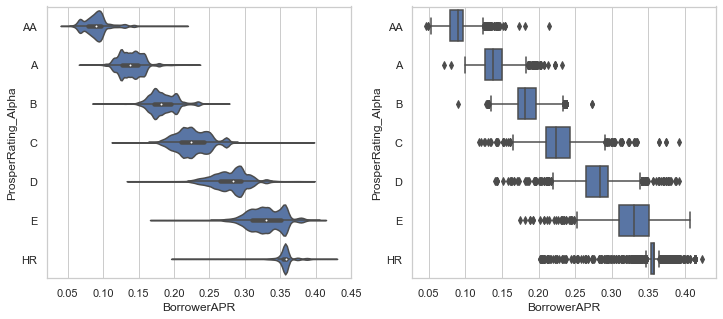

In [189]:
plt.figure(figsize = [12, 5])
base_color = sb.color_palette()[0]
# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sb.violinplot(data = df, y = 'ProsperRating_Alpha', x = 'BorrowerAPR', color = base_color, scale='width')
# right plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data = df, y = 'ProsperRating_Alpha', x = 'BorrowerAPR', color = base_color);
plt.ylim(ax1.get_ylim());

`Comment`: The distributions are nicely climbing with decreasing the rating. Most of the distribution are bi- or multimodal. The spread in each category is as well large. On categories AA we find many outliers to the right. In A as well and C, D have outliers as well in both directions. E has outliers to the left. Again below as an example the density and viloin plot for "E"! HR has a relatively small IQR and many outliers to the left an dto the right.
So what else influences the APR?

#### BorrowerAPR vs. DebtToIncomeRatio

In [190]:
df.DebtToIncomeRatio.isna().sum()

0

In [191]:
df.BorrowerAPR.isna().sum()

0

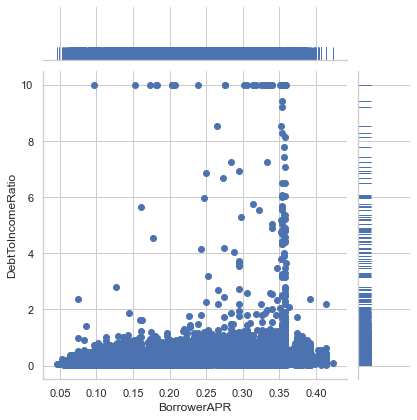

In [192]:
g = sb.JointGrid(data = df, x = 'BorrowerAPR', y = 'DebtToIncomeRatio')
g.plot_joint(plt.scatter)
g.plot_marginals(sb.rugplot, height = 0.25);

`Comment`: As we know from the beginning the correlation coeff = 0,128, so we have a weak linear relation. Below 2 the rates are going the full range we need to zoom in a bit. One thing which is looking strange is the nearly vertical line between 0,35 and appr. 0,37 along all DtIR.

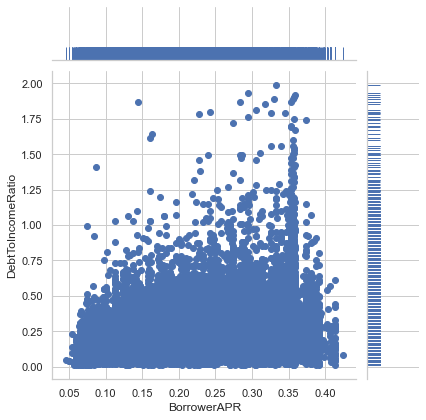

In [193]:
# zoom to DtIR <= 2
d2ir = df.query('DebtToIncomeRatio <= 2')
g = sb.JointGrid(data = d2ir, x = 'BorrowerAPR', y = 'DebtToIncomeRatio')
g.plot_joint(plt.scatter)
g.plot_marginals(sb.rugplot, height = 0.25);

Below 1 and 0.5 DTIR there seems to be a concentration on the of rates...let's check quickly in a heatmap.

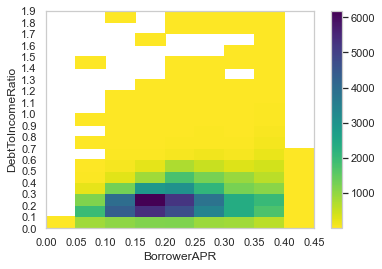

In [194]:
fig, ax = plt.subplots(1,1) 

bins_x = np.arange(0.0, 0.5, 0.05)
bins_y = np.arange(0.0, 2.0, 0.1)
img = ax.hist2d(data = d2ir, x = 'BorrowerAPR', y = 'DebtToIncomeRatio',
           bins = [bins_x, bins_y], cmap = 'viridis_r', cmin = 0.5 )

plt.xlabel('BorrowerAPR')
plt.ylabel('DebtToIncomeRatio');

# Set number of ticks for x-axis
ax.set_xticks(bins_x)
ax.set_yticks(bins_y)
plt.colorbar(img[3], ax=ax);

`Comment`: The majority of the values is concentrated between 0,1 and 0,4 and  0,10 to 0,25. We can see a slight upward trend in the concentrated area, but the rate also must be influenced by something else. Maybe the term?

#### BorrowerAPR vs Term

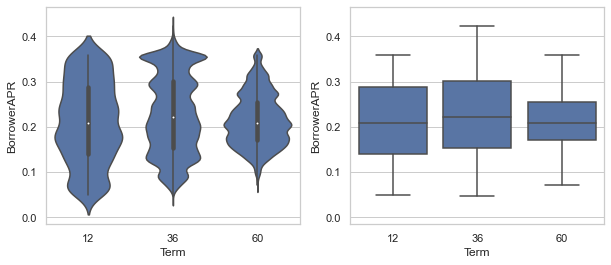

In [195]:
plt.figure(figsize = [10, 4]);
base_color = sb.color_palette()[0]
# left plot: violin plot
plt.subplot(1, 2, 1);
ax1 = sb.violinplot(data = df, x = 'Term', y = 'BorrowerAPR', color = base_color, scale='width');
# center plot: box plot
plt.subplot(1, 2, 2);
sb.boxplot(data = df, x = 'Term', y = 'BorrowerAPR', color = base_color);
plt.ylim(ax1.get_ylim());

We know from the Univariate Analysis that 12 month term are very seldom bit they have a lower rates as a starting point of their distributions. So 36 seems to be multimodal and 60 right skewed. Still all 3 terms give overall a wide range of rates. In 36 we see the 3rd modality which is looking similar to the concentration we saw in the DTIR between 0,35 and 0,37 let's look closer. The Medians are close to each other, the range for 60 is smaller.

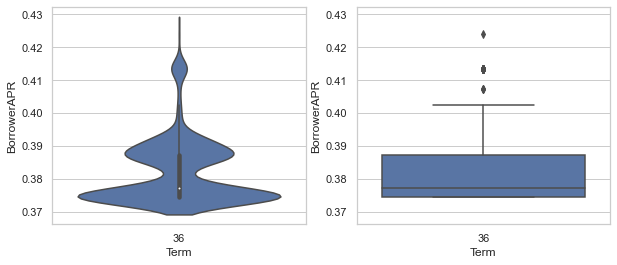

In [196]:
# filter to 0,35 to 0,60
df_035 = df.query('BorrowerRate >= 0.35 & BorrowerRate <= 0.6')

plt.figure(figsize = [10, 4]);
base_color = sb.color_palette()[0]
# left plot: violin plot
plt.subplot(1, 2, 1);
ax1 = sb.violinplot(data = df_035, x = 'Term', y = 'BorrowerAPR', color = base_color, scale='width');
# center plot: box plot
plt.subplot(1, 2, 2);
sb.boxplot(data = df_035, x = 'Term', y = 'BorrowerAPR', color = base_color);
plt.ylim(ax1.get_ylim());

In [197]:
df_035.Term.value_counts()

36    676
Name: Term, dtype: int64

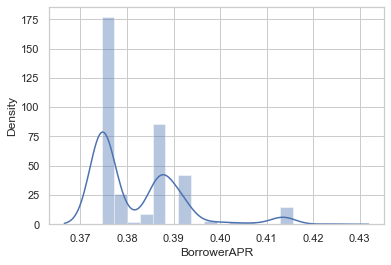

In [198]:
sb.distplot(df_035['BorrowerAPR']);

`Comment`: So this can might explain the peak line we saw in the D2IR I was mentioning before, however either it is a combination of attributes or it is another attribute which is primarily deriving the rate. Let's check the Score.

#### BorrowerAPR vs. ProsperScore

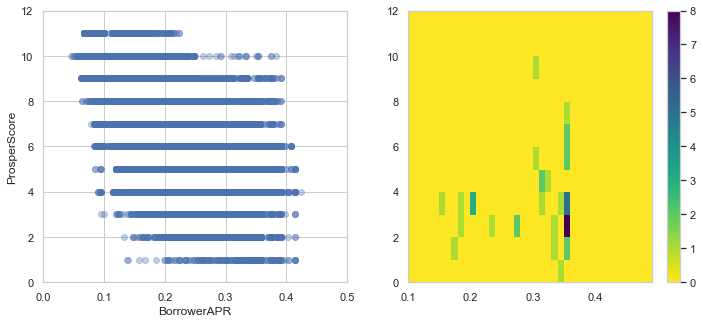

In [199]:
# zoom to the 3rd quantile
plt.figure(figsize = [12, 5])

x = np.arange(0.1, 0.5, 0.05)
# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
ax = sb.regplot(data = df, x = 'BorrowerAPR', y = 'ProsperScore', fit_reg = False,
           x_jitter = 0.0, y_jitter = 0.0, scatter_kws = {'alpha' : 1/3})
# right plot: heat map with bin edges between values
ax.set_ylim(0,12)           
ax.set_xlim(0,0.5)
plt.subplot(1, 2, 2)
bins_x = np.arange(0.1, 0.5, 0.01)
bins_y = np.arange(0, 13, 1)
plt.hist2d(data = df, x = 'BorrowerAPR', y = 'StatedMonthlyIncome',
           bins = [bins_x, bins_y], cmap = 'viridis_r')
plt.colorbar();

`Comment`: We can see that the medians of the rates are increasing by decreasing the score. However 2 things are here interesting. 
* The scores 7 - 3 are relatively wide IQRs and no (nearly) outliers. 
* Whereas 10 to 8  and 2 to 1 are  have many outliers to the right and to the left.

The groups 11 and 1 are relatively small. So there is still something else which controls the rates.Let's look to the income

#### BorrowerRate vs. IncomeVerifiable

In [200]:
df['IncomeVerifiable'].replace({True: 'Yes', False: 'No'}, inplace=True)
df.IncomeVerifiable.value_counts()

Yes    77060
No        48
Name: IncomeVerifiable, dtype: int64

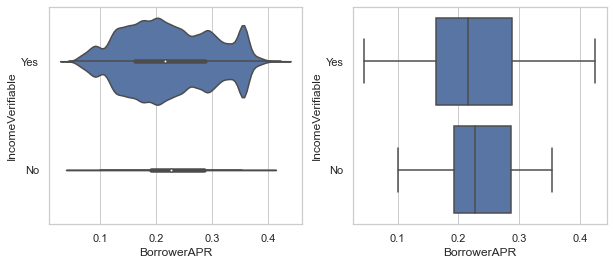

In [201]:
plt.figure(figsize = [10, 4])
base_color = sb.color_palette()[0]
# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sb.violinplot(data = df, y = 'IncomeVerifiable', x = 'BorrowerAPR', color = base_color, scale='count')
# right plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data = df, y = 'IncomeVerifiable', x = 'BorrowerAPR', color = base_color);
plt.ylim(ax1.get_ylim());

`Comment`: The appr. 10% not having a verified income do get higher rates. So having all documents ready helps as well here. What else could influence the rate. Property?

#### BorrowerAPR vs. IsBorrowerHomeowner

In [202]:
df['IsBorrowerHomeowner'].replace({True: 'Yes', False: 'No'}, inplace=True)
df.IsBorrowerHomeowner.value_counts()

Yes    41841
No     35267
Name: IsBorrowerHomeowner, dtype: int64

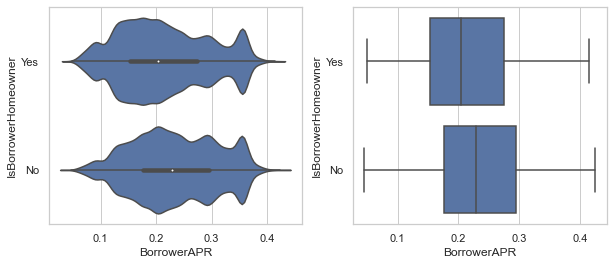

In [203]:
plt.figure(figsize = [10, 4])
base_color = sb.color_palette()[0]
# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sb.violinplot(data = df, y = 'IsBorrowerHomeowner', x = 'BorrowerAPR', color = base_color, scale='width')
# right plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data = df, y = 'IsBorrowerHomeowner', x = 'BorrowerAPR', color = base_color);
plt.ylim(ax1.get_ylim());

`Comment`: To own a house definity helps. We can clearly see that the median rate is lower for houseowners. Ok let's finally check here amount requested.

#### BorrowerAPR vs. StatedMonthyIncome

In [204]:
df.StatedMonthlyIncome_ln.describe()

count    77108.000000
mean         3.702410
std          0.257981
min         -0.602060
25%          3.549192
50%          3.698970
75%          3.855317
max          5.199572
Name: StatedMonthlyIncome_ln, dtype: float64

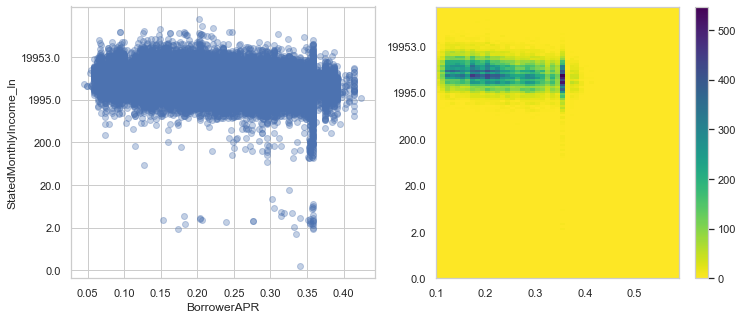

In [205]:
# zoom to the 3rd quantile
plt.figure(figsize = [12, 5])

x = np.arange(0.1, 0.6, 0.01)
# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
ax = sb.regplot(data = df, x = 'BorrowerAPR', y = 'StatedMonthlyIncome_ln', fit_reg = False,
           x_jitter = 0.0, y_jitter = 0.0, scatter_kws = {'alpha' : 1/3})
# right plot: heat map with bin edges between values
# ln10 scale
a = np.arange(-.7, 5.2, 1)
b = 10 ** a
b = np.around(b, decimals=0, out=None)
plt.yticks(a,b)
plt.subplot(1, 2, 2)
bins_x = np.arange(0.1, 0.6, 0.01)
bins_y = np.arange(-.7, 5.2, .05)
plt.hist2d(data = df, x = 'BorrowerAPR', y = 'StatedMonthlyIncome_ln',
           bins = [bins_x, bins_y], cmap = 'viridis_r')
plt.yticks(a,b)
plt.colorbar();

`Comment`: we can see on the log scale that the most frequent area is 1900 and above 20000 (I mean it's monthly income). However the range of APR is still going from 5 - above 40%. Having a lot of money/month is not an indication to get better rates.

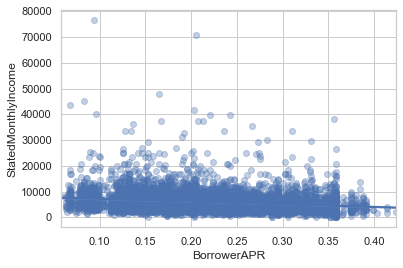

In [206]:
sb.regplot(data = pairplot_samp, x = 'BorrowerAPR', y = 'StatedMonthlyIncome', scatter_kws = {'alpha' : 1/3});

`Comment`: We see that the fit isn't really good but it emphasizes a bit the less income the higher the rate. In the heatmap we see a that the range goes from 0,1 to 0,4 through all income levels. Let's revisit the categorial income range.

#### BorrowerAPR vs. IncomeRange

In [207]:
df.IncomeRange.isna().sum()

0

In [208]:
df.IncomeRange.value_counts()

$50,000-74,999    23898
$25,000-49,999    21881
$100,000+         13943
$75,000-99,999    13576
$1-24,999          3809
Not employed          1
Name: IncomeRange, dtype: int64

In [209]:
# massage quickly the data type 
income = ['$100,000+', '$75,000-99,999','$50,000-74,999', '$25,000-49,999', '$1-24,999', 'Not employed']
df.IncomeRange = pd.Categorical(df.IncomeRange, 
                                  categories=income, ordered=True)

In [210]:
df.IncomeRange.value_counts()

$50,000-74,999    23898
$25,000-49,999    21881
$100,000+         13943
$75,000-99,999    13576
$1-24,999          3809
Not employed          1
Name: IncomeRange, dtype: int64

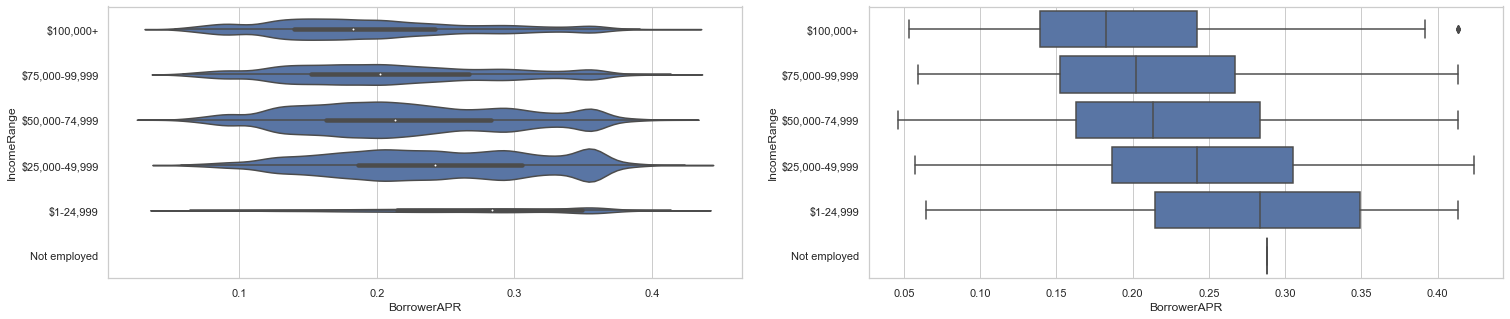

In [211]:
plt.figure(figsize = [25, 5])
base_color = sb.color_palette()[0]
# left plot: violin plot
plt.subplot(1, 2, 1)
ax1 = sb.violinplot(data = df, y = 'IncomeRange', x = 'BorrowerAPR', color = base_color, scale='count')
# right plot: box plot
plt.subplot(1, 2, 2)
sb.boxplot(data = df, y = 'IncomeRange', x = 'BorrowerAPR', color = base_color);
plt.ylim(ax1.get_ylim());

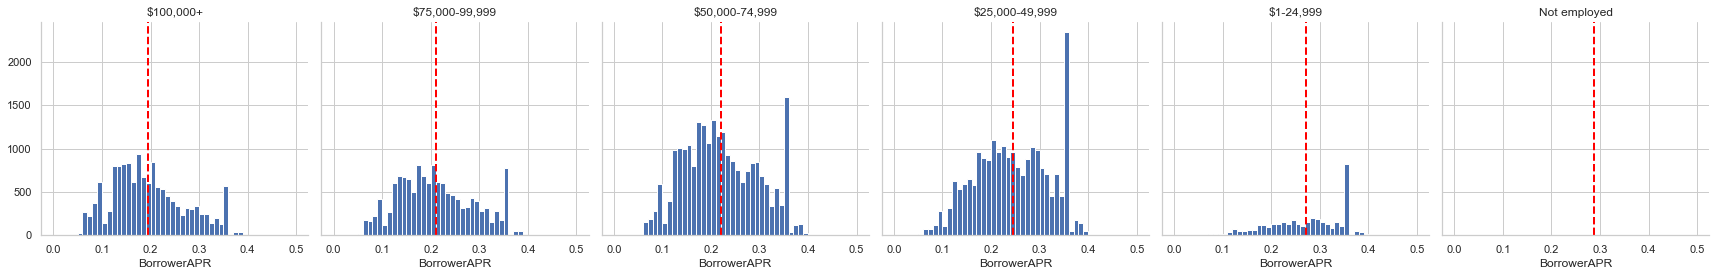

In [212]:
# p mean 
icr_rate = df.groupby(['IncomeRange']).mean()
icr_rate = icr_rate.sort_values(['BorrowerAPR'], ascending = True).index



def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=2)

# create the plot
g = sb.FacetGrid(data = df, col = 'IncomeRange', col_wrap = 6, size = 4, sharex=False, col_order = icr_rate)
g.map(plt.hist, 'BorrowerAPR', bins = np.arange(0, .5+0.01, 0.01));
g.map(vertical_mean_line, 'BorrowerAPR');
g.set_titles('{col_name}');

`Comment`: This makes it really visible the platform Prosper is used by well earning lenders, the spike between 0.3 and 0.4. Having a higher income definitely helps to get the best rates, however there is much variance in the distributions. The proportion of below 25k and even unemployed is very small. 

#### BorrowerAPR vs. MonthlyLoanPayment

In [213]:
df.MonthlyLoanPayment.describe()

count    77108.000000
mean       297.465653
std        188.535826
min          0.240000
25%        159.770000
50%        258.030000
75%        392.810000
max       2251.510000
Name: MonthlyLoanPayment, dtype: float64

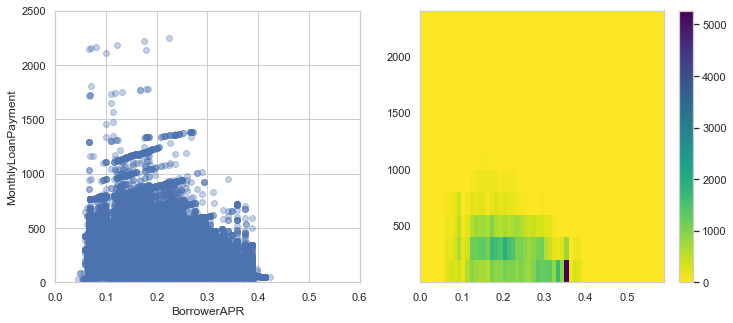

In [214]:
# zoom to the 3rd quantile
plt.figure(figsize = [12, 5])

x = np.arange(0.1, 0.6, 0.01)
# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
ax = sb.regplot(data = df, x = 'BorrowerAPR', y = 'MonthlyLoanPayment', fit_reg = False,
           x_jitter = 0.0, y_jitter = 0.0, scatter_kws = {'alpha' : 1/3})
# right plot: heat map with bin edges between values
ax.set_ylim(0,2500)
ax.set_xlim(0,0.6)
plt.subplot(1, 2, 2)
bins_x = np.arange(0, 0.6, 0.01)
bins_y = np.arange(1, 2500, 200)
plt.hist2d(data = df, x = 'BorrowerAPR', y = 'MonthlyLoanPayment',
           bins = [bins_x, bins_y], cmap = 'viridis_r')
plt.colorbar();

`Comment`: The monthly payment seems to have a limit at appr. 1000$ this is where below most of the rates are concentrated a slight trend can be seen that lower rates are drawn by higher monthly payments. Also notice the peak between 0.3 and 0.4 and 200!

#### BorrowerAPR vs. LoanOriginalAmount

In [215]:
df.LoanOriginalAmount.describe()

count    77108.000000
mean      9300.966683
std       6398.995358
min       1000.000000
25%       4000.000000
50%       8000.000000
75%      14584.500000
max      35000.000000
Name: LoanOriginalAmount, dtype: float64

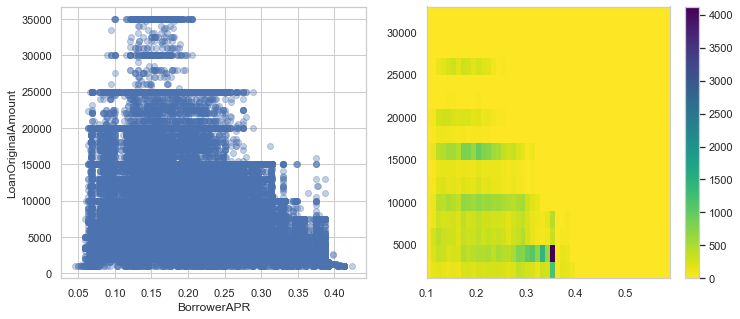

In [216]:
plt.figure(figsize = [12, 5])

x = np.arange(0.1, 0.6, 0.01)
# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
sb.regplot(data = df, x = 'BorrowerAPR', y = 'LoanOriginalAmount', fit_reg = False,
           x_jitter = 0.0, y_jitter = 0.0, scatter_kws = {'alpha' : 1/3})
# right plot: heat map with bin edges between values
plt.subplot(1, 2, 2)
bins_x = np.arange(0.1, 0.6, 0.01)
bins_y = np.arange(1000, 35000, 2000)
plt.hist2d(data = df, x = 'BorrowerAPR', y = 'LoanOriginalAmount',
           bins = [bins_x, bins_y], cmap = 'viridis_r')
plt.colorbar();

`Comment`: The higher the loan the spread of rates decreases. pls. note the peak between 0.3. and 0.4 till 5000! What else can influence the rate, yes the estimate of loss and return for the lender.

#### Borrower APR vs. Estimated Loss

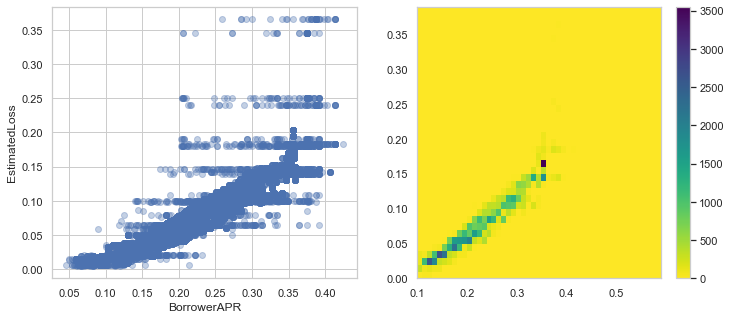

In [217]:
plt.figure(figsize = [12, 5])

x = np.arange(0.1, 0.6, 0.01)
# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
sb.regplot(data = df, x = 'BorrowerAPR', y = 'EstimatedLoss', fit_reg = False,
           x_jitter = 0.0, y_jitter = 0.00, scatter_kws = {'alpha' : 1/3})
# right plot: heat map with bin edges between values
plt.subplot(1, 2, 2)
bins_x = np.arange(0.1, 0.6, 0.01)
bins_y = np.arange(0, 0.40, 0.01)
plt.hist2d(data = df, x = 'BorrowerAPR', y = 'EstimatedLoss',
           bins = [bins_x, bins_y], cmap = 'viridis_r')
plt.colorbar();

`Comment`: Very nice correlation...let's see a fitted line

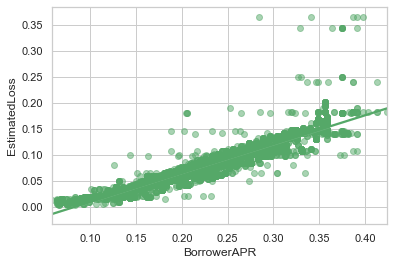

In [218]:
sb.regplot(data = pairplot_samp, x = 'BorrowerAPR', y = 'EstimatedLoss',  color="g", scatter_kws = {'alpha' : 1/2});

`Comment`: The smaller the loss the smaller the APR. We can speak here about a strong negative relationship....so what about the estimated Return?

#### BorrowerAPR vs. EstimatedReturn

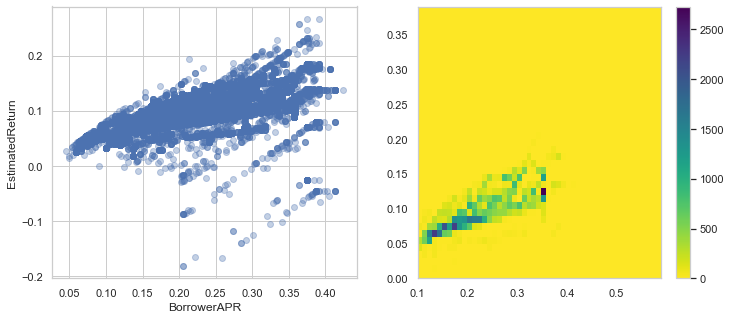

In [219]:
plt.figure(figsize = [12, 5])

x = np.arange(0.1, 0.6, 0.01)
# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
sb.regplot(data = df, x = 'BorrowerAPR', y = 'EstimatedReturn', fit_reg = False,
           x_jitter = 0.0, y_jitter = 0.00, scatter_kws = {'alpha' : 1/3})
# right plot: heat map with bin edges between values
plt.subplot(1, 2, 2)
bins_x = np.arange(0.1, 0.6, 0.01)
bins_y = np.arange(0, 0.40, 0.01)
plt.hist2d(data = df, x = 'BorrowerAPR', y = 'EstimatedReturn',
           bins = [bins_x, bins_y], cmap = 'viridis_r')
plt.colorbar();

`Comment`: Surprisingly the Return is as well in negative relationship to the APR. Why is that?  It's the way how it is calculated. The estimated yield which is the difference between the estimated yield and the loss.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

* `Summary Who is using Prosper`: 

    * It seems that the occupations and the status pretty clear shows that the occupation groups "Others" 
    * "Professional, "Executives" and "Computer Programmers" from California are most present.
    * There is a nearly equal split of Homeowners and Non-Homeowners, however the lesser the proportion of prosper user is the hisgher the homeowner proportion gets (with som eexceptions)
    * Most of the Prosper Users are "Employed (Fulltime)"
    * Most of the Prosper Users are using the loan for "Debt consolidation" 
    * The highest mean income do "Doctors" have 
    * The highest mean DebtToIncomeRation do "Teacher's Aide" have.
    * The highest mean loan amount do "Judges" have 
    * The most frequent Score is 4 along the "Others" and "Professional" group
    * The most frequent rating is C along the "Others" and "Professional" group

In general the occupation group "Other" is dominating the listings, whereas other occupations have a small proportion. This is a petty as it might be due to the fact that users have the possibility to choose from a ddlb the other category.

* `Summary: Why is Prosper used`?

    * Time2Money: Might be a reason, but fast is different, however the platform Prosper seems to accelerate with increasing listings count over time. There is a clear downward trend in Time2Money attribute, which might attract the borrowers.
    * BorrowerAPR over time: At the end of 2011 the rates have being considerable higher as before and it seems as this was the end of an upward trend, till the mid of 2014 it was constantly going down
    * BorrowerAPR by Occupation: Still not a bargain, the avg. Borrower APR is appr. 22%. Let's look if there is 


* `What is influencing the Rate`?

    * `BorrowerAPR vs. ProsperRating`: The distributions are nicely climbing with decreasing the rating. Most of the distribution are bi- or multimodal. The spread in each category is as well large. On categories AA we find many outliers to the right. In A as well and C, D have outliers as well in both directions. E has outliers to the left. Again below as an example the density and viloin plot for "E"! HR has a relatively small IQR and many outliers to the left.
    * `BorrowerAPRvs. DebtToIncomeRatio`: As we know from the beginning the correlation coeff = 0,128, so we have a weak linear relation. Below 2 the rates are going the full range we need to zoom in a bit. One thing which is looking strange is the nearly vertical line between 0,35 and appr. 0,37 along all D2IR.The majority of the values is concentrated between 0,1 and 0,4 and  0,10 to 0,25. We can see a slight upward trend in the concentrated area, but the rate also must be influenced by something else.

    * `BorrowerAPR vs Term`: We know from the Univariate Analysis that 12 month term are very seldom bit they have a lower rates as a starting point of their distributions. So 36 seems to be multimodal and 60 right skewed. Still all 3 terms give overall a wide range of rates. In 36 we see the 3rd modality which is looking similar to the concentration we saw in the DTIR between 0,35 and 0,37 let's look closer. The Medians are close to each other, the range for 60 is smaller. So this can might explain the peak line we saw in the D2IR I was mentioning before, however either it is a combination of attributes or it is another attribute which is primarily deriving the rate.
    * `ProsperScore`: We can see that the medians of the rates are increasing by decreasing the score. However 2 things are here interesting. 
        * The scores 7 - 3 are relatively wide IQRs and no (nearly) outliers. 
        * Whereas 10 to 8  and 2 to 1 are  have many outliers to the right and to the left.
        * The groups 11 and 1 are relatively small. So there is still something else which controls the rates.
    * `BorrowerRate vs. IncomeVerifiable`: The appr. 10% not having a verified income do get higher rates. So having all documents ready helps as well here.
    * `BorrowerAPR vs. IsBorrowerHomeowner`: To own a house definity  helps. We can clearly see that the median rate is lower for houseowners. 

    * `BorrowerAPR vs. StatedMonthyIncome`: We can see on the log scale that the most frequent area is 1900 and above 20000 (I mean it's monthly income). However the range of APR is still going from 5 - above 40%. Having a lot of money/month is not an indication to get better rates. We see that the fit isn't really good but it emphasizes a bit the less income the higher the rate. In the heatmap we see a that the range goes from 0,1 to 0,4 through all income levels.
    * `BorrowerAPR vs. IncomeRange`:  This makes it really visible the platform Prosper is used by well earning lenders, the spike between 0.3 and 0.4. Having a higher income definitely helps to get the best rates, however there is much variance in the distributions. The proportion of below 25k and even unemployed is very small. 
    * `BorrowerAPR vs. MonthlyPayment`: The monthly payment seems to have a limit at appr. 1000$ this is where below most of the rates are concentrated a slight trend can be seen that lower rates are drawn by higher monthly payments.

    * `BorrowerAPR vs. LoanAmount`: The higher the loan the spread of rates decreases.
    * `BorrowerAPR vs. EstimatedLos`: The smaller the loss the smaller the APR. We can speak here about a strong negative relationship....so what about the estimated Return?
    * `Estimated Return`: Surprisingly the Return is as well in negative relationship to the APR. Why is that? It's the way how it is calculated. The estimated yield which is the difference between the estimated yield and the loss.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Yes the Income Range was underlining the relationship of high incomes to better rates.

## Multivariate Exploration

### Who is using Prosper?
Let's put together some demographical attributes and soem attributes realted to finacials.

In [220]:
#top_n definitions
no_occ = 10
no_states = 10
no_li = 10

In [221]:
# create a new fied which either keeps the topn occoupation or moves it to the Other
occ_topn = df.Occupation.value_counts()[1:no_occ+1].index
occ_topn = occ_topn.astype('str')

def set_occ(occupation):
    if occupation in occ_topn:
        return(occupation)
    else:
        return('Other')
try:
    df.drop(['Occupation_Condensed'], axis=1, inplace=True)
except Exception as e:
    pass

## create a new attribute 
df['Occupation_Condensed'] = df['Occupation'].apply(set_occ)
# change the sequence to set Other at the end
sequence_occ = occ_topn 
#sequence_occ= sequence_occ.insert(len(occ_topn)+1, 'Other')
sequence_occ= sequence_occ.insert(0, 'Other')
df['Occupation_Condensed'] = pd.Categorical(df['Occupation_Condensed'], categories=sequence_occ, ordered=True)

In [222]:
# create a new fied which either keeps the topn states or moves it to the Other
states_topn = df.BorrowerState.value_counts()[0:no_states].index
states_topn = states_topn.astype('str')

def set_state(state):
    if state in states_topn:
        return(state)
    else:
        return('Other')
try:
    df.drop(['StateCondensed'], axis=1, inplace=True)
except Exception as e:
    pass
          
## create a new attribute 
df['StateCondensed'] = df['BorrowerState'].apply(set_state)
# change the sequence to set Other at the end
sequence_state = states_topn 
sequence_state= sequence_state.insert(len(states_topn)+1, 'Other')
df['StateCondensed'] = pd.Categorical(df['StateCondensed'], categories=sequence_state, ordered=True)

In [223]:
# copy again 
samples = np.random.choice(df.shape[0], 7700, replace = False)
mv = df.iloc[samples,:]

In [224]:

li_topn = df.ListingCategory_alpha.value_counts()[0:no_li].index
li_topn = li_topn.astype('str')

def set_li(li):
    if li in li_topn:
        return(li)
    else:
        pass
try:
    df.drop(['Listing_Cat_Condensed'], axis=1, inplace=True)
except Exception as e:
    pass
     
## create a new attribute 
df['Listing_Cat_Condensed'] = df['ListingCategory_alpha'].apply(set_li)
# change the sequence to set Other at the end
# change the sequence to set Other at the end
sequence_li = li_topn 
#sequence_li= sequence_li.insert(len(states_topn)+1, 'Other')
df['Listing_Cat_Condensed'] = pd.Categorical(df['Listing_Cat_Condensed'], categories=sequence_li, ordered=True)

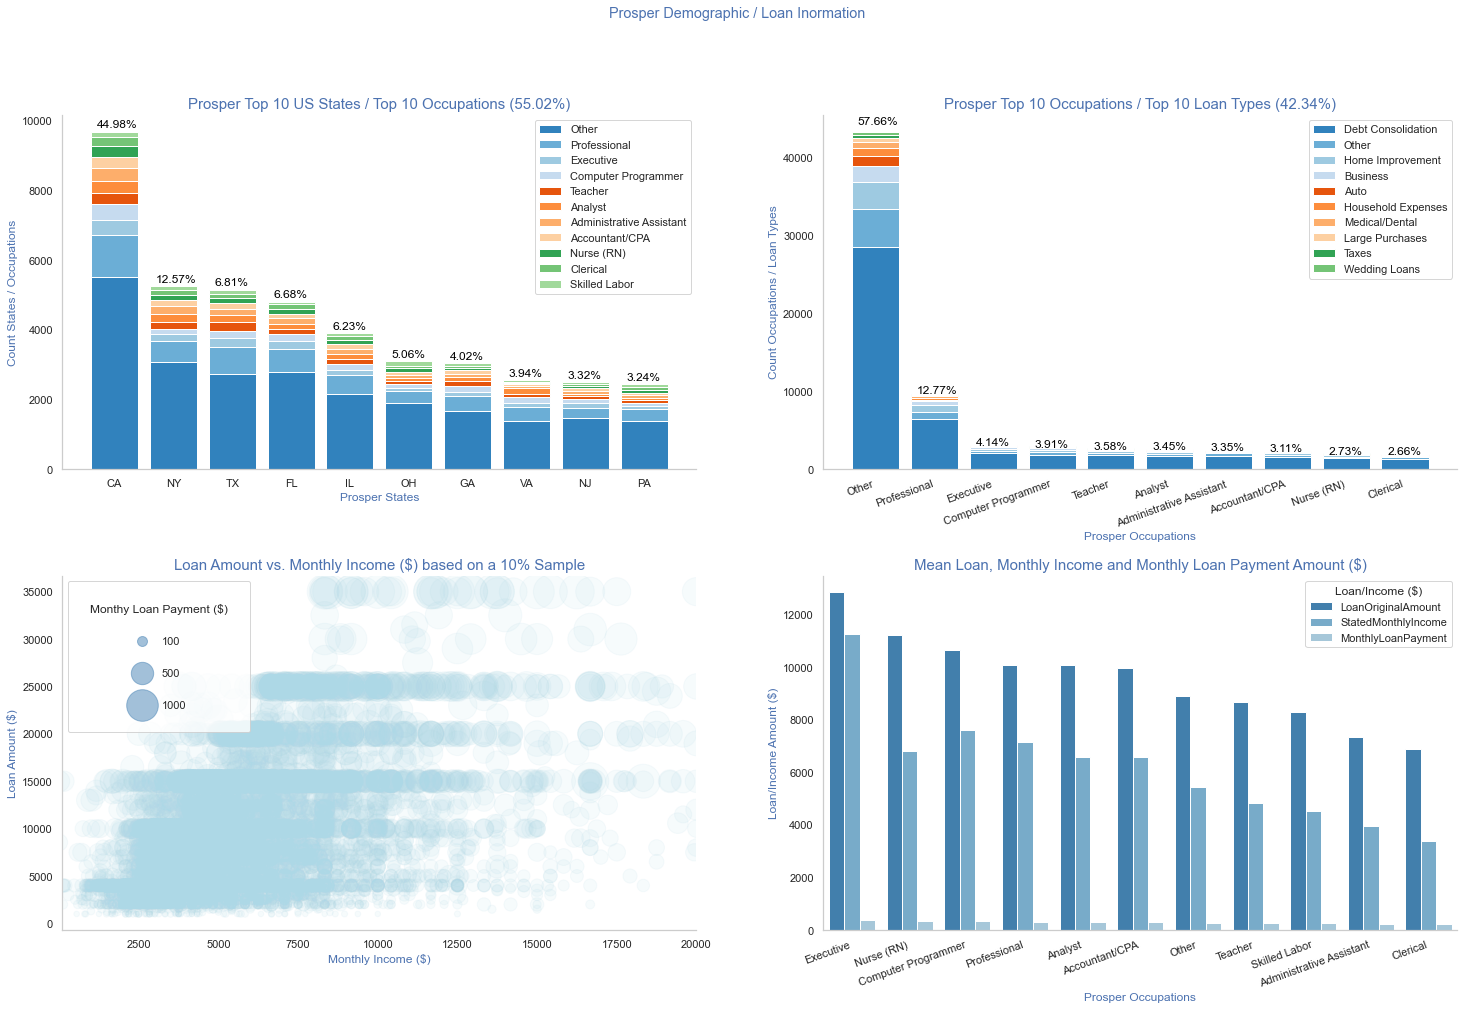

In [225]:
# common denominator
c_denominator = len(df)
name = "tab20c"
cmap = plt.get_cmap(name) 
colors = cmap.colors  # type: list

# create the main plot 
fig, ax = plt.subplots(2,2,figsize=(25,15))
plt.suptitle('Prosper Demographic / Loan Inormation', fontdict={'fontsize': 18}, color='b')
plt.subplots_adjust(hspace = 0.3)

######  upper left  #############################################
ul = ax[0,0]

# state
cat1_order =  sequence_state[:10]
# Occ
#cat2_order =  np.flip(sequence_occ) 
cat2_order =  sequence_occ
# HomeOwner
cat3_order =  sequence_state[:10]



# first iteration build occ
baselines = np.zeros(len(cat1_order))

#build "vertical" by vertical the stacekd plot
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df[df['Occupation_Condensed'] == cat2]['StateCondensed'].value_counts(normalize=False)
    # then plot those counts on top of the accumulated baseline
    ul.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],
            bottom = baselines , color=colors[i])
      #removing top and right borders
    ul.spines['top'].set_visible(False)
    ul.spines['right'].set_visible(False)
    ul.grid(False)
    baselines += inner_counts[cat1_order]

total_counts_num = df['StateCondensed'].value_counts(normalize=False)
total_counts_perc = df['StateCondensed'].value_counts(normalize=True)

# text annotations
for i in range(len(cat1_order)):
    y = str(format(total_counts_perc[i]*100 ,'.2f')) + '%'
    ul .text(i-0.3, total_counts_num[cat1_order[i]]+200, y, va = 'center', color='black', fontdict={'fontsize': 12});

    
baselines = np.zeros(len(cat1_order))  
ul.set_xticks(np.arange(len(cat1_order)))
ul.set_xticklabels(cat1_order);
ul.legend(cat2_order);
topn_total_perc = str(format((1 - total_counts_perc['Other']) * 100, '.2f')) + '%'
ul.set_title('Prosper Top 10 US States / Top 10 Occupations (' + topn_total_perc +')', fontdict={'fontsize': 15}, color='b');
ul.set_xlabel('Prosper States', fontdict={'fontsize': 12}, color='b');
ul.set_ylabel('Count States / Occupations', fontdict={'fontsize': 12}, color='b');


######  upper right  #############################################
ur = ax[0,1]

# Occupations
cat1_order =  sequence_occ[:10]
# Listings
cat2_order =  sequence_li 

# first iteration build occ
baselines = np.zeros(len(cat1_order))

#build "vertical" by vertical the stacekd plot
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df[df['Listing_Cat_Condensed'] == cat2]['Occupation_Condensed'].value_counts(normalize=False)
    # then plot those counts on top of the accumulated baseline
    ur.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],
            bottom = baselines , color=colors[i])
      #removing top and right borders
    ur.spines['top'].set_visible(False)
    ur.spines['right'].set_visible(False)
    ur.grid(False)
    baselines += inner_counts[cat1_order]

total_counts_num = df['Occupation_Condensed'].value_counts(normalize=False)
total_counts_perc = df['Occupation_Condensed'].value_counts(normalize=True)

# text annotations
for i in range(len(cat1_order)):
    y = str(format(total_counts_perc[i]*100 ,'.2f')) + '%'
    ur.text(i-0.3, total_counts_num[cat1_order[i]]+200, y, va = 'center', color='black', fontdict={'fontsize': 12});

    
baselines = np.zeros(len(cat1_order))  
ur.set_xticks(np.arange(len(cat1_order)))
ur.set_xticklabels(cat1_order, rotation = 20, ha='right');
ur.legend(cat2_order);
topn_total_perc = str(format((1 - total_counts_perc['Other']) * 100, '.2f')) + '%'
ur.set_title('Prosper Top 10 Occupations / Top 10 Loan Types (' + topn_total_perc +')', fontdict={'fontsize': 15}, color='b');
ur.set_xlabel('Prosper Occupations', fontdict={'fontsize': 12}, color='b');
ur.set_ylabel('Count Occupations / Loan Types', fontdict={'fontsize': 12}, color='b');


##################################################################
######  Lower left  #############################################
lf = ax[1,0]

lf.scatter(data = mv, x = 'StatedMonthlyIncome', y = 'LoanOriginalAmount', s = 'MonthlyLoanPayment', alpha = .1, color='lightblue')
lf.set_xlim(100,20000)
# dummy series for adding legend
sizes = [100,500, 1000 ]
base_color = sb.color_palette()[0]
legend_obj = []
# make legend
for s in sizes:
    legend_obj.append(lf.scatter([], [], s = s, alpha = .5 , color = 'steelblue'))    #color = base_color
lf.legend(legend_obj, sizes, title='Monthy Loan Payment ($)', loc='upper left',
          labelspacing=2, borderpad=2);
lf.spines['top'].set_visible(False)
lf.spines['right'].set_visible(False)
lf.grid(False)
lf.set_title('Loan Amount vs. Monthly Income ($) based on a 10% Sample', fontdict={'fontsize': 15}, color='b');
lf.set_xlabel('Monthly Income ($)', fontdict={'fontsize': 12}, color='b');
lf.set_ylabel('Loan Amount ($)', fontdict={'fontsize': 12}, color='b');


##################################################################
######  Lower right  #############################################

lr = ax[1,1]
#mv_m = mv.groupby('Occupation')['LoanOriginalAmount', 'StatedMonthlyIncome', 'MonthlyLoanPayment'].mean().reset_index()
#mv_m = mv_m[df_m['Occupation'].isin(sequence_occ)]
#mv_m['Occupation'] = df_m['Occupation'].astype('str')

mv_m = df.groupby('Occupation_Condensed')['LoanOriginalAmount', 'StatedMonthlyIncome', 'MonthlyLoanPayment'].mean().reset_index()
#mv_m = mv_m[mv_m['Occupation_Condensed'].isin(sequence_occ)]
mv_m['Occupation_Condensed'] = mv_m['Occupation_Condensed'].astype('str')

mv_m.sort_values('LoanOriginalAmount', ascending=False, inplace=True)

# bring to tidy format 
tidy = mv_m.melt(id_vars='Occupation_Condensed').rename(columns=str.title)
sb.barplot(x='Occupation_Condensed', y='Value', hue='Variable', data=tidy,  palette = colors)
lr.set_xticklabels(mv_m['Occupation_Condensed'], rotation = 20, ha='right');

lr.legend(title='Loan/Income ($)');
lr.spines['top'].set_visible(False)
lr.spines['right'].set_visible(False)
lr.grid(False)
lr.set_title('Mean Loan, Monthly Income and Monthly Loan Payment Amount ($)', fontdict={'fontsize': 15}, color='b');
lr.set_xlabel('Prosper Occupations', fontdict={'fontsize': 12}, color='b');
lr.set_ylabel('Loan/Income Amount ($)', fontdict={'fontsize': 12}, color='b');


`Comment`: Very interesting to see the demographical aspects together. 
* The top 10 states do together 55% of the total prosper business
* The Top 10 occupations is dominated by the "Other" group, Prosper should think about to "force" The users to be more precise.
  As it could be used for further analysis.
* The top 10 Occupations furthermore do more than 42% of the Prosper business
* The typical use case is debt consolidation, far ahead by all other reasons 
* The loan amounts are nicely using 5000$ steps
* The monthly loan payments are primarily influenced by the loan amount, not by the 
  monthly Income
* On average the Executives borrow the highest amounts, surprisingly they are followed 
  very closely by registered nurses

### Why is Prosper used?

In [226]:
# first create new rolling avg field for the t2m
df['Time2Money_rolling']= df['Time2Money'].rolling(window=90).mean()
# fill the nas with mean.
df['Time2Money_rolling'].fillna(df['Time2Money'].mean(), inplace = True)

In [227]:
week_time2money_avg = df.groupby([pd.Grouper(key='ListingCreationDate', freq='W-MON')])['Time2Money', 'Time2Money_rolling'].mean().reset_index().sort_values('Time2Money')

11.15765999157341


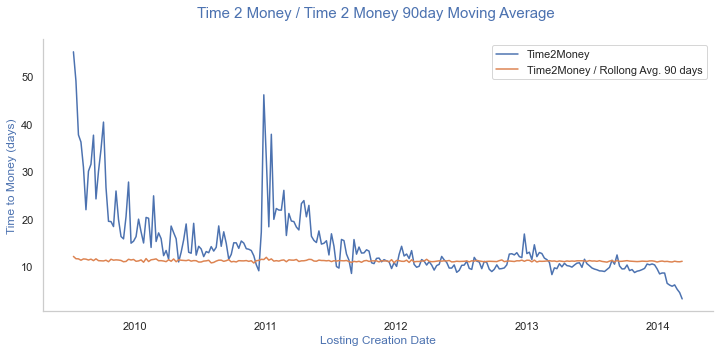

In [228]:
plt.figure(figsize = [12, 5]) # larger figure size for subplots
ax = sb.lineplot(week_time2money_avg.ListingCreationDate, week_time2money_avg.Time2Money, label='Time2Money')
ax = sb.lineplot(week_time2money_avg.ListingCreationDate, week_time2money_avg.Time2Money_rolling, label='Time2Money / Rollong Avg. 90 days')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.set_title('Time 2 Money / Time 2 Money 90day Moving Average \n', fontdict={'fontsize': 15}, color='b');
ax.set_xlabel('Losting Creation Date', fontdict={'fontsize': 12}, color='b');
ax.set_ylabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');
print(week_time2money_avg.Time2Money_rolling.mean())

`Comment`: So the 90 days moving average indicates that there is a nearly constant around appr. 11days. Is there a change by the level of debts and rating...

In [229]:
# Do the sample again
# plot matrix: sample 7000 (appr. 10%) so that plots are clearer and they render faster
# for later create a categorial Term 

df['Term_Alpha'] = pd.Categorical(df.Term, categories=[12,36,60], ordered=True)
samples = np.random.choice(df.shape[0], 7700, replace = False)
mv = df.iloc[samples,:]

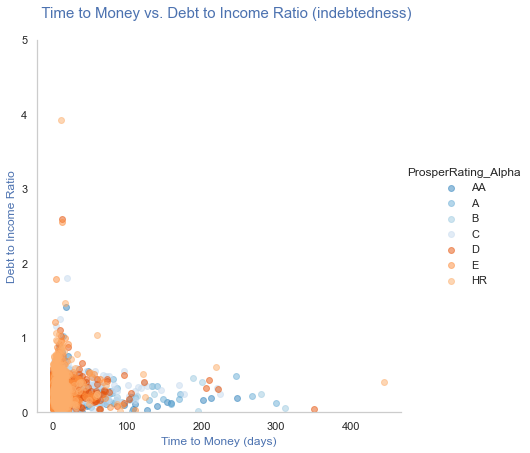

In [230]:
g = sb.FacetGrid(data = mv, hue = 'ProsperRating_Alpha', size = 6, despine=True, palette='tab20c')
g.map(plt.scatter, 'Time2Money', 'DebtToIncomeRatio',alpha = .5 )
g.set(ylim=(0, 5))
g.add_legend();
g.axes[0,0].grid(False)
g.axes[0,0].set_title('     Time to Money vs. Debt to Income Ratio (indebtedness) \n', fontdict={'fontsize': 15}, color='b');
g.axes[0,0].set_xlabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');
g.axes[0,0].set_ylabel('Debt to Income Ratio', fontdict={'fontsize': 12}, color='b');

Ok, pretty busy chart, let's zoom in

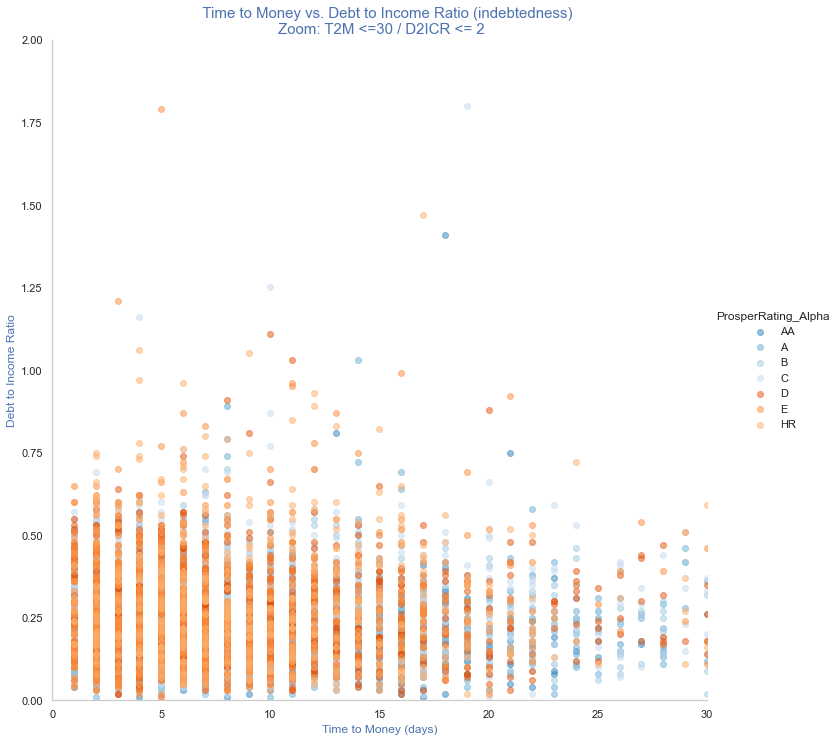

In [231]:
g = sb.FacetGrid(data = mv, hue = 'ProsperRating_Alpha', size = 10, palette='tab20c')
g.map(plt.scatter, 'Time2Money', 'DebtToIncomeRatio', alpha = .5)
g.set(xlim=(0.0, 30))
#g.set(ylim=(0, 50))
g.set(ylim=(0, 2))
g.add_legend();
g.axes[0,0].grid(False)
g.axes[0,0].set_title('     Time to Money vs. Debt to Income Ratio (indebtedness) \n Zoom: T2M <=30 / D2ICR <= 2', 
                            fontdict={'fontsize': 15}, color='b');
g.axes[0,0].set_xlabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');
g.axes[0,0].set_ylabel('Debt to Income Ratio', fontdict={'fontsize': 12}, color='b');

`Comment`: There is a wide range of days between the listing creation and the payout of the loan. There is nothing spectacular here, maybe we check in combination with the loan amount by occupation...

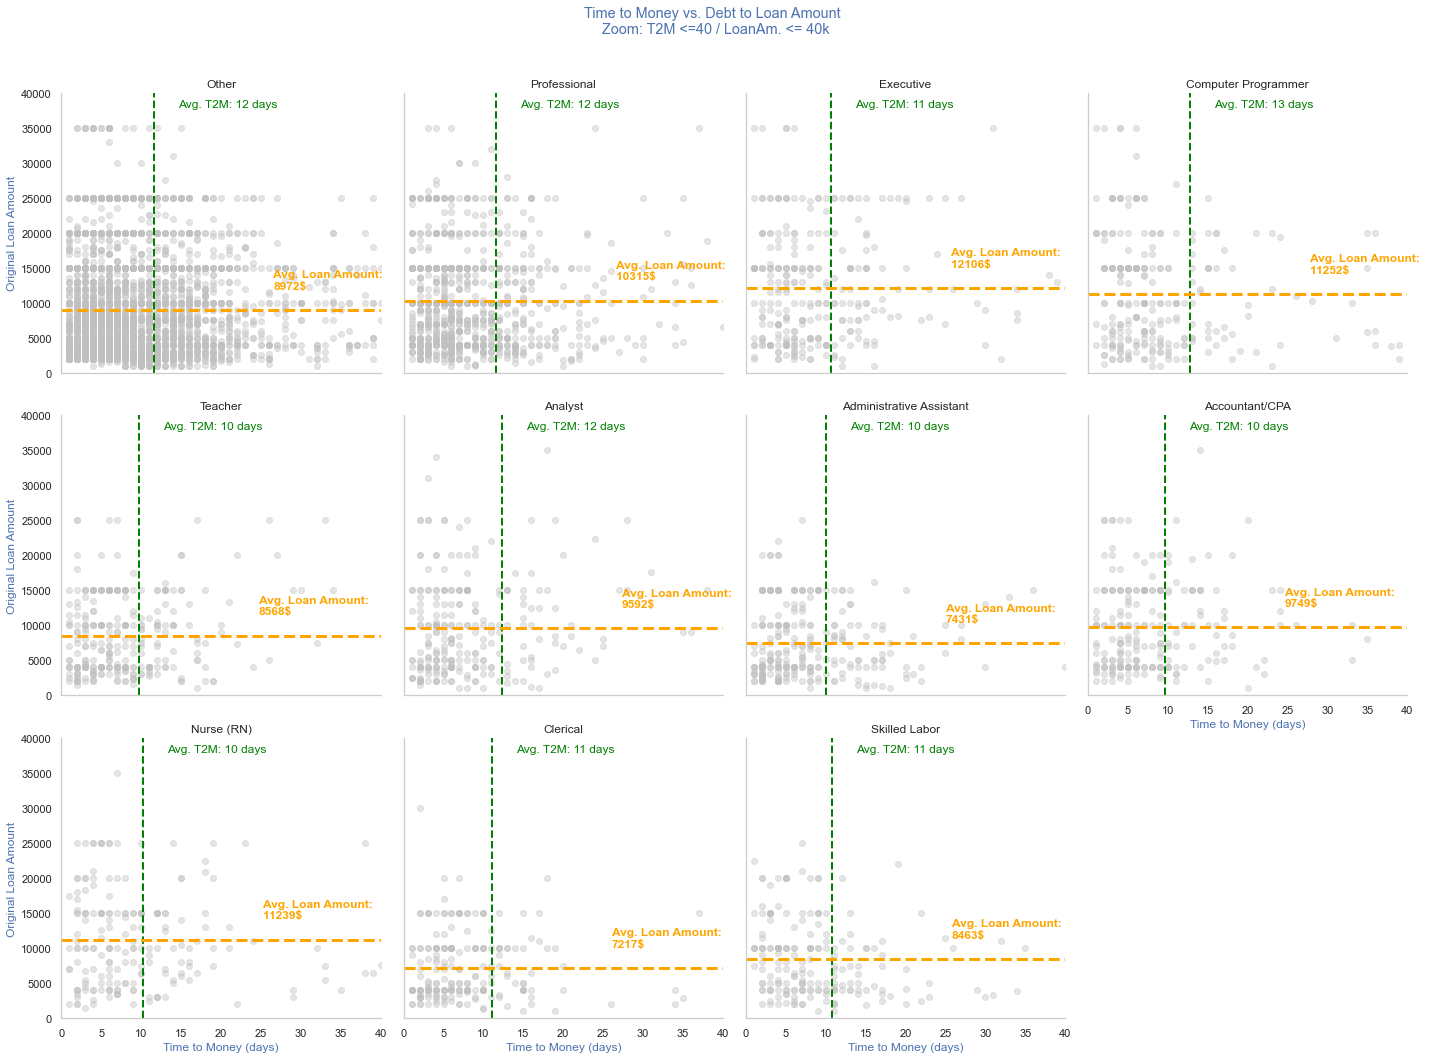

In [232]:
## functions
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='green', linestyle='dashed', linewidth=2)
    
def horizontal_mean_line(x, **kwargs):
    plt.axhline(x.mean(), color='orange', linestyle='dashed', linewidth=3) 

def annotations(x,y, **kwargs):
    avg_days = '{:0.0f} days'.format(x.mean())
    plt.text(x.mean()+3, 38000, 'Avg. T2M: ' + avg_days , color='green', fontdict={'fontsize': 12});
    avg_amount = '{:0.0f}$'.format(y.mean())
    plt.text(x.mean()+15, y.mean()+ 3000, 'Avg. Loan Amount: \n' + avg_amount , color='orange', fontdict={'fontsize': 12, 'weight': 'heavy'});

# main plot   
g = sb.FacetGrid(data = mv, col = 'Occupation_Condensed', col_wrap = 4, size = 5, sharex=True, sharey=True, despine=True)
g.map(plt.scatter, 'Time2Money','LoanOriginalAmount', alpha = .4, color='silver');
g.set(xlim=(0,40))
g.set(ylim=(0,40000))
g.map(vertical_mean_line,'Time2Money' );
g.map(horizontal_mean_line, 'LoanOriginalAmount');
g.map(annotations, 'Time2Money', 'LoanOriginalAmount');
g.set_titles('{col_name}');

for i in np.arange(g.axes.shape[0]):
    g.axes[i].grid(False)
    

    
g.axes[0].set_ylabel('Original Loan Amount', fontdict={'fontsize': 12}, color='b');
g.axes[4].set_ylabel('Original Loan Amount', fontdict={'fontsize': 12}, color='b');
g.axes[8].set_ylabel('Original Loan Amount', fontdict={'fontsize': 12}, color='b');

g.axes[7].set_xlabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');
g.axes[8].set_xlabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');
g.axes[9].set_xlabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');
g.axes[10].set_xlabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');

g.fig.suptitle('Time to Money vs. Debt to Loan Amount \n Zoom: T2M <=40 / LoanAm. <= 40k', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9)

In [233]:
df.Time2Money.mean()

11.102674171292213

In [234]:
df.LoanOriginalAmount.mean()

9300.966683093842

`Comment`: The values do not differ a lot by the top 10 occupations. As well as in comparison to the mean Time to Money (appr. 11days) and the mean Loan amount (appr. 9300$) over all occupations. This means the speed of the listing process is not significantly differing. If the Time to Money attribute is a factor for Borrowers to use Prosper can't be finally proofed as we would need to compare it with e.g. processing times of traditional banks. 

What about the interest rates, let's check the rates, in particular the BorrowerAPR whcih includes all fees...

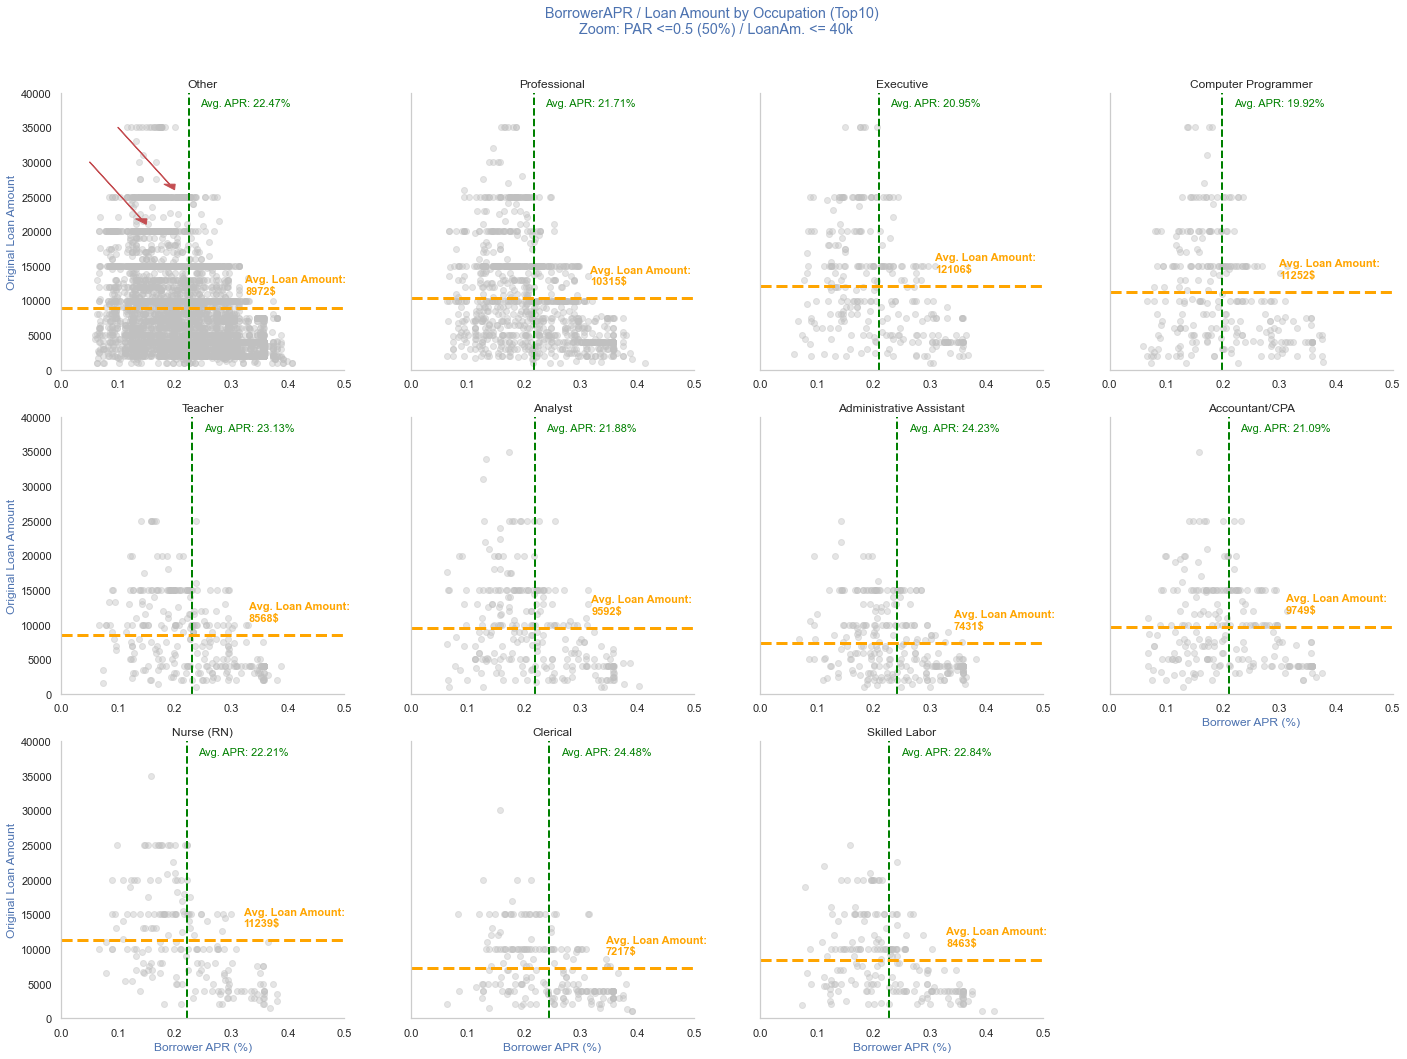

In [235]:
# functions
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='green', linestyle='dashed', linewidth=2)
    
def horizontal_mean_line(x, **kwargs):
    plt.axhline(x.mean(), color='orange', linestyle='dashed', linewidth=3) 

def annotations(x,y, **kwargs):
    avg_perc = '{:0.2f}%'.format(x.mean()*100)
    plt.text(x.mean()+.02, 38000, 'Avg. APR: ' + avg_perc , color='green', fontdict={'fontsize': 11});
    avg_amount = '{:0.0f}$'.format(y.mean())
    plt.text(x.mean()+.1, y.mean()+ 2000, 'Avg. Loan Amount: \n' + avg_amount , color='orange', fontdict={'fontsize': 11, 'weight': 'heavy'});


# main plot   
g = sb.FacetGrid(data = mv, col = 'Occupation_Condensed', col_wrap = 4, size = 5, sharex=False)
g.map(plt.scatter, 'BorrowerAPR','LoanOriginalAmount', alpha = .4, color='silver');
g.map(vertical_mean_line, 'BorrowerAPR');
g.map(horizontal_mean_line, 'LoanOriginalAmount');
g.map(annotations, 'BorrowerAPR', 'LoanOriginalAmount');
g.set(xlim=(0,.5))
g.set(ylim=(0,40000))
g.set_titles('{col_name}');

for i in np.arange(g.axes.shape[0]):
    g.axes[i].grid(False)
    
    
g.axes[0].set_ylabel('Original Loan Amount', fontdict={'fontsize': 12}, color='b');
g.axes[4].set_ylabel('Original Loan Amount', fontdict={'fontsize': 12}, color='b');
g.axes[8].set_ylabel('Original Loan Amount', fontdict={'fontsize': 12}, color='b');
g.axes[7].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 12}, color='b');
g.axes[8].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 12}, color='b');
g.axes[9].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 12}, color='b');
g.axes[10].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 12}, color='b');

#g.axes[2].set_title('LoanMount vs. APR by Occupation (Top10) \n', fontsize=18,  color="b");

# special annot.
#arrow(x, y, dx, dy, **kwargs)[source]
g.axes[0].arrow(.1, 35000, .1, -9000, length_includes_head=True,head_width=.02, head_length=800, fc='r', ec='r');
g.axes[0].arrow(.05, 30000, .1, -9000, length_includes_head=True,head_width=.02, head_length=800, fc='r', ec='r');


g.fig.suptitle('BorrowerAPR / Loan Amount by Occupation (Top10) \n Zoom: PAR <=0.5 (50%) / LoanAm. <= 40k', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9);


`Comment`: Loan Amount vs. the BorrowerAPR by Occupation is pretty much interesting. The mean APR and Loan is pretty much close to each other, however Computer Programmers get the best rates on average, 19,10%. Administrative Assistants get the worst rates, 25,59. Interesting is the fact that loan amounts e.g. 20k seem to have primarily rates better than the average of the respective occupation group. See above the red arrow annotations in the other group.

However if th rates are so good to attract the borowers would need to be analyzed with other data, e.g. data from bankloans for similar purposes and runtimes. For me the rates seem to be far high especially today (and compared to Germany). 

This leads us to the question what influences most the BorrowerAPR?


The majority of borrowers are employed, which is evident because it wouldnt be easy to get a loan without a job. To dig further, i will investigate in the next part what are their occupations.

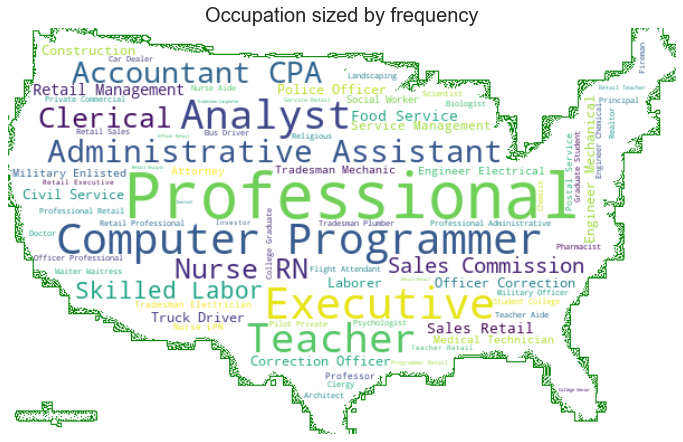

In [236]:
# Occupation sized by frequency
# Wordcloud 
text = df.loc[:, 'Occupation'].str.cat(others=None, sep=' ')

# Read the mask image
usa_mask = np.array(Image.open('usa.jpg'))

# Instantiate word cloud object
wc = WordCloud(background_color='white', max_words=200, mask=usa_mask, stopwords=STOPWORDS,
              width=640, height=480,contour_width=.01, 
                      contour_color='green')
# Generate word cloud
wc.generate(text)
# Show word cloud
plt.figure(figsize = [12, 8])
plt.imshow(wc, interpolation='bilinear')
plt.title('Occupation sized by frequency', fontsize=20)
plt.axis('off');

`Comment`: Most borrowers on Prosper indicate to be Professional, Computer Programmer, Administrative Assistant, Executive, Teacher, Analyst... All those people have chosen to borrow on Prosper instead of going to the conventional way and borrow from their commerciaL bank. This is could be due to an attractive interest rate offered for this categories of people. That what we will going to see later.

### Borrower Rate and Average Credit Score by delinquency Status

In [237]:
#Create a new column which return 1 for good status of payment('Current','Completed','FinalPaymentInProgress') 
# and 0 if there is an issue (defaulted,past due, charged-off payments)

status_good=['Current','Completed','FinalPaymentInProgress']
def cat_Loanstatus(row):
    for i in status_good:
        if i in row:
            return 1
    return 0
df["loanstatus_cat"] = df.LoanStatus.apply(lambda x: cat_Loanstatus(x))

In [238]:
df['CreditScore_average'] = (df['CreditScoreRangeLower'] + df['CreditScoreRangeUpper'])/2
status = df.groupby('loanstatus_cat').agg({'CreditScore_average':'mean','BorrowerRate':'mean'})
status = status.reset_index()
status["loanstatus_cat"].replace({0: "Delinquent", 1: "Good"}, inplace=True)
status = status.sort_values(['CreditScore_average'],ascending=False).head(10)
status

loanstatus_cat  CreditScore_average  BorrowerRate
1           Good           709.739930      0.187714
0     Delinquent           695.633036      0.250538

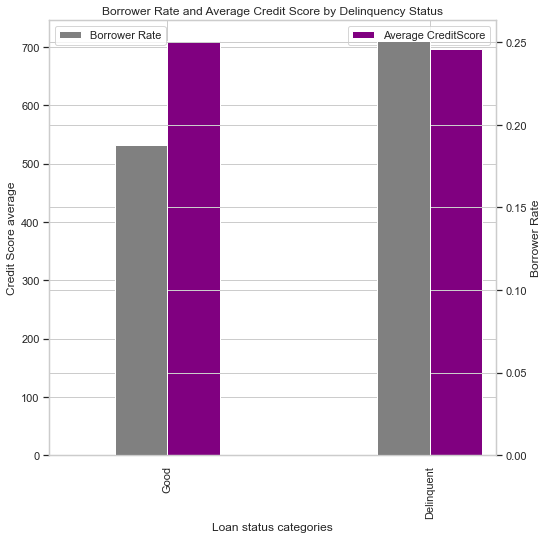

In [239]:
# Create a figure
fig = plt.figure(figsize=(8,8))
# Create matplotlib axes
ax = fig.add_subplot(111)
# Create another axes 
ax2 = ax.twinx()

width = 0.20
CreditScore_average = status.plot(x='loanstatus_cat', y='CreditScore_average', kind='bar', color = 'purple',
                   width=width,ax=ax, position = 0, label = 'Average CreditScore')
BorrowerRate = status.plot(x='loanstatus_cat', y='BorrowerRate', kind='bar', color = 'gray',
                  width=width,ax=ax2, position = 1,  label = 'Borrower Rate')

ax.set_ylabel('Credit Score average')
CreditScore_average.legend(loc='upper right')
ax2.set_ylabel('Borrower Rate')
ax2.legend(loc='upper left')
ax.set_xlabel('Loan status categories')
plt.title('Borrower Rate and Average Credit Score by Delinquency Status');

`Comment`: Its clear now that for people who are delinquent (defaulted,past due, charged-off payments), banks applies more restricted credit conditions (higher interest rates). Also these people have lower credit scores than people with good status.

### Evolution of BorrowerRate over years for Homeowners & Non-Homeowners

In [240]:
# Convert 'ListingCreationDate' type from str to datetime 
df['ListingCreationDate']=pd.to_datetime(df['ListingCreationDate'])

# Extract date information from ListingCreationDate column
df['date'] = df['ListingCreationDate'].dt.date

# Extract year information from ListingCreationDate column
df['year']= df['ListingCreationDate'].dt.year

# Convert 'date' type from str to datetime 
df['date']=pd.to_datetime(df['date'])
# df['year']=pd.to_datetime(df['year'])

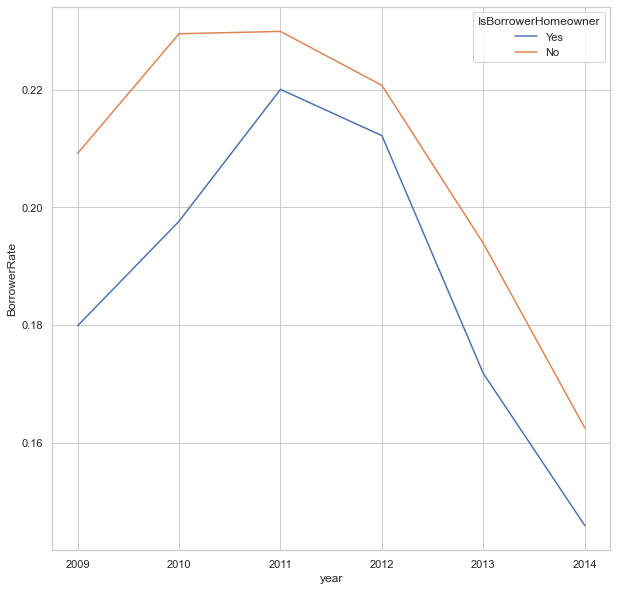

In [241]:
# plots the lineplot to analyze homeowner's and non-homeowner's rate over years
plt.figure(figsize=(10,10))
g=sb.lineplot(data=df, x='year', y='BorrowerRate', hue='IsBorrowerHomeowner',ci=None);

`Comment`: As we can see, the two rates have had the same evolution profile. As expected, rates for individuals with collateral(homeowner) are lower than those without collateral, but the gap between the two rates has decreased significantly since 2011.

### Borrower APR (Annual cost)by Employment status and delinquency Status

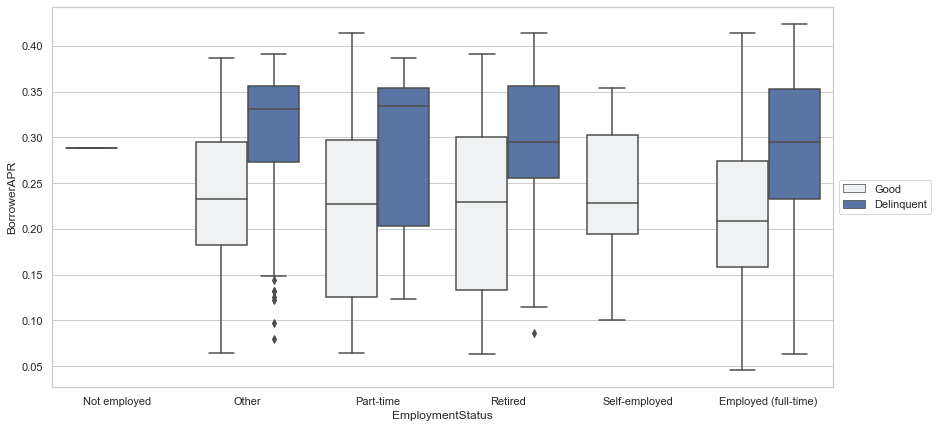

In [242]:
color_base=sb.color_palette()[0]
df["loanstatus_cat"].replace({0: "Delinquent", 1: "Good"}, inplace=True)
plt.figure(figsize=[14, 7])
sb.boxplot(data=df,x='EmploymentStatus',y='BorrowerAPR',hue='loanstatus_cat',dodge=0.3, color=color_base);
plt.xticks(rotation=0);
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)) ;

`Comment`: This figure confirmes all what have been said already that applied borrower rate is higher for unemployed people and delinquent loans( loans with bad records).

### What is influencing the rates?

Let's review some rating, income and loan attributes....

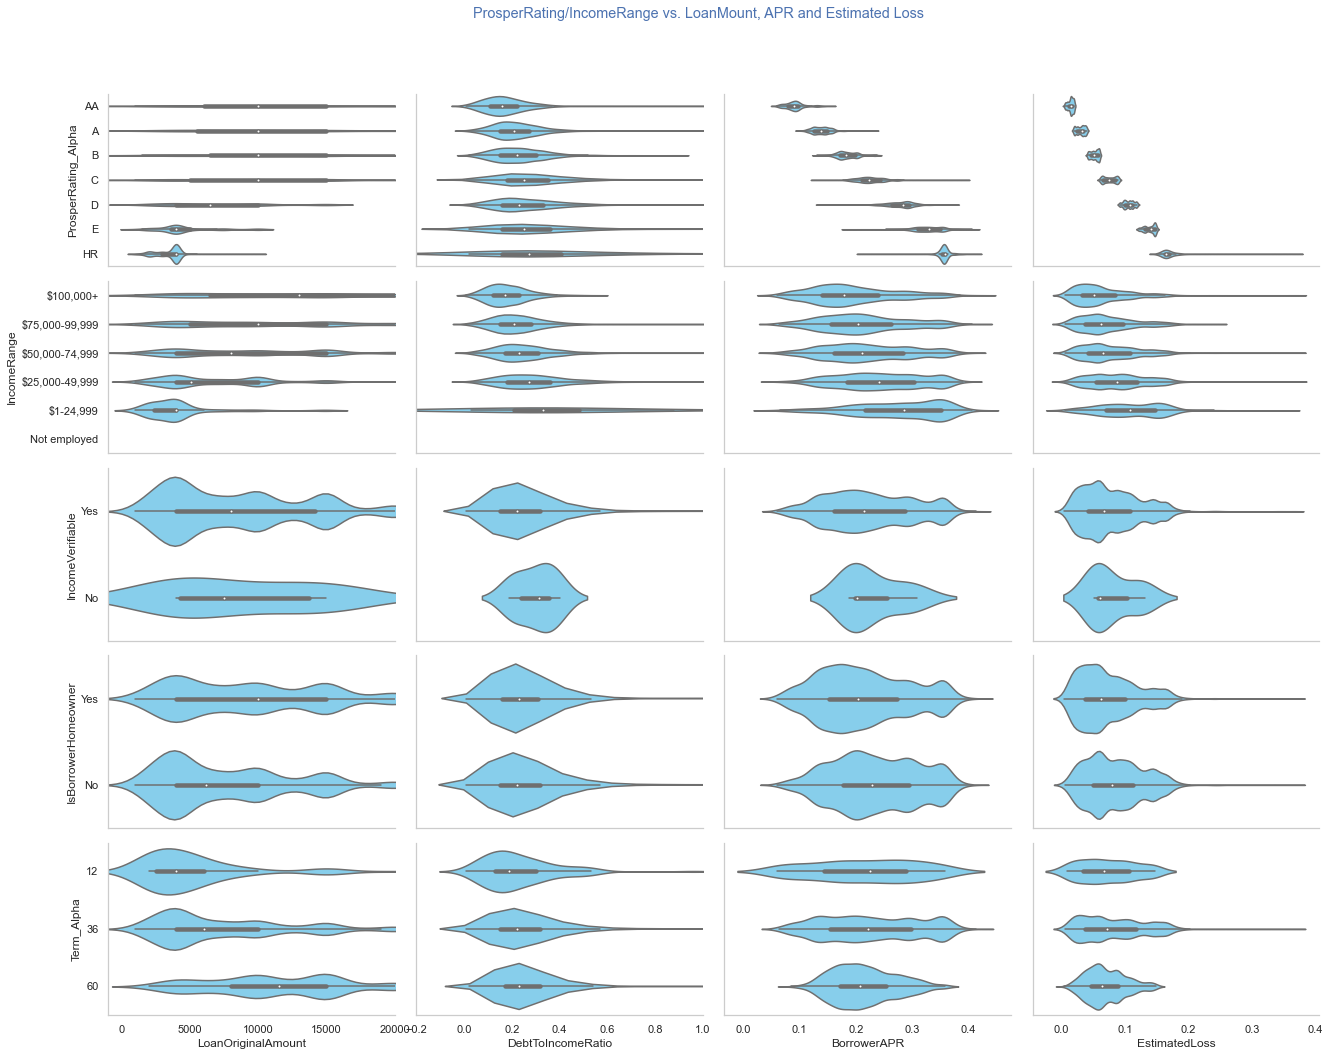

In [243]:
g = sb.PairGrid(data = mv, x_vars = ['LoanOriginalAmount', 'DebtToIncomeRatio','BorrowerAPR', 'EstimatedLoss', ],
                y_vars = ['ProsperRating_Alpha','IncomeRange', 'IncomeVerifiable', 'IsBorrowerHomeowner', 'Term_Alpha'], size=3, aspect=1.5, dropna=True)

g.map(sb.violinplot,  color='skyblue', saturation=3);
g.axes[0,0].set_xlim(-1000,20000)
g.axes[0,1].set_xlim(-0.2,1)
g.fig.suptitle('ProsperRating/IncomeRange vs. LoanMount, APR and Estimated Loss', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9)

for i in np.arange(g.axes.shape[0]):
    for j in np.arange(g.axes.shape[1]):
        g.axes[i,j].grid(False)

`Comment`: 
* HR borrowers seem to borrow less money
* The better the rating the better the lower (better) 
  the APR and the Estimated Loss will be 
* With increasing  income the range of loan amount increases 
* Not employed boorowers aren't existent
* The higher the income the higher the lower the rates
* If the income can be proofed makes a significant difference
* Only a small proportion of the loans were given w/o income validation
* Having real estate property helps to get better rates 
* The longer the term the higher the loan amount
* The rates seem to be for 12 and 60 month terms slightly better than for 36 month terms




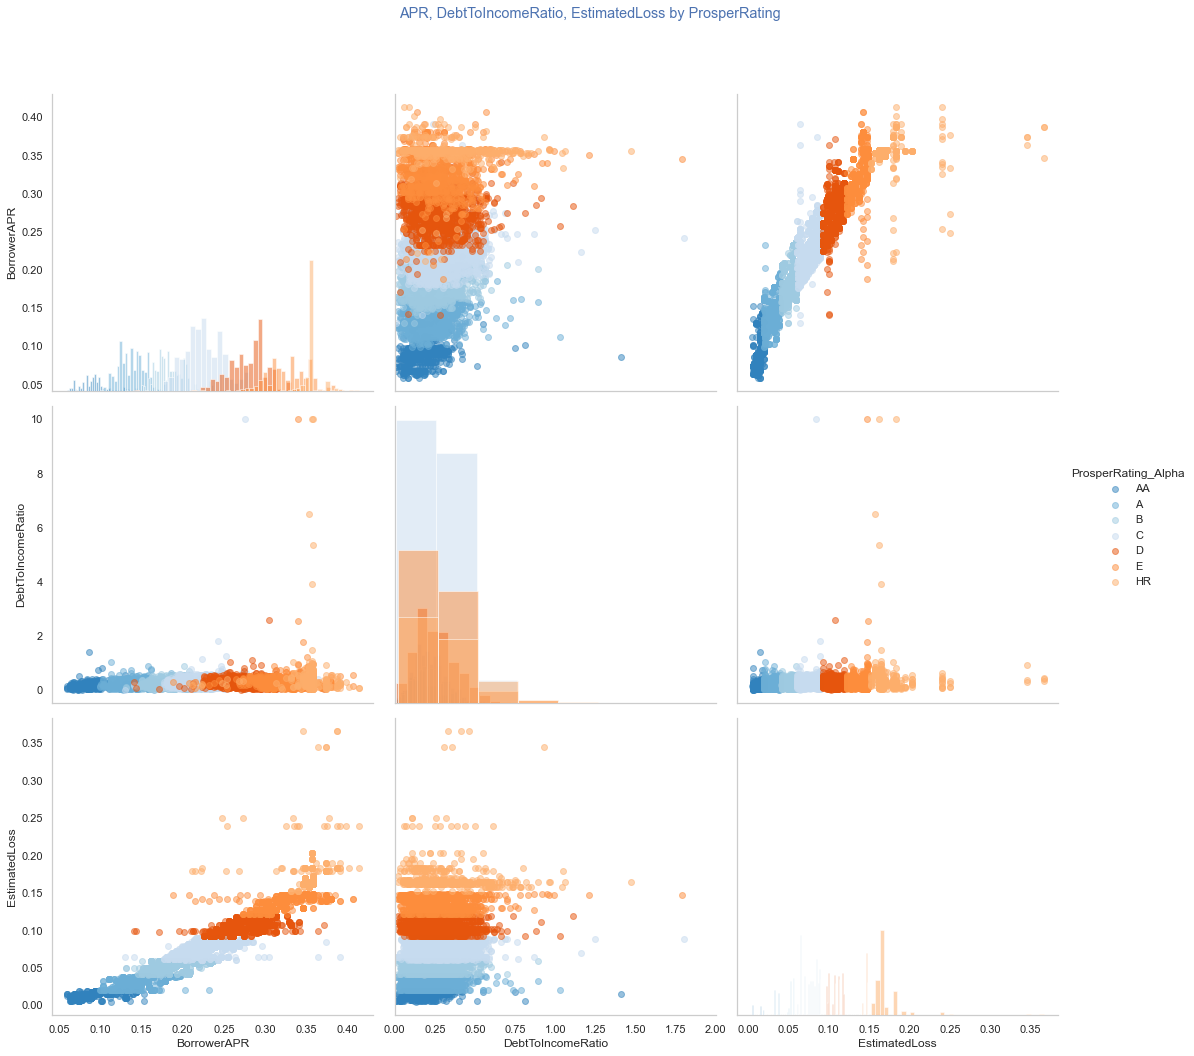

In [244]:
# attributes for metric variables 
variables = ["BorrowerAPR", "DebtToIncomeRatio", "EstimatedLoss"]
g = sb.PairGrid(data = mv, vars = variables, size = 5, hue="ProsperRating_Alpha", palette ='tab20c')
g = g.map_diag(plt.hist, bins = 40, alpha = .5);
g.map_offdiag(plt.scatter, alpha = .5);

for i in np.arange(g.axes.shape[0]):
    for j in np.arange(g.axes.shape[1]):
        g.axes[i,j].grid(False)
        
# let's improve some axis limits
g.axes[0,1].set_xlim(0,2)
g.add_legend();
g.fig.suptitle('APR, DebtToIncomeRatio, EstimatedLoss by ProsperRating ', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9);


`Comment`:  We nicely that the Prosper Rating is a mighty evaluation metric. We can clearly see that the distribution of APR is getting worse from HR to AA. Furthermore we can see that the rates are increasing with higher indebtedness (at least slightly) and decreasing Prosper Rating. Same for the estimated loss it gets slightly higher by increasing indebtedness, but much more by the assignment to the respective Prosper Rating. 

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

* The 90 days moving average indicates that there is a nearly constant around appr. 11days
* The Time2Money by the top 10 occupations do not differ a lot compared to the overall average. As well as in comparison to the mean Time to Money (appr. 11days) and the mean Loan amount (appr. 9300$) over all occupations. This means the speed of the listing process is not significantly differing. If the Time to Money attribute is a factor for Borrowers to use Prosper can't be finally proofed as we would need to compare it with e.g. processing times of traditional banks. 
* Loan Amount vs. the BorrowerAPR by Occupation is pretty much interesting. The mean APR and Loan is pretty much close to each other, however Computer Programmers get the best rates on average, 19,10%. Administrative Assistants get the worst rates, 25,59. Interesting is the fact that loan amounts e.g. 20k seem to have primarily rates better than the average of the respective occupation group. See above the red arrow annotations in the other group. However if the rates are so good to attract the borrowers would need to be analyzed with other data, e.g. data from bankloans for similar purposes and runtimes. For me the rates seem to be far high especially today (and compared to Germany). 

* HighRisk borrowers seem to borrow less money
* The better the rating the better the lower (better) the APR and the Estimated Loss will be 
* With increasing  income the range of loan amount increases 
* Not employed boorowers aren't existent
* The higher the income the higher the lower the rates
* If the income can be proofed makes a significant difference
* Only a small proportion of the loans were given w/o income validation
* Having real estate property helps to get better rates 
* The longer the term the higher the loan amount
* The rates seem to be for 12 and 60 month terms slightly better than for 36 month terms
* Prosper Rating is a mighty evaluation metric. We can clearly see that the distribution of APR is getting worse from HR to AA. Furthermore we can see that the rates are increasing with higher indebtedness (at least slightly) and decreasing Prosper Rating. Same for the estimated loss it gets slightly higher by increasing indebtedness, but much more by the assignment to the respective Prosper Rating. 

### Were there any interesting or surprising interactions between features?

* The time to Money moving average showed 11 days on a total level, the unsmoothed key-figure was much more volatile. 
* There is a phenomenon that the "nice" loan amounts like 15k, 20k, 25k are getting better rates inside the top10 occupations.

In [248]:
!jupyter nbconvert explorationprosper_slideshow.ipynb --to slides --post serve --no-input --no-prompt --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook explorationprosper_slideshow.ipynb to slides
[NbConvertApp] Writing 7564040 bytes to explorationprosper_slideshow.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\nytro\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\nytro\anaconda3\lib\site-packages\jupyter_core\application.py", line 270, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\nytro\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\nytro\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "C:\Users\nytro\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 524, in convert_notebooks
    self.convert_single_notebook(notebo